# Individual assignment Data mining 
### National Health and Nutrition Examination Survey

For this assignment we have a set of 6 different files with data available from survey research. 

In [1]:
import os
import pandas as pd
import LLMConnect
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             silhouette_score)
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import fpgrowth, association_rules
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree



# Analyzing the vegatarians
 order for us to analyze the vegatarians in the data, we must find the vegatarians. However, in the data there is no self reported vegatarian question. However, what is available is in a .xpt file on https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DS1IDS_H.htm. In this file we can see what each user who is represented by a unique SEQN, what their daily food consisted out of. There are two separate data files, where we can find the food that has been eaten by the participant. DR1IFF_H.xpt  includes the food data of day 1 and DR2IFF_H.xpt contains the food data of day 2. Not every participant in the provided 5 data files from kaggle, has participated in the food eating evaluation interviews. So we will only take the rows where the sequence number exists in both food evaluating interviews and also in the general interview. 
 
In order to label the SEQN as vegetarian or non_vegatarian, we must implement a proxy to identify a vegetarian. As proxy we use whether an individual has eaten no meat, poultry or fish. 

In [2]:
df_day1 = pd.read_sas("data/DR1IFF_H.xpt")

In [3]:
print(f"A total of {len(df_day1.SEQN.unique())} unique SEQN numbers are in the dataset")
print(f"A total of {len(df_day1)} rows are in the dataset, which means that each individual has reported {round(len(df_day1)/len(df_day1.SEQN.unique()), ndigits=1)} different food items on day 1")

A total of 8661 unique SEQN numbers are in the dataset
A total of 131394 rows are in the dataset, which means that each individual has reported 15.2 different food items on day 1


In the day 1 dataset, there are 8661 different participants who have reported 15.2 different food items for a total of 13194 total food items in day 1. 

We now want to evaluate the food items efficiently, we can use a metric which is the food group item namely "DR1CCMTX". This metric devides all possible food items in into 16 groups. Below you can see the results. We see that there is an error, the extreme negative value (5.4 * e-79), should be 0, but this might be due to the xpt reading of the food. So we should round the vlaues of DR1CCMTX

In [4]:
df_day1.DR1CCMTX.unique()

array([5.39760535e-79, 1.00000000e+00, 9.00000000e+01, 2.00000000e+00,
       3.00000000e+00, 5.00000000e+00, 1.10000000e+01, 1.00000000e+01,
       9.00000000e+00, 1.20000000e+01, 4.00000000e+00, 1.40000000e+01,
       6.00000000e+00, 8.00000000e+00, 1.30000000e+01, 7.00000000e+00])

In [5]:
df_day1["DR1CCMTX"] = round(df_day1["DR1CCMTX"])
occurrences = df_day1["DR1CCMTX"].value_counts().sort_index()
occurrences.head()

DR1CCMTX
0.0    75335
1.0    10947
2.0     5466
3.0     5300
4.0     5337
Name: count, dtype: int64

In [6]:
df_day1[df_day1["DR1IFDCD"] ==92101000.0].head()

SEQN        WTDRD1        WTDR2D  DR1ILINE  DR1DRSTZ  DR1EXMER  DRABF  \
1    73557.0  16888.327864  1.293089e+04       2.0       1.0      49.0    2.0   
11   73558.0  17932.143865  1.268415e+04       1.0       1.0      59.0    2.0   
65   73561.0  59052.357033  3.900489e+04       1.0       1.0      63.0    2.0   
72   73562.0  49890.828664  5.397605e-79       1.0       1.0      49.0    2.0   
188  73571.0  59076.733601  3.902099e+04       3.0       1.0      25.0    2.0   

     DRDINT  DR1DBIH  DR1DAY  ...      DR1IM181      DR1IM201      DR1IM221  \
1       2.0      6.0     2.0  ...  5.397605e-79  5.397605e-79  5.397605e-79   
11      2.0      4.0     1.0  ...  5.397605e-79  5.397605e-79  5.397605e-79   
65      2.0     18.0     1.0  ...  5.397605e-79  5.397605e-79  5.397605e-79   
72      1.0     11.0     3.0  ...  5.397605e-79  5.397605e-79  5.397605e-79   
188     2.0     12.0     7.0  ...  5.397605e-79  5.397605e-79  5.397605e-79   

     DR1IP182      DR1IP183      DR1IP184      DR1IP204      DR1IP205  \
1       0.004  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
11      0.006  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
65      0.001  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
72      0.003  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
188     0.002  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   

         DR1IP225      DR1IP226  
1    5.397605e-79  5.397605e-79  
11   5.397605e-79  5.397605e-79  
65   5.397605e-79  5.397605e-79  
72   5.397605e-79  5.397605e-79  
188  5.397605e-79  5.397605e-79  

[5 rows x 84 columns]

In [7]:
len(df_day1[df_day1["DR1CCMTX"] == 0]["SEQN"].unique())

8648

## First found challenge
The food combination type metric "DR1CCMTX", includes a lot of 0 values. The value 0, refers to the food combination not having a specific code in the researchers coding system. We thought we might be able to be smart and exclude the participants that have eaten food that has food code 0. But this group consists 99.9% of the dataset, so we have to find a workaround. As there are only 721 instances of food that participants have eaten food that belongs to the poultry, meat and fish group, which is number 14

You can see a table that includes the foodtypes and their respective code below

![IMG](Images/Table-food-type-codes.png)
source:  https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DRXFCD_H.htm

## How to label vegetarians

As the group of combination food codes has 57% undefined values, who might contain meat or fish. We must use a different approach to find out who in this dataset is vegetarian. There is another column that identifies what the food type can be in this dataset. It is the column DR1IFDCD, which has a column description of the USDA food code of the food, (called DR2IFDCD in day 2 dataset). So by identifying which DR1IFDCD food codes contain meat, poultry or fish, we should be able to correctly link participants to being vegetarian. 

The only missing piece that is left is to find out which food codes contain meat and which do not. Luckily, there is a description of food codes file available at the 

In [8]:
df_day1.head()

SEQN        WTDRD1        WTDR2D  DR1ILINE  DR1DRSTZ  DR1EXMER  DRABF  \
0  73557.0  16888.327864  12930.890649       1.0       1.0      49.0    2.0   
1  73557.0  16888.327864  12930.890649       2.0       1.0      49.0    2.0   
2  73557.0  16888.327864  12930.890649       3.0       1.0      49.0    2.0   
3  73557.0  16888.327864  12930.890649       4.0       1.0      49.0    2.0   
4  73557.0  16888.327864  12930.890649       5.0       1.0      49.0    2.0   

   DRDINT  DR1DBIH  DR1DAY  ...      DR1IM181      DR1IM201      DR1IM221  \
0     2.0      6.0     2.0  ...  3.595000e+00  3.400000e-02  1.000000e-03   
1     2.0      6.0     2.0  ...  5.397605e-79  5.397605e-79  5.397605e-79   
2     2.0      6.0     2.0  ...  5.397605e-79  5.397605e-79  5.397605e-79   
3     2.0      6.0     2.0  ...  8.100000e-02  5.397605e-79  5.397605e-79   
4     2.0      6.0     2.0  ...  2.600000e-02  5.397605e-79  5.397605e-79   

       DR1IP182      DR1IP183      DR1IP184      DR1IP204      DR1IP205  \
0  9.490000e-01  1.080000e-01  5.397605e-79  5.100000e-02  1.000000e-03   
1  4.000000e-03  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
2  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
3  1.030000e-01  3.100000e-02  5.397605e-79  5.397605e-79  5.397605e-79   
4  2.400000e-02  9.000000e-03  5.397605e-79  5.397605e-79  5.397605e-79   

       DR1IP225      DR1IP226  
0  5.397605e-79  1.000000e-02  
1  5.397605e-79  5.397605e-79  
2  5.397605e-79  5.397605e-79  
3  5.397605e-79  5.397605e-79  
4  5.397605e-79  5.397605e-79  

[5 rows x 84 columns]

### Importing dataset which contains food code descriptions
In this dataset we can find what each of the foodcodes means in plain english.

In [9]:
df_foodcodes_description = pd.read_sas("data/DRXFCD_H.xpt")

### Check if foodcodes are able to be linked in the previous dataset of the food interviews

In [10]:
df_day1["DR1IFDCD"][0] in df_foodcodes_description.DRXFDCD.unique()

True

In [147]:
df_day2

SEQN        WTDRD1        WTDR2D  DR2ILINE  DR2DRSTZ  DR2EXMER  \
0       73557.0  16888.327864  12930.890649       1.0       1.0      51.0   
1       73557.0  16888.327864  12930.890649       2.0       1.0      51.0   
2       73557.0  16888.327864  12930.890649       3.0       1.0      51.0   
3       73557.0  16888.327864  12930.890649       4.0       1.0      51.0   
4       73557.0  16888.327864  12930.890649       5.0       1.0      51.0   
...         ...           ...           ...       ...       ...       ...   
112573  83731.0   5805.674812   4339.132077      15.0       1.0      51.0   
112574  83731.0   5805.674812   4339.132077      16.0       1.0      51.0   
112575  83731.0   5805.674812   4339.132077      17.0       1.0      51.0   
112576  83731.0   5805.674812   4339.132077      18.0       1.0      51.0   
112577  83731.0   5805.674812   4339.132077      19.0       1.0      51.0   

        DRABF  DRDINT  DR2DBIH  DR2DAY  ...      DR2IM181      DR2IM201  \
0         2.0     2.0     12.0     1.0  ...  1.353200e+01  2.560000e-01   
1         2.0     2.0     12.0     1.0  ...  6.384000e+00  5.500000e-02   
2         2.0     2.0     12.0     1.0  ...  1.610000e-01  4.000000e-03   
3         2.0     2.0     12.0     1.0  ...  5.000000e-02  5.397605e-79   
4         2.0     2.0     12.0     1.0  ...  5.397605e-79  5.397605e-79   
...       ...     ...      ...     ...  ...           ...           ...   
112573    2.0     2.0     22.0     2.0  ...  3.600000e-01  5.397605e-79   
112574    2.0     2.0     22.0     2.0  ...  4.540000e-01  5.000000e-03   
112575    2.0     2.0     22.0     2.0  ...  8.000000e-01  7.000000e-03   
112576    2.0     2.0     22.0     2.0  ...  1.390000e-01  3.000000e-03   
112577    2.0     2.0     22.0     2.0  ...  8.000000e-02  5.397605e-79   

            DR2IM221      DR2IP182      DR2IP183      DR2IP184      DR2IP204  \
0       5.397605e-79  3.200000e+00  1.600000e-01  5.397605e-79  1.230000e-01   
1       5.397605e-79  4.053000e+00  4.040000e-01  5.397605e-79  1.890000e-01   
2       5.397605e-79  4.020000e-01  4.300000e-02  5.397605e-79  1.000000e-03   
3       5.397605e-79  1.180000e-01  3.100000e-02  5.397605e-79  5.397605e-79   
4       5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
...              ...           ...           ...           ...           ...   
112573  5.397605e-79  6.060000e-01  1.900000e-02  5.397605e-79  5.397605e-79   
112574  5.397605e-79  4.050000e-01  9.600000e-02  5.397605e-79  5.397605e-79   
112575  5.397605e-79  8.010000e-01  1.030000e-01  5.397605e-79  5.397605e-79   
112576  5.397605e-79  2.850000e-01  4.000000e-02  5.397605e-79  5.397605e-79   
112577  5.397605e-79  9.170000e-01  1.410000e-01  5.397605e-79  5.397605e-79   

            DR2IP205      DR2IP225      DR2IP226  
0       5.397605e-79  5.397605e-79  5.397605e-79  
1       5.397605e-79  7.000000e-03  5.900000e-02  
2       5.397605e-79  5.397605e-79  5.397605e-79  
3       5.397605e-79  5.397605e-79  5.397605e-79  
4       5.397605e-79  5.397605e-79  5.397605e-79  
...              ...           ...           ...  
112573  5.397605e-79  5.397605e-79  5.397605e-79  
112574  5.397605e-79  5.397605e-79  5.397605e-79  
112575  5.397605e-79  5.397605e-79  5.397605e-79  
112576  5.397605e-79  5.397605e-79  5.397605e-79  
112577  5.397605e-79  5.397605e-79  5.397605e-79  

[112578 rows x 84 columns]

The column "DR1IFDCD" from the  day 1 dataset can be linked to the column "DRXFDCD" in the food code description. So we are able to link both datasets together, and match the food codes with the descriptions. This will be important later

In [11]:
df_foodcodes_description["DRXFDCD"] = df_foodcodes_description["DRXFDCD"].apply(lambda x: int(x))
df_foodcodes_description.head()

DRXFDCD                            DRXFCSD  \
0  11000000                     b'MILK, HUMAN'   
1  11100000                       b'MILK, NFS'   
2  11111000                     b'MILK, WHOLE'   
3  11111100         b'MILK, LOW SODIUM, WHOLE'   
4  11111150  b'MILK, CALCIUM FORTIFIED, WHOLE'   

                             DRXFCLD  
0                     b'Milk, human'  
1                       b'Milk, NFS'  
2                     b'Milk, whole'  
3         b'Milk, low sodium, whole'  
4  b'Milk, calcium fortified, whole'

### Interpretation of the data
As we can see from the table above, each unique food identifier, is reprented by a binary notation. However, the proability that we can infer what food is vegatarian or not is going to be very difficult by hand, it depends on how many different ingredients there are. 

### Binary notation
The column DRXFCSD and DRXFCLD, is represented by a binary string, b''. Such a notation might become an issue later on if we try to evaluate wheter a food item consist out of meat or not. So therefore let's transform the binary string into a list of individual words

In [12]:
def turn_binary_string_to_list(df):
    df["food_list"] = df["DRXFCSD"].apply(lambda x: str(x).replace("b'", "").replace("'", "").split(","))
    return df
df_foodcodes_description = turn_binary_string_to_list(df_foodcodes_description)

It is important to understand how many individual food items there are available. We might be able to use a trick to find if the ingredients contain meat or not. Or if there are not too many, we could do so by hand. 

In [13]:
unique_elemnts_food = set([food for food_list in df_foodcodes_description.food_list.values for food in food_list])
print(f"There are {len(unique_elemnts_food)} unique ingredients in the foodcodes description")

There are 6191 unique ingredients in the foodcodes description


In [14]:
def turn_food_df_to_dict(df):
    food_code_dict = {}
    df_food_code = df[["DRXFDCD", "food_list"]]
    for index, row in df_food_code.iterrows():
        food_code_dict[row["DRXFDCD"]] = row["food_list"]
    return food_code_dict
food_code_dict = turn_food_df_to_dict(df_foodcodes_description)

## Use of LLM to create food codes
Because the food codes are so diverse, it is not feasible to identify a resistance rule without relying on a large number of if-else statements to determine the appropriate food category. Our goal is to classify whether a food is vegetarian by leveraging an LLM to analyze each data row and identify whether the food description includes fish, red meat, white meat, poultry, dairy, or other food-related products; otherwise, it is labeled as “none.” This is implemented using an LLM through the LLM Connect python file, where the process is detailed. The classification is performed by providing the LLM with a carefully designed prompt, which is demonstrated in this notebook, in the code block below. The prompt is entered into GPT-4 mini, and the output, formatted in JSON, is then used to label the data and determine if an individual is vegetarian. While this approach may feel like venturing into a rabbit hole, it provides a structured and effective method for achieving the desired labeling.




        system_message = """
                You are a food detecting agent that responds only in JSON mode.
                Analyze the following list of JSON objects representing food meals and their ingredients.
                """
        user_task = """
        You are a food detecting agent that responds only in JSON mode.
        Analyze the following list of JSON objects representing food meals and their ingredients:
        {{input_json}}
        ---

        For each ingredient in each meal, determine if it contains any of the following categories, you are allowed to 
        label multiple ingredients as 1:
        - poultry
        - red meat
        - fish
        - shellfish
        - dairy products
        - other animal products

        Return the result as a JSON array of objects with the structure:
        "meals": [
            {
                "ingredient_list": "list of food ingredients",
                "meal_number: unique_id
                "poultry": 1 or 0,
                "red_meat": 1 or 0,
                "fish": 1 or 0,
                "shellfish": 1 or 0,
                "dairy_products": 1 or 0,
                "other_animal_products": 1 or 0,
                "none": 1 or 0
            }
        ]
        Only return the array of jsons in dict formats, nothing else.
        
        """

In [15]:

def turn_json_into_segments(json_to_divide, dict_per_chunk=30):
    

    smaller_json = {}
    json_list_combined = []
    for index,(key, json_dict) in enumerate(json_to_divide.items()):
        if index % dict_per_chunk ==0 and index !=0:
            json_list_combined.append(smaller_json)
            smaller_json = {}
        smaller_json[key] = json_dict
    json_list_combined.append(smaller_json)
    return json_list_combined
    


def detect_food_json_list_dict(json_list):
    """
    Usees the LLM to create a dictionary to detect whether ingredients contain poultry, redmeat, fish, shellfish, dairy_products, other_animal_products or none of the mentioned types
    :param json_list: 
    :return: 
    """
    json_list = turn_json_into_segments(json_to_divide=json_list,
                                        dict_per_chunk=30)    
    
    
    
    LLM_translator = LLMConnect.DetectFoodIngredients(model_name="gpt-4o-mini", max_tokens=9069)
    
    complete_food_labeled_json_dict = []
    
    for index, json_dict in enumerate(json_list):
        food_json= json.dumps(json_dict)
        food_labeled_json = LLM_translator.detect_food_ingredients(input_json= food_json
                                                               )
        
        complete_food_labeled_json_dict.append(food_labeled_json)
    return complete_food_labeled_json_dict
        
def get_llm_food_code_json():
    if os.path.exists("data/complete_food_codes.json"):
        with open("data/complete_food_codes.json") as file:
            llm_food_json = json.load(file)
            
    else:
        llm_food_json = detect_food_json_list_dict(json_list=food_code_dict)
        with open("data/complete_food_codes.json", "w") as f:
            f.write(json.dumps(llm_food_json))
    return llm_food_json

complete_food_json = get_llm_food_code_json()

In [16]:
print(f"There are a total of {len(complete_food_json)} chunks of food jsons")
print(f"For a total of {len([food for chunk in complete_food_json for food in chunk["meals"]])} of individual food items")

There are a total of 285 chunks of food jsons
For a total of 8527 of individual food items


### Evaluating LLM output
As we can see from above, there are a total of 8527 individual food items that the LLM has returned. The structure of each chunk can be seen below.

`"meals": [
            {
                "ingredient_list": "list of food ingredients",\n
                "meal_number: unique_id
                "poultry": 1 or 0,
                "red_meat": 1 or 0,
                "fish": 1 or 0,
                "shellfish": 1 or 0,
                "dairy_products": 1 or 0,
                "other_animal_products": 1 or 0,
                "none": 1 or 0
            }
        ]`
        
We now have a list of chunks, each containing 30 individual food items. The first step is to create a large dictionary where each food number serves as the key, and the corresponding food codes are stored as the values. Once this dictionary is constructed, we need to verify that all data values are correctly loaded and accurately reflect the intended information. After ensuring the data’s accuracy, the final step is to match each individual food item to the corresponding entries in the food record table. This process ensures the integration and alignment of data for further analysis.

In [17]:
from copy import deepcopy
chunked_food_json = deepcopy(complete_food_json)

In [18]:
def turn_json_chunks_df(json_chunks):
    """
    groups the chunks of food_json output from the llm into a list of dictionaries
    :param json_chunks: 
    :return: 
    """
    complete_json = []
    for chunk in json_chunks:
        # Check if meals is in the chunk
        if "meals" in chunk:
            complete_json.extend(chunk["meals"])
        # If the llm named the chunk differently
        elif len(chunk.keys()) == 1:
            key_name = list(chunk.keys())[0]
            complete_json.extend(chunk[key_name])
        # If the LLM accidentally didn't give a key for the chunk
        elif len(chunk.keys()) == 9:
            complete_json.append(chunk)
        else:
            raise Exception("there is an issue with formatting")

    return complete_json

def turn_json_list_into_key_value_dict(json_list):
    """
    turns the list of dictionaries into a large dictionary, where each key is the unique food code and the value is the food encoding created by the LLM
    :param json_list: list of dictionaries of food items
    :return: 
    """
    food_json_dictionary = {json_dict["meal_number"]:json_dict for json_dict in json_list}
    [json_dict.pop("meal_number") for meal_number, json_dict in  food_json_dictionary.items()]
    return food_json_dictionary
        
exploded_food_json = turn_json_chunks_df(chunked_food_json)
print(f"there are a total of {len(exploded_food_json)} food items")
food_code_dictionary = turn_json_list_into_key_value_dict(exploded_food_json)

there are a total of 8527 food items


In [19]:
food_code_dictionary["22401000"]

{'ingredient_list': ['PORK ROAST', ' LOIN', ' COOKED', ' NS AS TO FAT'],
 'poultry': 0,
 'red_meat': 1,
 'fish': 0,
 'shellfish': 0,
 'dairy_products': 0,
 'other_animal_products': 1,
 'none': 0}

We now have a large dictionary, where each key is the unique food code and the value is the food code dictionary . We now transform the foodcode dictionary into a pandas dataframe. Subsequently, we want to merge this dataset with the food observerstion dataset of day 1 of the research participants. 

In [20]:
def turn_food_dictionary_into_pd(json_dictionary):
    """
    # Step 1: Convert the dictionary to a DataFrame
    dict_df = pd.DataFrame.from_dict(meal_dict, orient="index").reset_index()
    dict_df.rename(columns={"index": "food_code"}, inplace=True)
    :param json_dictionary: 
    :return: 
    """
    dict_df = pd.DataFrame.from_dict(json_dictionary, orient="index").reset_index()
    dict_df.rename(columns={"index": "food_code"}, inplace=True)
    return dict_df

food_code_df = turn_food_dictionary_into_pd(food_code_dictionary)
food_code_df.head()

food_code                     ingredient_list  poultry  red_meat  fish  \
0  11000000                      [MILK,  HUMAN]        0         0     0   
1  11100000                        [MILK,  NFS]        0         0     0   
2  11111000                      [MILK,  WHOLE]        0         0     0   
3  11111100         [MILK,  LOW SODIUM,  WHOLE]        0         0     0   
4  11111150  [MILK,  CALCIUM FORTIFIED,  WHOLE]        0         0     0   

   shellfish  dairy_products  other_animal_products  none  
0          0               1                      0     0  
1          0               1                      0     0  
2          0               1                      0     0  
3          0               1                      0     0  
4          0               1                      0     0

## The data has some issues
The LLM labeled ingredients to contain poultry when the only ingredient was "egg", so it might be possible that there are some wrong predictions made by the LLM. Below you can see an example. This might be because of an issue with how I explained poultry in the prompt. As the example below labeled "egg drop soup" as poultry

In [21]:
food_code_df[food_code_df["food_code"]=="32300100"]

food_code  ingredient_list  poultry  red_meat  fish  shellfish  \
3075  32300100  [EGG DROP SOUP]        1         0     0          0   

      dairy_products  other_animal_products  none  
3075               0                      0     0

After careful evaluation the following numbers were spotted that were unrelated to poultry but were labeled as poultry


In [22]:
incorrect_numbers = ["27460100", "27460100", "27460710"]
food_code_df[food_code_df["food_code"].isin(incorrect_numbers)]

food_code ingredient_list  poultry  red_meat  fish  shellfish  \
2467  27460100              []        1         1     0          0   
2470  27460710       [CHOPPED]        1         0     0          0   

      dairy_products  other_animal_products  none  
2467               0                      0     0  
2470               0                      1     0

In [23]:
def relabel_food_code(df):
    """
    there are some issues with the 
    :param df: 
    :return: 
    """
    """
    Relabel rows in the food code DataFrame where poultry is incorrectly labeled.
    Specifically, for rows where poultry is 1 but ingredients do not actually contain poultry items,
    update 'poultry' to 0 and 'other_animal_products' to 1.

    :param food_code_df: The input DataFrame containing 'poultry', 'ingredient_list', and other columns.
    :return: The updated DataFrame with corrected labels.
    """
    df_no_poultry = df[
        (df["poultry"] == 1) & 
        (~df["ingredient_list"].apply(lambda ingredients: any(
            keyword in str(ingredients).upper()
            for keyword in ["CHIC", "TURKEY", "DUCK", "WILD", "HEN", "SAUSAGE", "MEAT", "HAM", "BEEF", "STEAK", "BACON"]
        ))) & 
        (df["ingredient_list"].apply(lambda ingredients: "EGG" in str(ingredients).upper()))
    ]
    
    # Update the relevant rows in the original DataFrame
    df.loc[df_no_poultry.index, "poultry"] = 0
    df.loc[df_no_poultry.index, "other_animal_products"] = 1
    
    # Relabel the incorrect numbers to become "none"
    incorrect_numbers = ["27460100", "27460100", "27460710"]
    df_no_poultry_none = df[df["food_code"].isin(incorrect_numbers)] 
    df.loc[df_no_poultry_none.index, "poultry"] = 0
    df.loc[df_no_poultry_none.index, "red_meat"] = 0
    df.loc[df_no_poultry_none.index, "none"] = 1
    return df

    
food_code_df = relabel_food_code(food_code_df)

### Merge dataframe observations day 1 with meat related product codes

Important to note, is that I named the unique food code a more descriptive name : food_code. But in the food description dataset this is actually called "DRXFDCD". However, in day 1 dataset the unique food code in the dataset this is actually called "DR1IFDCD". Therefore we have to rename the food_code column in the food description table to how the food code is called in the day_1 dataframe. 

In [24]:
def merge_food_code_df(df_day, df_food_codes, food_code_col_name):
    """
    Merges the obseverations of with the meat related labels
    :param df_day: 
    :param df_food_codes: 
    :param food_code_col_name: the name of the column in the df_day that represents the food code
    
    :return: 
    """
    df_day_to_merge = df_day.copy()
    # change the value of DR1IFDCD to integer. because it is in float representation when initially loaded
    df_day_to_merge[food_code_col_name] = df_day_to_merge[food_code_col_name].astype(int)
    df_food_codes_to_merge = df_food_codes.copy()
    
    df_food_codes_to_merge = df_food_codes_to_merge.rename(columns= {"food_code": food_code_col_name})
    df_food_codes_to_merge[food_code_col_name] = df_food_codes_to_merge[food_code_col_name].astype(int)
    df_day_to_merge = df_day_to_merge.merge(df_food_codes_to_merge, on=food_code_col_name, how="left")
    return df_day_to_merge

df_day_1_food_code = merge_food_code_df(df_day1, food_code_df, food_code_col_name="DR1IFDCD")
df_day_1_food_code.head()

SEQN        WTDRD1        WTDR2D  DR1ILINE  DR1DRSTZ  DR1EXMER  DRABF  \
0  73557.0  16888.327864  12930.890649       1.0       1.0      49.0    2.0   
1  73557.0  16888.327864  12930.890649       2.0       1.0      49.0    2.0   
2  73557.0  16888.327864  12930.890649       3.0       1.0      49.0    2.0   
3  73557.0  16888.327864  12930.890649       4.0       1.0      49.0    2.0   
4  73557.0  16888.327864  12930.890649       5.0       1.0      49.0    2.0   

   DRDINT  DR1DBIH  DR1DAY  ...      DR1IP225      DR1IP226  \
0     2.0      6.0     2.0  ...  5.397605e-79  1.000000e-02   
1     2.0      6.0     2.0  ...  5.397605e-79  5.397605e-79   
2     2.0      6.0     2.0  ...  5.397605e-79  5.397605e-79   
3     2.0      6.0     2.0  ...  5.397605e-79  5.397605e-79   
4     2.0      6.0     2.0  ...  5.397605e-79  5.397605e-79   

                                     ingredient_list  poultry  red_meat  fish  \
0        [EGG, CHEESE & BACON GRIDDLE CAKE SANDWICH]      1.0       1.0   0.0   
1                                   [COFFEE, BREWED]      0.0       0.0   0.0   
2     [SUCRALOSE-BASED SWEETENER,  SUGAR SUBSTITUTE]      0.0       0.0   0.0   
3  [ORANGE JUICE, 100%, WITH CALCIUM, CANNED, BOT...      0.0       0.0   0.0   
4                                      [ORANGE, RAW]      0.0       0.0   0.0   

   shellfish  dairy_products  other_animal_products  none  
0        0.0             1.0                    1.0   0.0  
1        0.0             0.0                    0.0   1.0  
2        0.0             0.0                    0.0   1.0  
3        0.0             0.0                    0.0   1.0  
4        0.0             0.0                    0.0   1.0  

[5 rows x 92 columns]

### Grouping the day_1 table based on SEQN
To prepare the data for merging with another dataset, we need to ensure that each unique person (identified by SEQN) has a single aggregated value for their dietary labels. Since a person may have multiple food instances across the day, we will group all food instances by SEQN and aggregate the dietary labels (fish, white_meat, poultry, dairy, red_meat, other) to a single value for each label.

This will be done for each day separately, and we will create a function to handle this grouping and aggregation. The function will:
	1.	Accept the DataFrame and the day identifier as inputs.
	2.	Group the data by SEQN and aggregate each dietary column using the max function. This ensures that if any food item contains a particular dietary label, it is reflected in the aggregated value for the person.
	3.	Return the grouped DataFrame with one row per SEQN.

This function will be reusable for processing data for both the first and second days.

In [25]:
def group_dietary_labels_by_seqn(df):
    """
    Groups dietary labels by SEQN (person identifier) for a specific day.
    
    Parameters:
    df (DataFrame): The input DataFrame with food instances and dietary labels.
    
    Returns:
    DataFrame: A grouped DataFrame with one row per SEQN and aggregated dietary labels.
    """
    # Group by SEQN and aggregate dietary columns using the max function
    grouped_df = (
        df.groupby("SEQN")[["fish", "shellfish", "poultry", "dairy_products", "red_meat", "other_animal_products", "none"]]
        .sum()
        .reset_index()
    )
    grouped_df = grouped_df.rename(columns={"none": "no_animal_products"})
    
    
    return grouped_df

# Example usage for the first day
grouped_day1 = group_dietary_labels_by_seqn(df_day_1_food_code)

# If you have a second day's data, you can use the same function:
# grouped_day2 = group_dietary_labels_by_seqn(merged_df_day2, "Day 2")

grouped_day1.head()

SEQN  fish  shellfish  poultry  dairy_products  red_meat  \
0  73557.0   0.0        0.0      1.0             3.0       2.0   
1  73558.0   1.0        2.0      0.0             4.0       0.0   
2  73559.0   0.0        0.0      0.0             4.0       1.0   
3  73560.0   0.0        0.0      0.0             8.0       2.0   
4  73561.0   0.0        0.0      0.0             4.0       0.0   

   other_animal_products  no_animal_products  
0                    3.0                 8.0  
1                    0.0                 3.0  
2                    1.0                22.0  
3                    1.0                 9.0  
4                    0.0                 3.0

# Grouping the day_2 eating habits
For day two, we aim to replicate the same process we performed for day one. Specifically, we want to determine, for each unique sequence number, how many times during the day an individual consumed poultry, red meat, other types of meat, dairy, fish, shellfish, or other animal products—or if they consumed none of these at all. This data will provide us with valuable insights.

In the second day, the food code is called differently. It is called "DR2IFDCD", so we have to adjust the process slightly

To achieve this, we need to perform all the necessary preprocessing steps. Which consists of merging the food codes on day_2 dataset, and then grouping them together based on SEQN

### Steps
1. Load day_2 data into pandas dataframe
2. Add meat related product labels to day_2 data based on Food identifier 
3. Group the data based on SEQN and sum up all values

In [26]:
df_day2 = pd.read_sas("data/DR2IFF_H.xpt")
grouped_day2 = group_dietary_labels_by_seqn(
    df= merge_food_code_df(
        df_day=df_day2,
        df_food_codes=food_code_df,
        food_code_col_name= "DR2IFDCD"
    )
)
grouped_day2.head()

SEQN  fish  shellfish  poultry  dairy_products  red_meat  \
0  73557.0   0.0        0.0      1.0             0.0       2.0   
1  73558.0   0.0        0.0      2.0             3.0       1.0   
2  73559.0   1.0        0.0      0.0             5.0       0.0   
3  73560.0   0.0        0.0      0.0             2.0       2.0   
4  73561.0   0.0        0.0      0.0             5.0       0.0   

   other_animal_products  no_animal_products  
0                    2.0                10.0  
1                    0.0                 3.0  
2                    1.0                12.0  
3                    0.0                 6.0  
4                    0.0                 3.0

## Statistical differences between both days
The data in day_1 is gathered by a researcher during an interview with the participant in person. While the second interview in day_2 was done over the phone. In both occasions, the participant was asked about its eating habits of the past 24 hours. However, we can see that the distribution is much different between both days. People should eat the same amount between different days. But in day_2, there are fewer observations of food instances. On top of that, not everyone who participated in day_1, also participated in day_2 as people were not able to pick up the phone in every case (Storz et al, 2022)

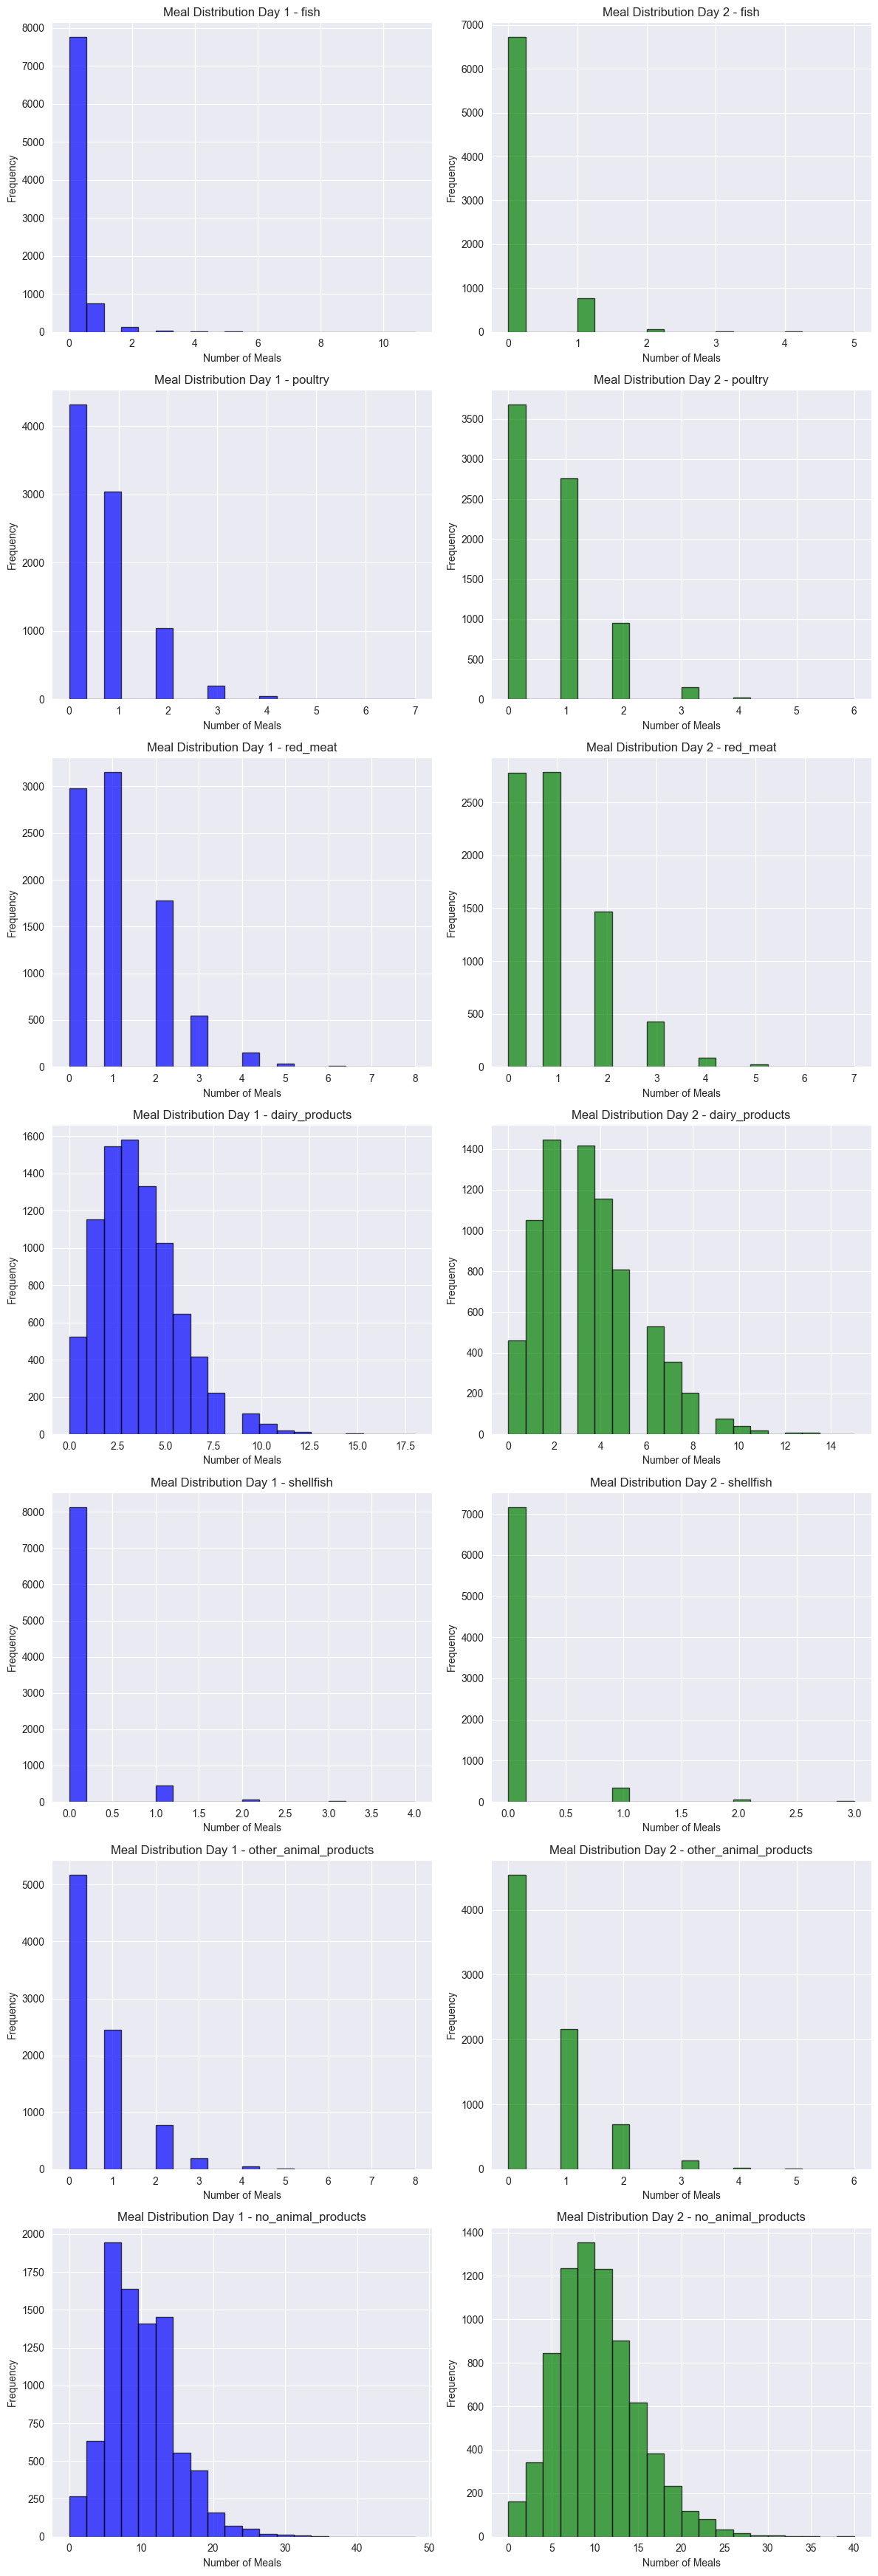

In [27]:
import matplotlib.pyplot as plt

def plot_meal_distributions(day1_data, day2_data, columns, title_prefix=""):
    """
    Plots distributions of meals for given categories for day one and day two.
    
    Parameters:
    - day1_data: DataFrame with data for day one
    - day2_data: DataFrame with data for day two
    - columns: List of column names representing the categories (e.g., fish, poultry)
    - title_prefix: String prefix for the title of the plots
    """
    # Set up the figure with subplots (rows = len(columns), cols = 2 for day1 and day2)
    num_categories = len(columns)
    fig, axes = plt.subplots(nrows=num_categories, ncols=2, figsize=(12, 5 * num_categories))
    
    # Ensure axes is a 2D array for consistent handling
    axes = axes.reshape((num_categories, 2))
    
    # Loop through each category and plot distributions
    for i, column in enumerate(columns):
        # Day 1 plot
        axes[i, 0].hist(day1_data[column], bins=20, alpha=0.7, color="blue", edgecolor="black")
        axes[i, 0].set_title(f"{title_prefix} Day 1 - {column}")
        axes[i, 0].set_xlabel("Number of Meals")
        axes[i, 0].set_ylabel("Frequency")
        
        # Day 2 plot
        axes[i, 1].hist(day2_data[column], bins=20, alpha=0.7, color="green", edgecolor="black")
        axes[i, 1].set_title(f"{title_prefix} Day 2 - {column}")
        axes[i, 1].set_xlabel("Number of Meals")
        axes[i, 1].set_ylabel("Frequency")
    
    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Example Usage
# Define the columns for the animal product categories
columns = ["fish", "poultry", "red_meat", "dairy_products", "shellfish", "other_animal_products", "no_animal_products"]

# Assuming 'grouped_day1' and 'grouped_day2' are the DataFrames for day one and day two
plot_meal_distributions(grouped_day1, grouped_day2, columns, title_prefix="Meal Distribution")

# Merge both days into a single day

The number of participants in Day 2 is lower than in Day 1 because not everyone participated on the second day. To strengthen our proxy for determining whether someone is vegetarian, we will include only those participants who are present in both Day 1 and Day 2 datasets. To achieve this, we will group the data together and filter it to retain only the sequence numbers that are present in both data frames. This approach ensures that our analysis is based on participants with complete data from both days.

We group both days together in the same table, and filter for participants that have participated in day_1 and day_2

In [28]:
def group_days(df_1, df_2):
    """
    Groups participants from Day 1 and Day 2, retaining only those who participated on both days.
    Merges the data for both days and sums the values for specific columns.
    
    Parameters:
    - df_1: DataFrame for Day 1
    - df_2: DataFrame for Day 2
    
    Returns:
    - DataFrame with summed values for participants present on both days.
    """
    participants_day_1 = set(df_1["SEQN"].unique())
    participants_day_2 = set(df_2["SEQN"].unique())
    
    # Find participants present in both days
    participants_both_days = participants_day_1.intersection(participants_day_2)
    
    # Filter both dataframes to include only participants present in both days
    filtered_day_1 = df_1[df_1["SEQN"].isin(participants_both_days)]
    filtered_day_2 = df_2[df_2["SEQN"].isin(participants_both_days)]
    
    # merge both together and sum up all the values
    columns = ["fish", "poultry", "red_meat", "dairy_products", "shellfish", "other_animal_products", "no_animal_products"]
    # Merge both DataFrames by SEQN and sum the values for the specified columns
    merged_df = pd.concat([filtered_day_1, filtered_day_2])
    grouped_df = merged_df.groupby("SEQN")[columns].sum().reset_index()
    
    return grouped_df

food_df_both_days = group_days(grouped_day1, grouped_day2)
food_df_both_days.head()

SEQN  fish  poultry  red_meat  dairy_products  shellfish  \
0  73557.0   0.0      2.0       4.0             3.0        0.0   
1  73558.0   1.0      2.0       1.0             7.0        2.0   
2  73559.0   1.0      0.0       1.0             9.0        0.0   
3  73560.0   0.0      0.0       4.0            10.0        0.0   
4  73561.0   0.0      0.0       0.0             9.0        0.0   

   other_animal_products  no_animal_products  
0                    5.0                18.0  
1                    0.0                 6.0  
2                    2.0                34.0  
3                    1.0                15.0  
4                    0.0                 6.0

In [29]:
# put all the people who have participated in both food review 
participants_2_food_days = food_df_both_days["SEQN"].unique()

# Laboratory results dataframe and questionare results dataframe

Now that we have our variables prepared, the next step is to gather the laboratory results data and the questionnaire data. From the questionnaire data, we will use a specific column to determine whether participants have been diagnosed with osteoporosis. Additionally, from the laboratory data, we will extract the results of blood tests. Using this combined information, we will proceed with the analysis to explore the relationships between dietary patterns, blood test results, and osteoporosis diagnosis.

In [30]:
df_questionare = pd.read_csv("data/questionnaire.csv")
df_questionare.head()

SEQN  ACD011A  ACD011B  ACD011C  ACD040  ACD110  ALQ101  ALQ110  ALQ120Q  \
0  73557      1.0      NaN      NaN     NaN     NaN     1.0     NaN      1.0   
1  73558      1.0      NaN      NaN     NaN     NaN     1.0     NaN      7.0   
2  73559      1.0      NaN      NaN     NaN     NaN     1.0     NaN      0.0   
3  73560      1.0      NaN      NaN     NaN     NaN     NaN     NaN      NaN   
4  73561      1.0      NaN      NaN     NaN     NaN     1.0     NaN      0.0   

   ALQ120U  ...  WHD080U  WHD080L  WHD110  WHD120  WHD130  WHD140  WHQ150  \
0      3.0  ...      NaN     40.0   270.0   200.0    69.0   270.0    62.0   
1      1.0  ...      NaN      NaN   240.0   250.0    72.0   250.0    25.0   
2      NaN  ...      NaN      NaN   180.0   190.0    70.0   228.0    35.0   
3      NaN  ...      NaN      NaN     NaN     NaN     NaN     NaN     NaN   
4      NaN  ...      NaN      NaN   150.0   135.0    67.0   170.0    60.0   

   WHQ030M  WHQ500  WHQ520  
0      NaN     NaN     NaN  
1      NaN     NaN     NaN  
2      NaN     NaN     NaN  
3      3.0     3.0     3.0  
4      NaN     NaN     NaN  

[5 rows x 953 columns]

In [31]:
df_questionare = df_questionare.rename(columns={"OSQ060": "has_osteoporosis"})
df_y_label = df_questionare["has_osteoporosis"]

df_y_label = df_y_label.fillna(0)
df_y_label.value_counts()

has_osteoporosis
0.0    6360
2.0    3481
1.0     322
9.0      12
Name: count, dtype: int64

### Interpretation of the questionare 

The question wheter it was asked if someone has osteoporosis, is only asked when participants were 40 years or older (https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/OSQ_H.htm#OSQ060). Therefore, to make knowledgeable conclusions. Further in the research, we will remove the participants that have not received this answer in our predictive model. 

We renamed the column OSQ060 to has_osteoporosis, to give the column a more descriptive name. The question OSQ060 in the questionare has as description:
- Has a doctor ever told {you/SP} that {you/s/he} had osteoporosis, sometimes called thin or brittle bones?

Value meaning: 
- 0 = Person is not given the question because he/she is younger than 40 years
- 1 = Yes person has osteoporosis
- 2 = No person has not osteoporosis
- 9 = Person doesn't know

We will give the number 9, the number 1, and assume that the person doesn't have osteoporosis. 


In [32]:
df_y_label.head()

0    2.0
1    2.0
2    1.0
3    0.0
4    2.0
Name: has_osteoporosis, dtype: float64

### Creating the y label for predictive model

The questionare dataframe will be used to form a y label. The column has_osteoporosis (original name "OSQ060"), will become a binary y label. The participants that have not answered this question because they were too young are excluded (0). The participants that didn't know if the doctor told them they has osteoporosis (9) or answered with no to (2) , will get the label 0 has_osteoporosis. And the participants that answered with yes (1), will receive value 1 for the label ha_osteoporosis.

In [33]:
def get_y_label_from_questionaire(df):
    

    df_osteoporosis = df[
        (df["has_osteoporosis"] == 1) | 
        (df["has_osteoporosis"] == 2) | 
        (df["has_osteoporosis"] == 9)
        ]
    df_osteoporosis = df_osteoporosis.replace({9: 0, 1: 1, 2: 0})
    return df_osteoporosis[["SEQN", "has_osteoporosis"]]

    
df_y_label = get_y_label_from_questionaire(df_questionare)
df_y_label.head()

SEQN  has_osteoporosis
0  73557               0.0
1  73558               0.0
2  73559               1.0
4  73561               0.0
5  73562               0.0

In [34]:
print(f"A total of {len(df_y_label[(df_y_label["SEQN"].isin(participants_2_food_days))])} participants have data availalbe for day_1 and day_2 food eating interview and have received the question whether they have osteoporosis in the questionaire")
participants_2_food_days_osteoporosis = df_y_label[df_y_label["SEQN"].isin(participants_2_food_days)]

A total of 2999 participants have data availalbe for day_1 and day_2 food eating interview and have received the question whether they have osteoporosis in the questionaire


## Examination data
DXDTOBMD -> Total Bone Mineral Density (g/cm^2)


In [35]:
def get_bone_mineral_density():

    df_examination = pd.read_sas("data/DXX_H.xpt")
    df_examination.rename(columns={"DXDSTBMD": "Total bone density"}, inplace=True)
    return df_examination

df_density = get_bone_mineral_density()

df_density_y_label = df_y_label.merge(df_density[["SEQN", "Total bone density"]], on="SEQN", how="left")
df_density_y_label.groupby('has_osteoporosis').mean()

SEQN  Total bone density
has_osteoporosis                                  
0.0               78626.070999            0.970279
1.0               78669.385093            0.843595

In [36]:
df_density_y_label

SEQN  has_osteoporosis  Total bone density
0     73557               0.0                 NaN
1     73558               0.0               0.965
2     73559               1.0                 NaN
3     73561               0.0                 NaN
4     73562               0.0               1.018
...     ...               ...                 ...
3810  83721               0.0               1.117
3811  83723               0.0                 NaN
3812  83724               0.0                 NaN
3813  83726               0.0               1.049
3814  83729               0.0               0.927

[3815 rows x 3 columns]

In [37]:
df_lab = pd.read_csv("data/labs.csv")
df_lab.head()

SEQN  URXUMA  URXUMS  URXUCR.x   URXCRS  URDACT     WTSAF2YR.x  LBXAPB  \
0  73557     4.3     4.3      39.0   3447.6   11.03            NaN     NaN   
1  73558   153.0   153.0      50.0   4420.0  306.00            NaN     NaN   
2  73559    11.9    11.9     113.0   9989.2   10.53  142196.890197    57.0   
3  73560    16.0    16.0      76.0   6718.4   21.05            NaN     NaN   
4  73561   255.0   255.0     147.0  12994.8  173.47  142266.006548    92.0   

   LBDAPBSI  LBXSAL  ...  URXUTL  URDUTLLC  URXUTU  URDUTULC  URXUUR  \
0       NaN     4.1  ...     NaN       NaN     NaN       NaN     NaN   
1       NaN     4.7  ...     NaN       NaN     NaN       NaN     NaN   
2      0.57     3.7  ...     NaN       NaN     NaN       NaN     NaN   
3       NaN     NaN  ...   0.062       0.0   0.238       0.0  0.0071   
4      0.92     4.3  ...     NaN       NaN     NaN       NaN     NaN   

   URDUURLC  URXPREG  URXUAS  LBDB12  LBDB12SI  
0       NaN      NaN     NaN   524.0     386.7  
1       NaN      NaN     NaN   507.0     374.2  
2       NaN      NaN     NaN   732.0     540.2  
3       0.0      NaN    3.83     NaN       NaN  
4       NaN      NaN     NaN   225.0     166.1  

[5 rows x 424 columns]

### Chosen the features to include in our model

### Features from blood testing of lab dataset
We used research based metrics which are important or related to bone strength, the features below can be found from blood tests, this data is available in the lab dataset

- LBDB12SI -> Vitamin B12 (pmol/L)	
- LBDSCASI -> Total calcium (mmol/L)	
- LBDSTPSI -> Total protein (g/L)
- LBXSPH -> Phosphorus (mg/dL)
- LBDSPHSI -> Phosphorus (mmol/L)
- LBXSAPSI -> Alkaline Phosphatase (IU/L) : Alkaline phosphatase measurements are used in the diagnosis and treatment of liver, bone, and parathyroid disease.
- LBXSCR -> Creatinine (mg/dL)
- LBDSCRSI -> Creatinine (umol/L)

The above mentioned features can be found in the df_lab, these will be used as features in our predictive model. We only include the umol if two are available, as this one has more digits, so it is more accurate

### Features from diet ddataset
The features that we include in the predictive model from the blood, can also be gathered from the diet dataset. But in this dataset, the sum of the abovementioned features is included. It might be important to include these numbers, as these numbers can show diffferences in the blood versus what someone has eaten. The following features are therefore included.
- DR1TB12A -> Added vitamin B12 (mcg) (supplements)
- DR1TPROT -> Protein (gm)

### Features from urine
Caffeine, consists out of  -> https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/CAFE_H.htm 

In [38]:
df_lab[["LBDSCRSI", "LBXSCR"]].head()

LBDSCRSI  LBXSCR
0    106.96    1.21
1     69.84    0.79
2    107.85    1.22
3       NaN     NaN
4     64.53    0.73

### Vitamin D
Vitamin D levels in the blood are important for absorbing calcium, therefore important for bone strength. Bone strength is what people lack who have osteoporosis. The vitamin D levels are in a different dataset, this is in the VID_H.xpt dataset. 

source: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/VID_H.htm 

Vitamin D is a group name for different variants of Vitamin D, vitamin D is measured in the blood of participants for variables:
-  LBXVD2MS -> 25-hydroxyvitamin D2 (nmol/L)
- LBXVD3MS -> 25-hydroxyvitamin D3 (nmol/L)
- LBXVE3MS ->  epi-25-hydroxyvitamin D3 (nmol/L)

In [39]:
def get_vitamin_D():
    df_vitamin_D = pd.read_sas("data/VID_H.xpt")
    wanted_features = ["SEQN", "LBXVD2MS", "LBXVD3MS", "LBXVE3MS"]
    # Rename columns for readability
    name_mapper = {
        "LBXVD2MS": "vitaminD2_nmol_L",
        "LBXVD3MS": "vitaminD3_nmol_L",
        "LBXVE3MS": "epi_vitaminD3_nmol_L",

    }
    
    # Filter and rename the columns
    #filtered_lab_df = 
    
    return df_vitamin_D[wanted_features].rename(columns=name_mapper)
    
df_vitaminD = get_vitamin_D()
df_vitaminD.head()

SEQN  vitaminD2_nmol_L  vitaminD3_nmol_L  epi_vitaminD3_nmol_L
0  73557.0              1.45              27.5                  1.16
1  73558.0              1.45              60.4                  2.24
2  73559.0              1.45             125.0                 14.70
3  73560.0              1.45              71.8                  3.82
4  73561.0              1.45             107.0                  5.26

## Getting caffeine
Using caffeine might be a good predictor of our model. Research found that caffeine can have a bad impact on bone density, seriously affecting osteoporosis. In the main dataset there is no blood values of caffeine, but in a separate data file there are the values of caffeine in urine and 14 of its metabolites. 

source: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/CAFE_H.htm

If the column ends with "LC", it is a simple binary class, where 0 means above detection limit, where 1 means below detection limit. 

All values are denoted by umol/L

The column URXMX7 -> is 1,3,7-trimethylxanthine(caffeine)umol/L


In [40]:
def get_caffeine(with_metabolites):
    """
    Gets the caffeine levels of the participants that have given their caffeine levels through urine testing.
    
    with_metabolites = True -> then you get all the values of different metabolites that caffeine can decompose in 
    :param with_metabolites: 
    :return: 
    """
    df_caffeine = pd.read_sas("data/CAFE_H.xpt")
    if with_metabolites:
        return df_caffeine
    else:
        simple_caffeine_cols = ["SEQN", "URXMX7"]
        return df_caffeine[simple_caffeine_cols]
    
    
df_lab_caffeine = get_caffeine(with_metabolites=True)
df_lab_caffeine.head()

SEQN        WTSC2YR  URXMU1      URDMU1LC  URXMU2      URDMU2LC  URXMU3  \
0  73557.0   44103.553730    88.6  5.397605e-79   0.071  1.000000e+00    3.72   
1  73558.0   76769.751436   177.0  5.397605e-79   0.268  5.397605e-79    6.55   
2  73559.0  180788.544016   117.0  5.397605e-79   3.100  5.397605e-79   92.20   
3  73561.0  199511.176395     NaN           NaN     NaN           NaN     NaN   
4  73562.0   72611.389556    67.3  5.397605e-79   0.386  5.397605e-79    6.33   

       URDMU3LC  URXMU4      URDMU4LC  ...  URXMX4      URDMX4LC  URXMX5  \
0  5.397605e-79    7.00  5.397605e-79  ...    1.46  5.397605e-79    33.3   
1  5.397605e-79    9.67  5.397605e-79  ...    2.79  5.397605e-79    25.3   
2  5.397605e-79    8.04  5.397605e-79  ...    1.21  5.397605e-79    17.6   
3           NaN     NaN           NaN  ...     NaN           NaN     NaN   
4  5.397605e-79   12.60  5.397605e-79  ...    7.31  5.397605e-79    58.0   

       URDMX5LC  URXMX6      URDMX6LC  URXMX7      URDMX7LC  URXAMU  \
0  5.397605e-79    6.69  5.397605e-79    9.91  5.397605e-79    17.4   
1  5.397605e-79    6.09  5.397605e-79   14.10  5.397605e-79   101.0   
2  5.397605e-79   65.50  5.397605e-79    3.00  5.397605e-79    69.4   
3           NaN     NaN           NaN     NaN           NaN     NaN   
4  5.397605e-79   15.50  5.397605e-79   27.50  5.397605e-79   112.0   

       URDAMULC  
0  5.397605e-79  
1  5.397605e-79  
2  5.397605e-79  
3           NaN  
4  5.397605e-79  

[5 rows x 32 columns]

Only issue is that not everyone in that only 1019 of the food participants also have had done this test. Which would reduce our dataset from 2999 rows, to 1019 rows. 


In [41]:
print(f'There are only {len(participants_2_food_days_osteoporosis[participants_2_food_days_osteoporosis["SEQN"].isin(df_lab_caffeine["SEQN"])])} instances of caffeine participants, compare that to the {len(participants_2_food_days_osteoporosis)} rows of participants who have food interview data available. This is a large difference. This will hurt our predictive model, therefore we will not include the caffeine data')


There are only 1019 instances of caffeine participants, compare that to the 2999 rows of participants who have food interview data available. This is a large difference. This will hurt our predictive model, therefore we will not include the caffeine data


In [42]:
def get_llm_made_food_df():
    """
    returns the dataframe that includes participants that have participated in  consumption interviews in both days. The returned dataset includes how many times an individual has eaten "Red meat", "poultry", "fish", "shellfish", "dairy_products", "other_animal_products" and "non_animal_products"
    :return: 
    """
    df_diet_interview_day1 = pd.read_sas("data/DR1IFF_H.xpt")
    llm_food_json = get_llm_food_code_json()
    complete_json = turn_json_chunks_df(llm_food_json)
    food_json_dictionary = turn_json_list_into_key_value_dict(complete_json)
    food_codes_df = turn_food_dictionary_into_pd(food_json_dictionary)
    food_codes_df = relabel_food_code(food_codes_df)
    food_code_day_1_df = merge_food_code_df(df_diet_interview_day1, food_codes_df, food_code_col_name="DR1IFDCD")
    food_code_grouped_day1_df = group_dietary_labels_by_seqn(food_code_day_1_df)
    
    df_diet_interview_day2 = pd.read_sas("data/DR2IFF_H.xpt")
    food_code_grouped_day2_df = group_dietary_labels_by_seqn(
        df= merge_food_code_df(
            df_day=df_diet_interview_day2,
            df_food_codes=food_codes_df,
            food_code_col_name= "DR2IFDCD"
        )
    )
    food_code_grouped_both_days = group_days(food_code_grouped_day1_df, food_code_grouped_day2_df)
    return food_code_grouped_both_days

def get_y_label_osteoporosis():
    questionare_df = pd.read_csv("data/questionnaire.csv")
    questionare_df = questionare_df.rename(columns={"OSQ060": "has_osteoporosis"})
    y_label_df = get_y_label_from_questionaire(questionare_df)
    return y_label_df

def get_lab_osteoporosis_features():
    """
    - SEQN     -> Sequence number of participant
    - LBDB12SI -> Vitamin B12 (pmol/L)	
    - LBDSCASI -> Total calcium (mmol/L)	
    - LBDSTPSI -> Total protein (g/L)
    - LBDSPHSI -> Phosphorus (mmol/L)
    - LBXSAPSI -> Alkaline Phosphatase (IU/L) : Alkaline phosphatase measurements are used in the diagnosis and treatment of liver, bone, and parathyroid disease.
    - LBDSCRSI -> Creatinine (umol/L)
    :return: 
    """
    lab_df = pd.read_csv("data/labs.csv")
    # Important columns to keep
    important_features = ["SEQN", "LBDB12SI", "LBDSCASI", "LBDSTPSI", "LBDSPHSI", "LBXSAPSI", "LBDSCRSI"]
    
    # Rename columns for readability
    name_mapper = {
        "LBDB12SI": "vitaminB12_pmol_L",
        "LBDSCASI": "total_calcium_mmol_L",
        "LBDSTPSI": "total_protein_g_L",
        "LBDSPHSI": "phosphorus_mmol_L",
        "LBXSAPSI": "alkaline_phosphatase_IU_L",
        "LBDSCRSI": "creatinine_umol_L"
    }
    
    # Filter and rename the columns
    filtered_lab_df = lab_df[important_features].rename(columns=name_mapper)
    
    return filtered_lab_df
def get_final_dataset(with_caffeine=False, with_caffeine_metabolites=False):
    """
    Gets the final dataset that can be used for the further analysis. 
    
    with_caffeine=True -> also get the data of the participants that have done a caffeine urine test, 
    with_caffeine_metabolites=True -> Only works if with_caffeine=True, also gets the 14 metabolites that caffeine can decompose in
    :param with_caffeine: 
    :param with_caffeine_metabolites: 
    :return: 
    """
    food_code_grouped_both_days = get_llm_made_food_df() # Food data grouped by SEQN
    y_label_df = get_y_label_osteoporosis() #Target labels (osteoporosis)
    filtered_lab_df = get_lab_osteoporosis_features()  # Lab features for osteoporosis
    vitamin_d_df = get_vitamin_D() # Vitamin D levels
    
    # merge dataframes together on SEQN
    complete_df = food_code_grouped_both_days.merge(filtered_lab_df, on="SEQN", how="inner")
    complete_df = complete_df.merge(vitamin_d_df, on="SEQN", how="inner")
    
    
    if with_caffeine:
        
        caffeine_df = get_caffeine(with_caffeine_metabolites)
        # merge datasets with 
        complete_df = complete_df.merge(caffeine_df, on="SEQN", how="left")
        
    # merge y label with dataframe
    complete_df = complete_df.merge(y_label_df, on="SEQN", how="inner")
    return complete_df

final_df = get_final_dataset(with_caffeine=False, with_caffeine_metabolites=False)
final_df.head()

SEQN  fish  poultry  red_meat  dairy_products  shellfish  \
0  73557.0   0.0      2.0       4.0             3.0        0.0   
1  73558.0   1.0      2.0       1.0             7.0        2.0   
2  73559.0   1.0      0.0       1.0             9.0        0.0   
3  73561.0   0.0      0.0       0.0             9.0        0.0   
4  73564.0   1.0      1.0       0.0             8.0        0.0   

   other_animal_products  no_animal_products  vitaminB12_pmol_L  \
0                    5.0                18.0              386.7   
1                    0.0                 6.0              374.2   
2                    2.0                34.0              540.2   
3                    0.0                 6.0              166.1   
4                    1.0                28.0              493.0   

   total_calcium_mmol_L  total_protein_g_L  phosphorus_mmol_L  \
0                 2.375               65.0              1.388   
1                 2.300               78.0              1.259   
2                 2.225               59.0              1.356   
3                 2.500               71.0              1.421   
4                 2.475               64.0              1.162   

   alkaline_phosphatase_IU_L  creatinine_umol_L  vitaminD2_nmol_L  \
0                      129.0             106.96              1.45   
1                       97.0              69.84              1.45   
2                       99.0             107.85              1.45   
3                       78.0              64.53              1.45   
4                       72.0              81.33              1.45   

   vitaminD3_nmol_L  epi_vitaminD3_nmol_L  has_osteoporosis  
0              27.5                  1.16               0.0  
1              60.4                  2.24               0.0  
2             125.0                 14.70               1.0  
3             107.0                  5.26               0.0  
4             101.0                  4.72               0.0

### Drop missing values
We want to analyze participant's lab values with their eating habits, to predict if they have osteoporosis. We determine if someone has osteoporosis from their interview data Therefore, it is critical that participants have participated in both activities
we drop the missing values because the missing values are from the lab data, which are important for us to include because we want to predict with the lab data. We choose to

In [43]:
# Drop null values
amount_rows = len(final_df)
final_df = final_df.dropna(axis=0)
print(f"A total of {amount_rows - len(final_df)} were removed because of missing values")
final_df.head()

A total of 207 were removed because of missing values


SEQN  fish  poultry  red_meat  dairy_products  shellfish  \
0  73557.0   0.0      2.0       4.0             3.0        0.0   
1  73558.0   1.0      2.0       1.0             7.0        2.0   
2  73559.0   1.0      0.0       1.0             9.0        0.0   
3  73561.0   0.0      0.0       0.0             9.0        0.0   
4  73564.0   1.0      1.0       0.0             8.0        0.0   

   other_animal_products  no_animal_products  vitaminB12_pmol_L  \
0                    5.0                18.0              386.7   
1                    0.0                 6.0              374.2   
2                    2.0                34.0              540.2   
3                    0.0                 6.0              166.1   
4                    1.0                28.0              493.0   

   total_calcium_mmol_L  total_protein_g_L  phosphorus_mmol_L  \
0                 2.375               65.0              1.388   
1                 2.300               78.0              1.259   
2                 2.225               59.0              1.356   
3                 2.500               71.0              1.421   
4                 2.475               64.0              1.162   

   alkaline_phosphatase_IU_L  creatinine_umol_L  vitaminD2_nmol_L  \
0                      129.0             106.96              1.45   
1                       97.0              69.84              1.45   
2                       99.0             107.85              1.45   
3                       78.0              64.53              1.45   
4                       72.0              81.33              1.45   

   vitaminD3_nmol_L  epi_vitaminD3_nmol_L  has_osteoporosis  
0              27.5                  1.16               0.0  
1              60.4                  2.24               0.0  
2             125.0                 14.70               1.0  
3             107.0                  5.26               0.0  
4             101.0                  4.72               0.0

# Visualizations

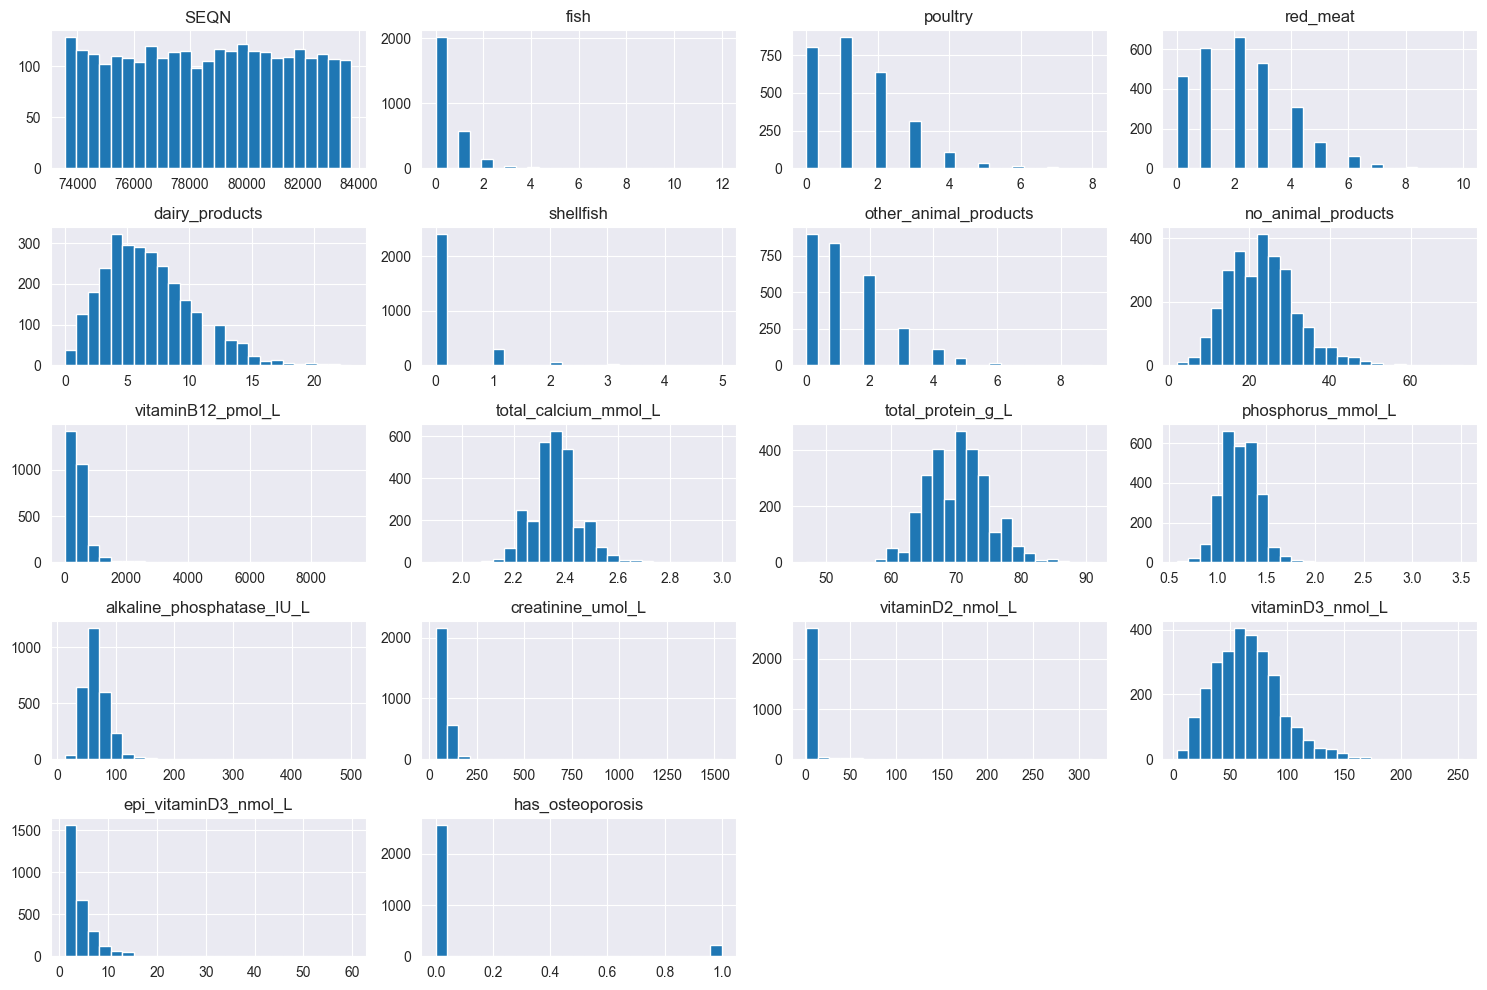

In [44]:
# Step 1: Visualizations
# Histograms
final_df.hist(bins=25, figsize=(15, 10))
plt.tight_layout()
plt.show()



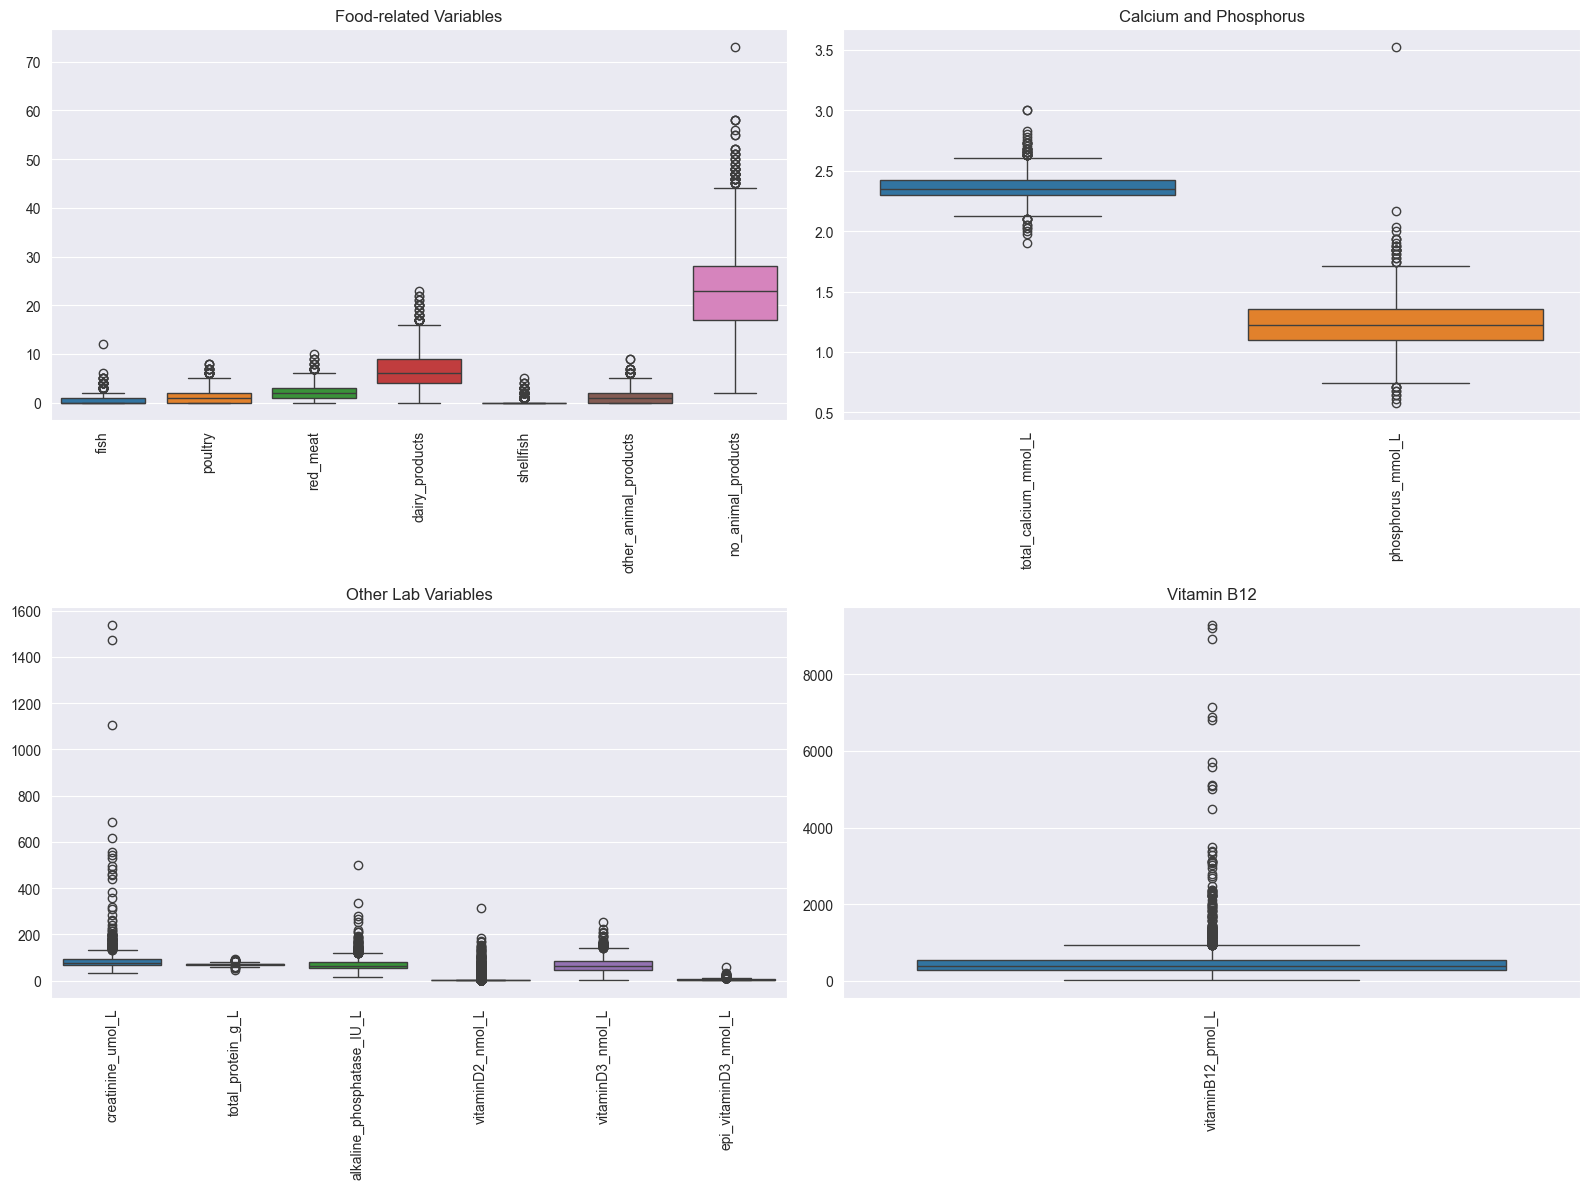

In [45]:
def show_boxplots(df):
    """
    Displays 4 subplots with boxplots of different groups of variables.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid of subplots

    # First subplot: Food-related variables
    sns.boxplot(
        data=df[["fish", "poultry", "red_meat", "dairy_products", "shellfish", "other_animal_products", "no_animal_products"]].select_dtypes(include=[np.number]), 
        ax=axes[0, 0]
    )
    axes[0, 0].set_title("Food-related Variables")
    axes[0, 0].tick_params(axis='x', rotation=90)

    # Second subplot: Calcium and Phosphorus
    sns.boxplot(
        data=df[["total_calcium_mmol_L", "phosphorus_mmol_L"]].select_dtypes(include=[np.number]), 
        ax=axes[0, 1]
    )
    axes[0, 1].set_title("Calcium and Phosphorus")
    axes[0, 1].tick_params(axis='x', rotation=90)

    # Third subplot: Other lab variables
    sns.boxplot(
        data=df[["creatinine_umol_L", "total_protein_g_L", "alkaline_phosphatase_IU_L", "vitaminD2_nmol_L", "vitaminD3_nmol_L", "epi_vitaminD3_nmol_L"]].select_dtypes(include=[np.number]), 
        ax=axes[1, 0]
    )
    axes[1, 0].set_title("Other Lab Variables")
    axes[1, 0].tick_params(axis='x', rotation=90)

    # Fourth subplot: Vitamin B12
    sns.boxplot(
        data=df[["vitaminB12_pmol_L"]].select_dtypes(include=[np.number]), 
        ax=axes[1, 1]
    )
    axes[1, 1].set_title("Vitamin B12")
    axes[1, 1].tick_params(axis='x', rotation=90)

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

# Example usage
show_boxplots(final_df)

### outlier handling
So let's evaluate what we do with the outliers. Let's evaluate this for each sub boxplot separately.

- Food related Variables (top left)
    - For fish and no-animal products, there is one outlier that has 10 more products eaten compared to the rest. Therefore, for that instance, we set the variable manually to one more food item compared to the second highest.  
- Calcium and phosphorus (Top right)
    - For phosphorus and calcium there is one extreme outlier, much higher than other observations. 
        - For calcium we set the highest one, we lower the value to the second highest one and set it 0.05 higher compared to that one
        -  The highest score phosphorus observation. Is lowered to the second highest observation and we set this value 0.1 higher
- Other lab values (Bottem left)
    - creatine levels
        - There are only 3 outliers. We decrease the 3 highest observations by 40%. This will result in the observations to still be the highest but less extreme. 
    - Alkaline 
        - There is only 1 extreme outlier. We decrease the highest value by 20%, so that it is still the highest but less extreme
    - VitaminD2
        - There is only 1 extreme outlier. We decrease the highest value by 25%, so that it is still the highest but less extreme
- Vitamine B12 
    - We do not change any outliers here because the outliers seem to be distributed proportionally

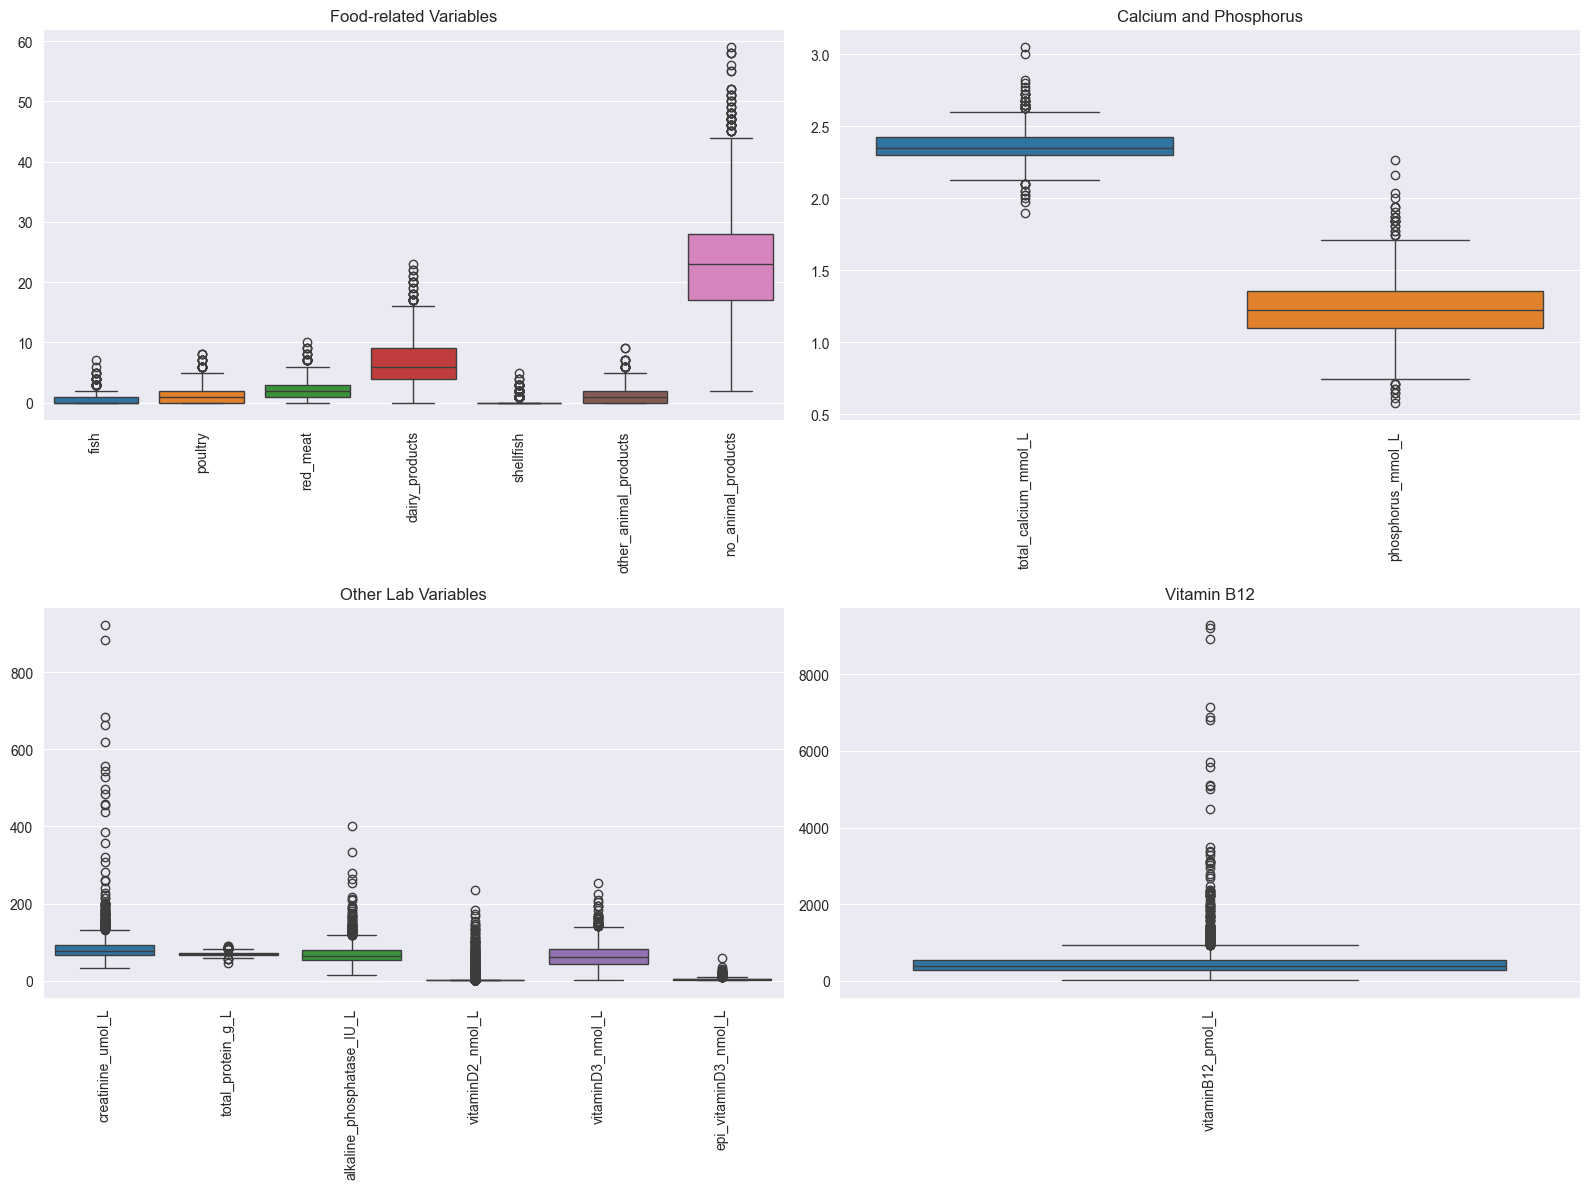

In [46]:
def handle_outliers(df):
    """
    Adjust outliers based on the specified rules for each group of variables.
    
    Parameters:
    - df: DataFrame containing the data
    
    Returns:
    - DataFrame with adjusted outliers
    """
    df = df.copy()
    
    # Food-related variables (top left)
    for col in ["fish", "no_animal_products"]:
        if col in df.columns:
            second_highest = df[col].nlargest(2).iloc[1]
            highest_idx = df[col].idxmax()
            df.loc[highest_idx, col] = second_highest + 1

    # Calcium and phosphorus (top right)
    if "total_calcium_mmol_L" in df.columns:
        second_highest_calcium = df["total_calcium_mmol_L"].nlargest(2).iloc[1]
        highest_calcium_idx = df["total_calcium_mmol_L"].idxmax()
        df.loc[highest_calcium_idx, "total_calcium_mmol_L"] = second_highest_calcium + 0.05

    if "phosphorus_mmol_L" in df.columns:
        second_highest_phosphorus = df["phosphorus_mmol_L"].nlargest(2).iloc[1]
        highest_phosphorus_idx = df["phosphorus_mmol_L"].idxmax()
        df.loc[highest_phosphorus_idx, "phosphorus_mmol_L"] = second_highest_phosphorus + 0.1

    # Other lab values (bottom left)
    if "creatinine_umol_L" in df.columns:
        highest_creatinine_indices = df["creatinine_umol_L"].nlargest(3).index
        df.loc[highest_creatinine_indices, "creatinine_umol_L"] *= 0.6  # Reduce top 3 by 40%
    
    if "alkaline_phosphatase_IU_L" in df.columns:
        highest_alkaline_idx = df["alkaline_phosphatase_IU_L"].idxmax()
        df.loc[highest_alkaline_idx, "alkaline_phosphatase_IU_L"] *= 0.8  # Reduce by 20%

    if "vitaminD2_nmol_L" in df.columns:
        highest_vitaminD2_idx = df["vitaminD2_nmol_L"].idxmax()
        df.loc[highest_vitaminD2_idx, "vitaminD2_nmol_L"] *= 0.75  # Reduce by 25%

    # Vitamin B12 (bottom right)
    # No adjustments for Vitamin B12 as outliers are proportionally distributed
    
    return df

# Example usage
adjusted_df = handle_outliers(final_df)
show_boxplots(adjusted_df)

As can be seen from the 4 plots above, there are no extreme outliers left in the data

### Identifying vegans

We intended to also include the variable if someone is vegan, meaning they eat no animal related products. however, all participants who do not eat meat, do eat dairy_products. So we cannot include the vegan variable.

In [47]:
adjusted_df[(adjusted_df["red_meat"] == 0 ) &
            (adjusted_df["fish"] == 0 ) &
            (adjusted_df["shellfish"] == 0 ) &
            (adjusted_df["poultry"] == 0 ) &

            (adjusted_df["dairy_products"] == 0 )

]

Empty DataFrame
Columns: [SEQN, fish, poultry, red_meat, dairy_products, shellfish, other_animal_products, no_animal_products, vitaminB12_pmol_L, total_calcium_mmol_L, total_protein_g_L, phosphorus_mmol_L, alkaline_phosphatase_IU_L, creatinine_umol_L, vitaminD2_nmol_L, vitaminD3_nmol_L, epi_vitaminD3_nmol_L, has_osteoporosis]
Index: []

## Creating eater type dummies

There are no vegans in our dataset. As we can see from the the empty table above

## Creating dummies 
Let's create dummy variables whether someone is vegetarian or Pescatarian. We do not need to create the omnivore label because that information is already in the data when someone is not Pescatarian or vegetarian. 

In [48]:
def assign_eater_type(df):
    def assign_meat_eater_type_row(row):
        if (row["fish"] > 0 or row["shellfish"] > 0) and row["red_meat"] == 0 and row["poultry"] == 0:
            return "Pescatarian"
        elif row["red_meat"] == 0 and row["poultry"] == 0 and row["fish"] == 0 and row["shellfish"] == 0 and (row["dairy_products"] > 0 or row["other_animal_products"] > 0):
            return "Vegetarian"
        else:
            return "Omnivore"


    

    df["meat_eater_type"] = df.apply(assign_meat_eater_type_row, axis=1)
    # Create one-hot encoded columns while keeping the original "meat_eater_type" column
    one_hot_encoded = pd.get_dummies(df["meat_eater_type"], prefix="type", dtype=float)
    df = pd.concat([df, one_hot_encoded], axis=1).drop(columns="type_Omnivore")
    #df = pd.get_dummies(df, columns=["meat_eater_type"], prefix="type", dtype=float)
    return df
adjusted_df = assign_eater_type(adjusted_df)
adjusted_df.head()

SEQN  fish  poultry  red_meat  dairy_products  shellfish  \
0  73557.0   0.0      2.0       4.0             3.0        0.0   
1  73558.0   1.0      2.0       1.0             7.0        2.0   
2  73559.0   1.0      0.0       1.0             9.0        0.0   
3  73561.0   0.0      0.0       0.0             9.0        0.0   
4  73564.0   1.0      1.0       0.0             8.0        0.0   

   other_animal_products  no_animal_products  vitaminB12_pmol_L  \
0                    5.0                18.0              386.7   
1                    0.0                 6.0              374.2   
2                    2.0                34.0              540.2   
3                    0.0                 6.0              166.1   
4                    1.0                28.0              493.0   

   total_calcium_mmol_L  ...  phosphorus_mmol_L  alkaline_phosphatase_IU_L  \
0                 2.375  ...              1.388                      129.0   
1                 2.300  ...              1.259                       97.0   
2                 2.225  ...              1.356                       99.0   
3                 2.500  ...              1.421                       78.0   
4                 2.475  ...              1.162                       72.0   

   creatinine_umol_L  vitaminD2_nmol_L  vitaminD3_nmol_L  \
0             106.96              1.45              27.5   
1              69.84              1.45              60.4   
2             107.85              1.45             125.0   
3              64.53              1.45             107.0   
4              81.33              1.45             101.0   

   epi_vitaminD3_nmol_L  has_osteoporosis  meat_eater_type type_Pescatarian  \
0                  1.16               0.0         Omnivore              0.0   
1                  2.24               0.0         Omnivore              0.0   
2                 14.70               1.0         Omnivore              0.0   
3                  5.26               0.0       Vegetarian              0.0   
4                  4.72               0.0         Omnivore              0.0   

   type_Vegetarian  
0              0.0  
1              0.0  
2              0.0  
3              1.0  
4              0.0  

[5 rows x 21 columns]

# Advanced visualizations 

let us create a correlation heatmap and pairplots below. These visualizations will help us to understand the data

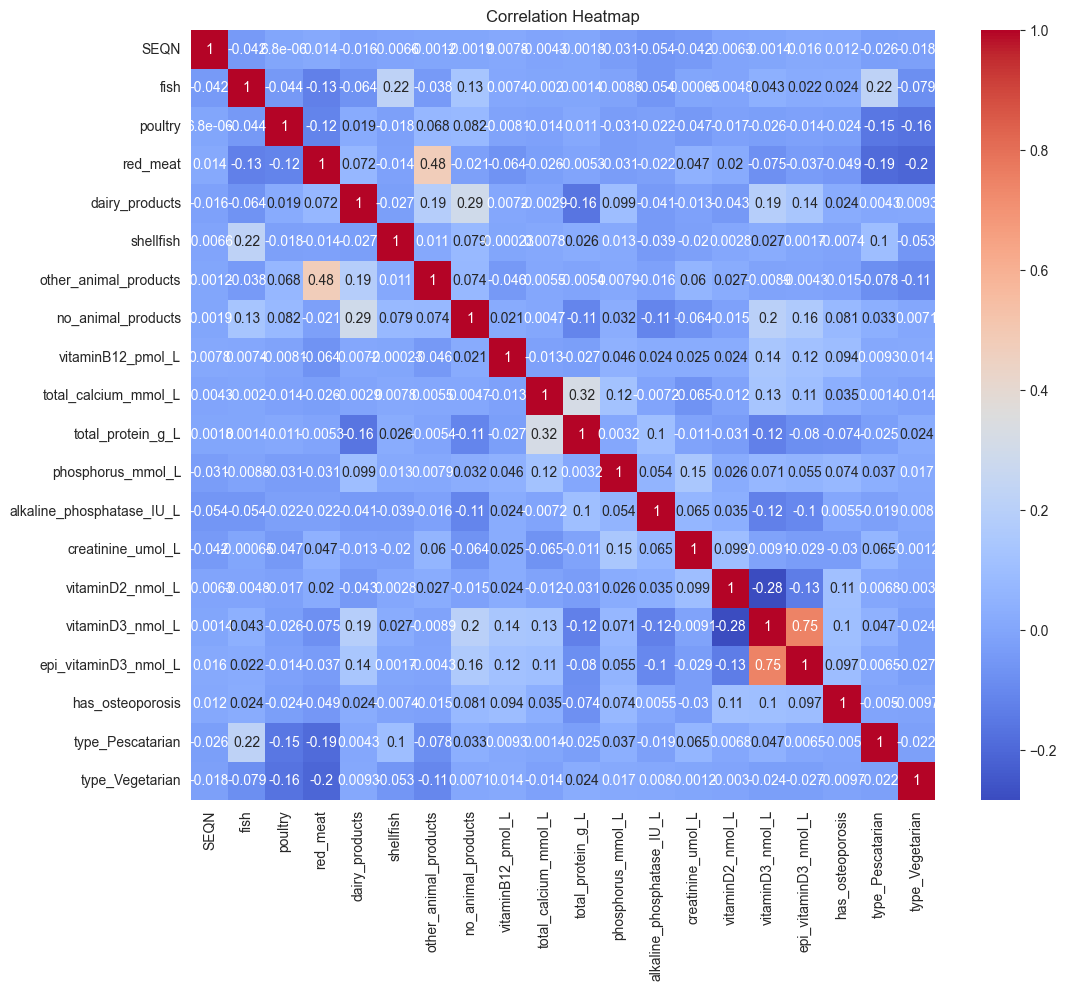

In [49]:
def create_correlation_heatmap(df):
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.drop("meat_eater_type", axis=1).corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()
    
create_correlation_heatmap(adjusted_df)

### Interpretation correlation heatmap
From the correlation heatmap, we can observe several interesting patterns. For instance, there are notable correlations among the variables we created using the LLM. Among the meat-related components, red meat shows a correlation with osteoporosis. Additionally, while being vegetarian is not strongly related to osteoporosis, there is a slight association. Osteoporosis, however, is strongly linked to vitamin D levels and the total protein in an individual’s blood.

Vitamin B12 levels also show a significant correlation with osteoporosis. Interestingly, the vegetarian type is closely related to the protein levels in an individual’s blood, and protein itself has a strong relationship with osteoporosis. This insight is particularly intriguing. Although the correlation values are relatively small, this is expected because the likelihood of having osteoporosis in the dataset is low. Nevertheless, these observations shed light on the complex relationships among these variables, helping us better understand the underlying factors contributing to osteoporosis.

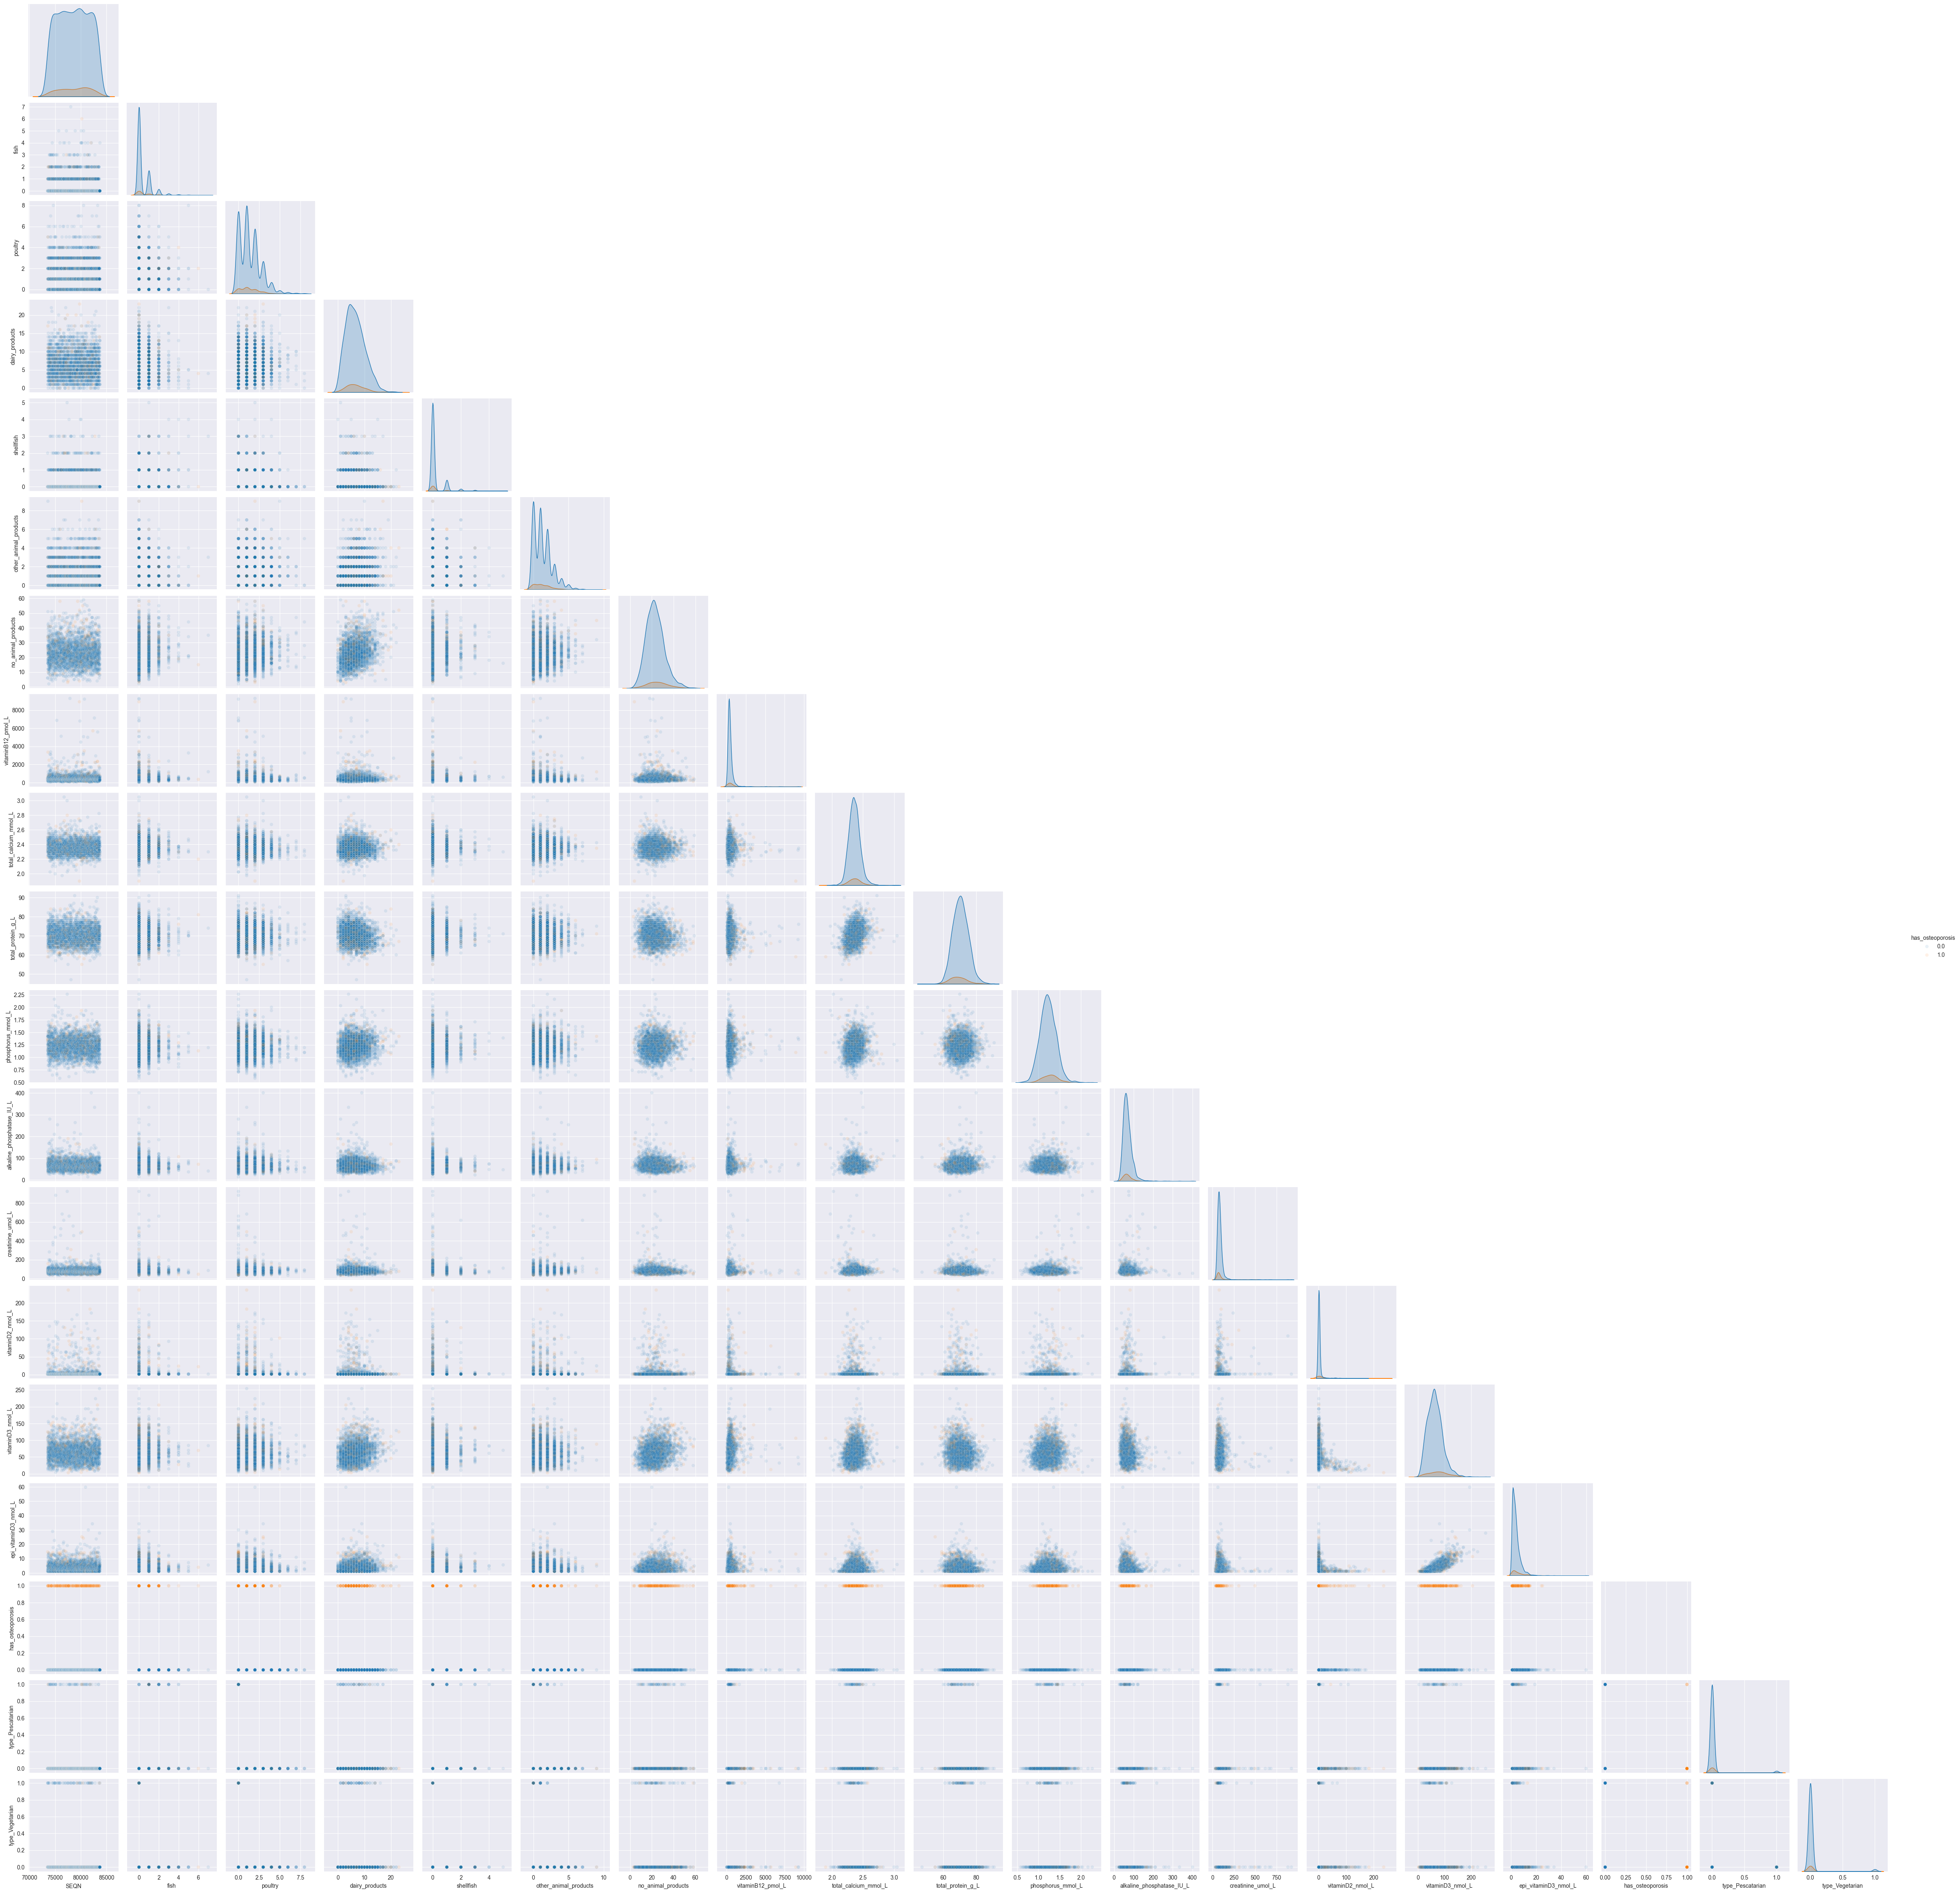

In [50]:
def create_pairplots(df):
   # Select variables based on heatmap insights and hypothesis
    variables = ["dairy_products", "poultry", "red_meat", 
                 "total_calcium_mmol_L", "vitaminB12_pmol_L", 
                 "total_protein_g_L", "has_osteoporosis"]
   
   
    variables = [col for col in df.columns if "meat" not in col]

    # Pair plots with hue based on meat_eater_type
    sns.pairplot(df, vars=variables, hue="has_osteoporosis", diag_kind="kde", corner=True, plot_kws={"alpha": 0.1})
    plt.show()

create_pairplots(adjusted_df)

## Interpretation pairplot
The pair plot reveals some noticeable patterns, but it is challenging to draw definitive conclusions about the relationship between osteoporosis and the variables. For instance, there are apparent differences in total protein intake and dietary consumption across different groups, particularly when comparing individuals with and without osteoporosis. While these differences in distributions are visible, they are subtle and not easily interpretable directly from the pair plot.

Additionally, the disparity in sample sizes between individuals with and without osteoporosis may contribute to these observations. Since there are significantly fewer individuals with osteoporosis in the dataset, this imbalance might obscure some patterns. To gain more meaningful insights, further analysis is required. A predictive model could potentially help identify and quantify the factors that are most strongly associated with osteoporosis.

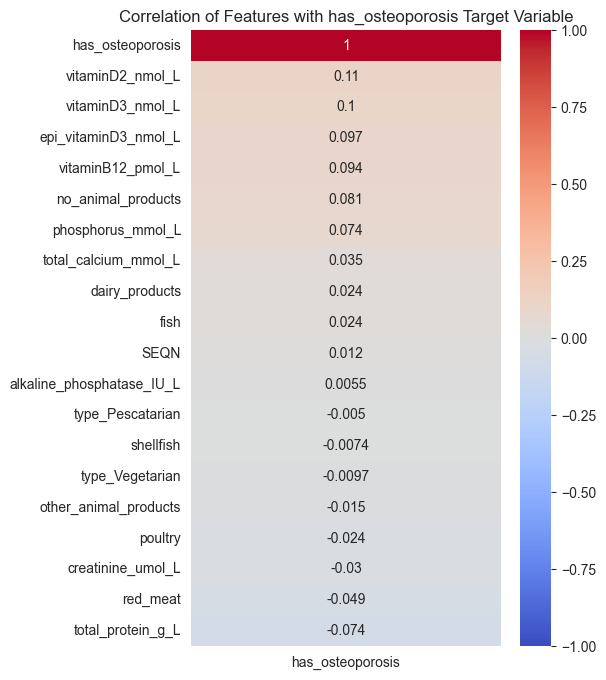

In [51]:
plt.figure(figsize=(5, 8))
sns.heatmap(adjusted_df.drop("meat_eater_type", axis=1).corr()[['has_osteoporosis']].sort_values(by='has_osteoporosis', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with has_osteoporosis Target Variable')
plt.show()

Interpretation heatmap with has_osteoporosis. We can see several variables being correlated with osteoporosis. However, what does not make sense, is that VitaminD2, VitaminD3, Vitamin B12 are positively correlated with osteoporosis. Which means that people who have more of these vitamins have a higher change to have osteoporosis. Actually what might be happening is that people who have osteoporosis consume supplement vitamins because they want to have more of these vitamins because they aid in bone strength. 

## Univariate & Multivariate Analysis
 As we can see from the multivariate and univariate analysis, we have very different scales of our data set. So it will be very useful, especially for the most simple models like linear regression, and we're going to perform later, to scale the variables into standardized format. Standard scaling or min-max scaling.

In [52]:
# Step 4: 
# Example: Central tendency and dispersion
print(adjusted_df.describe())


               SEQN         fish      poultry     red_meat  dairy_products  \
count   2792.000000  2792.000000  2792.000000  2792.000000     2792.000000   
mean   78614.282235     0.378582     1.371777     2.147564        6.569126   
std     2941.312150     0.731842     1.268658     1.608291        3.650567   
min    73557.000000     0.000000     0.000000     0.000000        0.000000   
25%    76096.500000     0.000000     0.000000     1.000000        4.000000   
50%    78680.500000     0.000000     1.000000     2.000000        6.000000   
75%    81157.000000     1.000000     2.000000     3.000000        9.000000   
max    83729.000000     7.000000     8.000000    10.000000       23.000000   

         shellfish  other_animal_products  no_animal_products  \
count  2792.000000            2792.000000         2792.000000   
mean      0.176218               1.319484           23.283309   
std       0.502698               1.306629            8.503017   
min       0.000000               0.00

## Scaling

Scale the variables with minmax scaler

In [53]:
numerical_features = ['fish', 'poultry', 'red_meat', 'dairy_products', 'shellfish',
       'other_animal_products', 'no_animal_products',
       'type_Pescatarian', 'type_Vegetarian']

log_features = ['vitaminB12_pmol_L',
       'total_calcium_mmol_L', 'total_protein_g_L', 'phosphorus_mmol_L',
       'alkaline_phosphatase_IU_L', 'creatinine_umol_L', 'vitaminD2_nmol_L',
       'vitaminD3_nmol_L', 'epi_vitaminD3_nmol_L']

# Initialise the scaler
scaler = MinMaxScaler()
#scaler = StandardScaler()



# Apply the scaler to the numerical features
df_normalized = adjusted_df.drop(["meat_eater_type"], axis=1)
df_normalized[log_features] = df_normalized[log_features].apply(lambda x: np.log1p(x))

# Apply the scaler to the numerical features that were not log-transformed
df_normalized[numerical_features] = scaler.fit_transform(df_normalized[numerical_features])
df_normalized.head()

SEQN      fish  poultry  red_meat  dairy_products  shellfish  \
0  73557.0  0.000000    0.250       0.4        0.130435        0.0   
1  73558.0  0.142857    0.250       0.1        0.304348        0.4   
2  73559.0  0.142857    0.000       0.1        0.391304        0.0   
3  73561.0  0.000000    0.000       0.0        0.391304        0.0   
4  73564.0  0.142857    0.125       0.0        0.347826        0.0   

   other_animal_products  no_animal_products  vitaminB12_pmol_L  \
0               0.555556            0.280702           5.960232   
1               0.000000            0.070175           5.927459   
2               0.222222            0.561404           6.293789   
3               0.000000            0.070175           5.118592   
4               0.111111            0.456140           6.202536   

   total_calcium_mmol_L  total_protein_g_L  phosphorus_mmol_L  \
0              1.216395           4.189655           0.870456   
1              1.193922           4.369448           0.814922   
2              1.170933           4.094345           0.856965   
3              1.252763           4.276666           0.884181   
4              1.245594           4.174387           0.771034   

   alkaline_phosphatase_IU_L  creatinine_umol_L  vitaminD2_nmol_L  \
0                   4.867534           4.681761          0.896088   
1                   4.584967           4.260424          0.896088   
2                   4.605170           4.689971          0.896088   
3                   4.369448           4.182508          0.896088   
4                   4.290459           4.410736          0.896088   

   vitaminD3_nmol_L  epi_vitaminD3_nmol_L  has_osteoporosis  type_Pescatarian  \
0          3.349904              0.770108               0.0               0.0   
1          4.117410              1.175573               0.0               0.0   
2          4.836282              2.753661               1.0               0.0   
3          4.682131              1.834180               0.0               0.0   
4          4.624973              1.743969               0.0               0.0   

   type_Vegetarian  
0              0.0  
1              0.0  
2              0.0  
3              1.0  
4              0.0

##  Clustering and Association rules mining

### K-Means Clustering

In the context of k-means, inertia is the sum of squared distances of samples to their closest cluster center (also known as centroid).

We can use the inertia values to determine the optimal number of clusters by identifying the elbow point in the inertia plot. The elbow point represents the optimal number of clusters where the inertia starts to decrease at a slower rate.

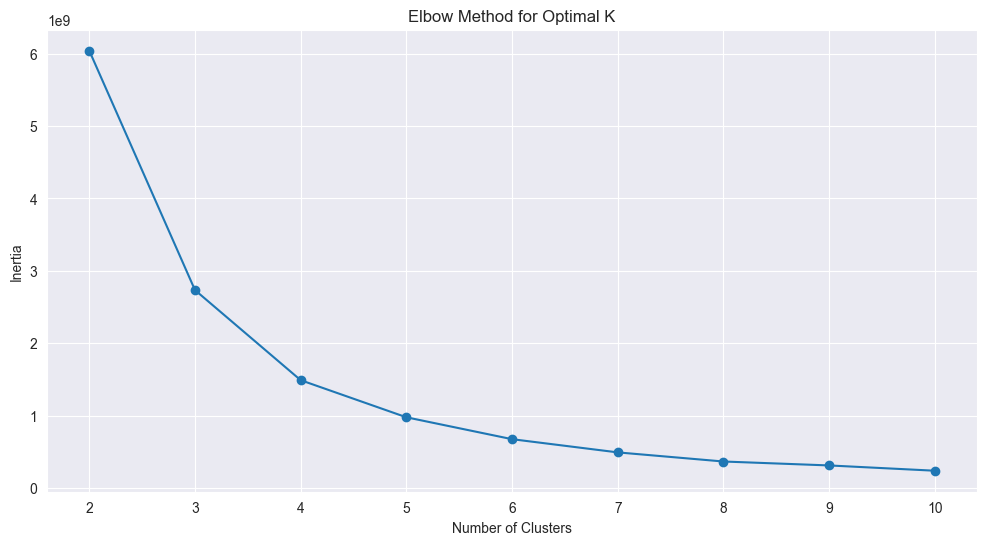

In [54]:
def compute_inertia_values(dataframe, cluster_range):
    inertias = []
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(dataframe)
        inertias.append(kmeans.inertia_)
    return inertias

def plot_elbow_method(cluster_range, inertias):
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.show()


#df_cluster = df_cluster.drop(columns=['has_osteoporosis'])
df_cluster = df_normalized.copy()

cluster_range = range(2, 11)
km_inertia = compute_inertia_values(df_cluster, cluster_range)   
plot_elbow_method(cluster_range, km_inertia)

### Interpretation elbow plot K-means

As you can see, in the figure "Elbow Method Optimal K", we can see the biggest gain in inertia decrease when number of clusters is at 4. Therefore we will take k equal to 4 will, as this would create the best clusters with k-means algorithm.

In [55]:
def kmeans_clustering(dataframe, n):
    
    kmeans_arr = []
    silhouette_arr = []
    for n in list(range(2, n+1)):
        kmeans = KMeans(n_clusters=n, random_state = 0)
        km_clusters = kmeans.fit_predict(dataframe)
        kmeans_arr.append(km_clusters)
        silhouette_arr.append(silhouette_score(dataframe, km_clusters))
    
    # Adding the k-means cluster labels to the dataframe
    dataframe['kmeans_cluster'] = kmeans_arr[-1]

    return dataframe, kmeans_arr, silhouette_arr

km_df, km_results, sil_scores = kmeans_clustering(df_cluster, 4)
print("Silhouette Scores", [float(num) for num in sil_scores], "\n")
km_df.head(10)

Silhouette Scores [0.6277018008798172, 0.5862468567348434, 0.5786512752412415] 



SEQN      fish  poultry  red_meat  dairy_products  shellfish  \
0   73557.0  0.000000    0.250       0.4        0.130435        0.0   
1   73558.0  0.142857    0.250       0.1        0.304348        0.4   
2   73559.0  0.142857    0.000       0.1        0.391304        0.0   
3   73561.0  0.000000    0.000       0.0        0.391304        0.0   
4   73564.0  0.142857    0.125       0.0        0.347826        0.0   
5   73571.0  0.000000    0.000       0.3        0.173913        0.0   
6   73581.0  0.000000    0.000       0.0        0.347826        0.0   
7   73595.0  0.000000    0.375       0.4        0.173913        0.0   
8   73596.0  0.000000    0.000       0.0        0.478261        0.0   
10  73604.0  0.142857    0.125       0.1        0.739130        0.0   

    other_animal_products  no_animal_products  vitaminB12_pmol_L  \
0                0.555556            0.280702           5.960232   
1                0.000000            0.070175           5.927459   
2                0.222222            0.561404           6.293789   
3                0.000000            0.070175           5.118592   
4                0.111111            0.456140           6.202536   
5                0.333333            0.438596           5.742041   
6                0.000000            0.421053           5.560682   
7                0.111111            0.438596           5.879135   
8                0.111111            0.403509           5.997695   
10               0.111111            0.421053           5.490177   

    total_calcium_mmol_L  ...  phosphorus_mmol_L  alkaline_phosphatase_IU_L  \
0               1.216395  ...           0.870456                   4.867534   
1               1.193922  ...           0.814922                   4.584967   
2               1.170933  ...           0.856965                   4.605170   
3               1.252763  ...           0.884181                   4.369448   
4               1.245594  ...           0.771034                   4.290459   
5               1.201470  ...           0.884181                   4.158883   
6               1.193922  ...           0.756122                   4.110874   
7               1.193922  ...           0.884181                   3.784190   
8               1.201470  ...           0.756122                   4.276666   
10              1.223775  ...           0.843290                   4.394449   

    creatinine_umol_L  vitaminD2_nmol_L  vitaminD3_nmol_L  \
0            4.681761          0.896088          3.349904   
1            4.260424          0.896088          4.117410   
2            4.689971          0.896088          4.836282   
3            4.182508          0.896088          4.682131   
4            4.410736          0.896088          4.624973   
5            4.665324          0.896088          4.232656   
6            4.442416          2.132982          3.992681   
7            4.502916          0.896088          2.873565   
8            3.956423          0.896088          3.505557   
10           4.284965          0.896088          4.223910   

    epi_vitaminD3_nmol_L  has_osteoporosis  type_Pescatarian  type_Vegetarian  \
0               0.770108               0.0               0.0              0.0   
1               1.175573               0.0               0.0              0.0   
2               2.753661               1.0               0.0              0.0   
3               1.834180               0.0               0.0              1.0   
4               1.743969               0.0               0.0              0.0   
5               1.781709               0.0               0.0              0.0   
6               0.770108               0.0               0.0              1.0   
7               0.770108               0.0               0.0              0.0   
8               0.770108               0.0               0.0              1.0   
10              1.756132               1.0               0.0              0.0   

    kmeans_cluster  
0                3  


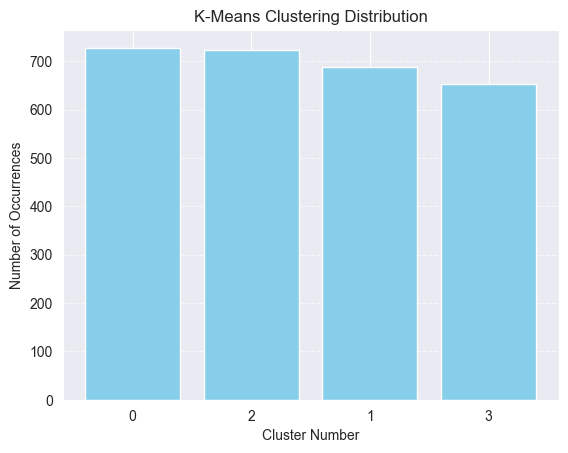

In [56]:
# Plotting K-Means clustering density plot
def plot_cluster_distribution(dataframe, column1, title1, xlab1):
    
    cluster_counts = dataframe[column1].value_counts()

    plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color='skyblue')
    plt.title(title1)
    plt.xlabel(xlab1)
    plt.ylabel('Number of Occurrences')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
plot_cluster_distribution(km_df, 'kmeans_cluster', 'K-Means Clustering Distribution', 'Cluster Number')

After analyzing the Silhouette scores, which were approximately 0.62 for the first cluster, 0.58 for the second, and 0.58 for the third, these scores indicate that our clusters are reasonably well-defined. Silhouette scores close to 1 suggest well-separated and cohesive clusters, while values closer to 0 indicate overlapping clusters. Therefore, a score around 0.6 suggests that the clustering is acceptable and provides meaningful groupings for our analysis. This level of clustering quality is sufficient for our purposes, as it indicates that the clusters are reasonably distinct while still capturing the underlying structure of the data.

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_38540/2305002295.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_38540/2305002295.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_38540/2305002295.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_38540/2305002295.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  s

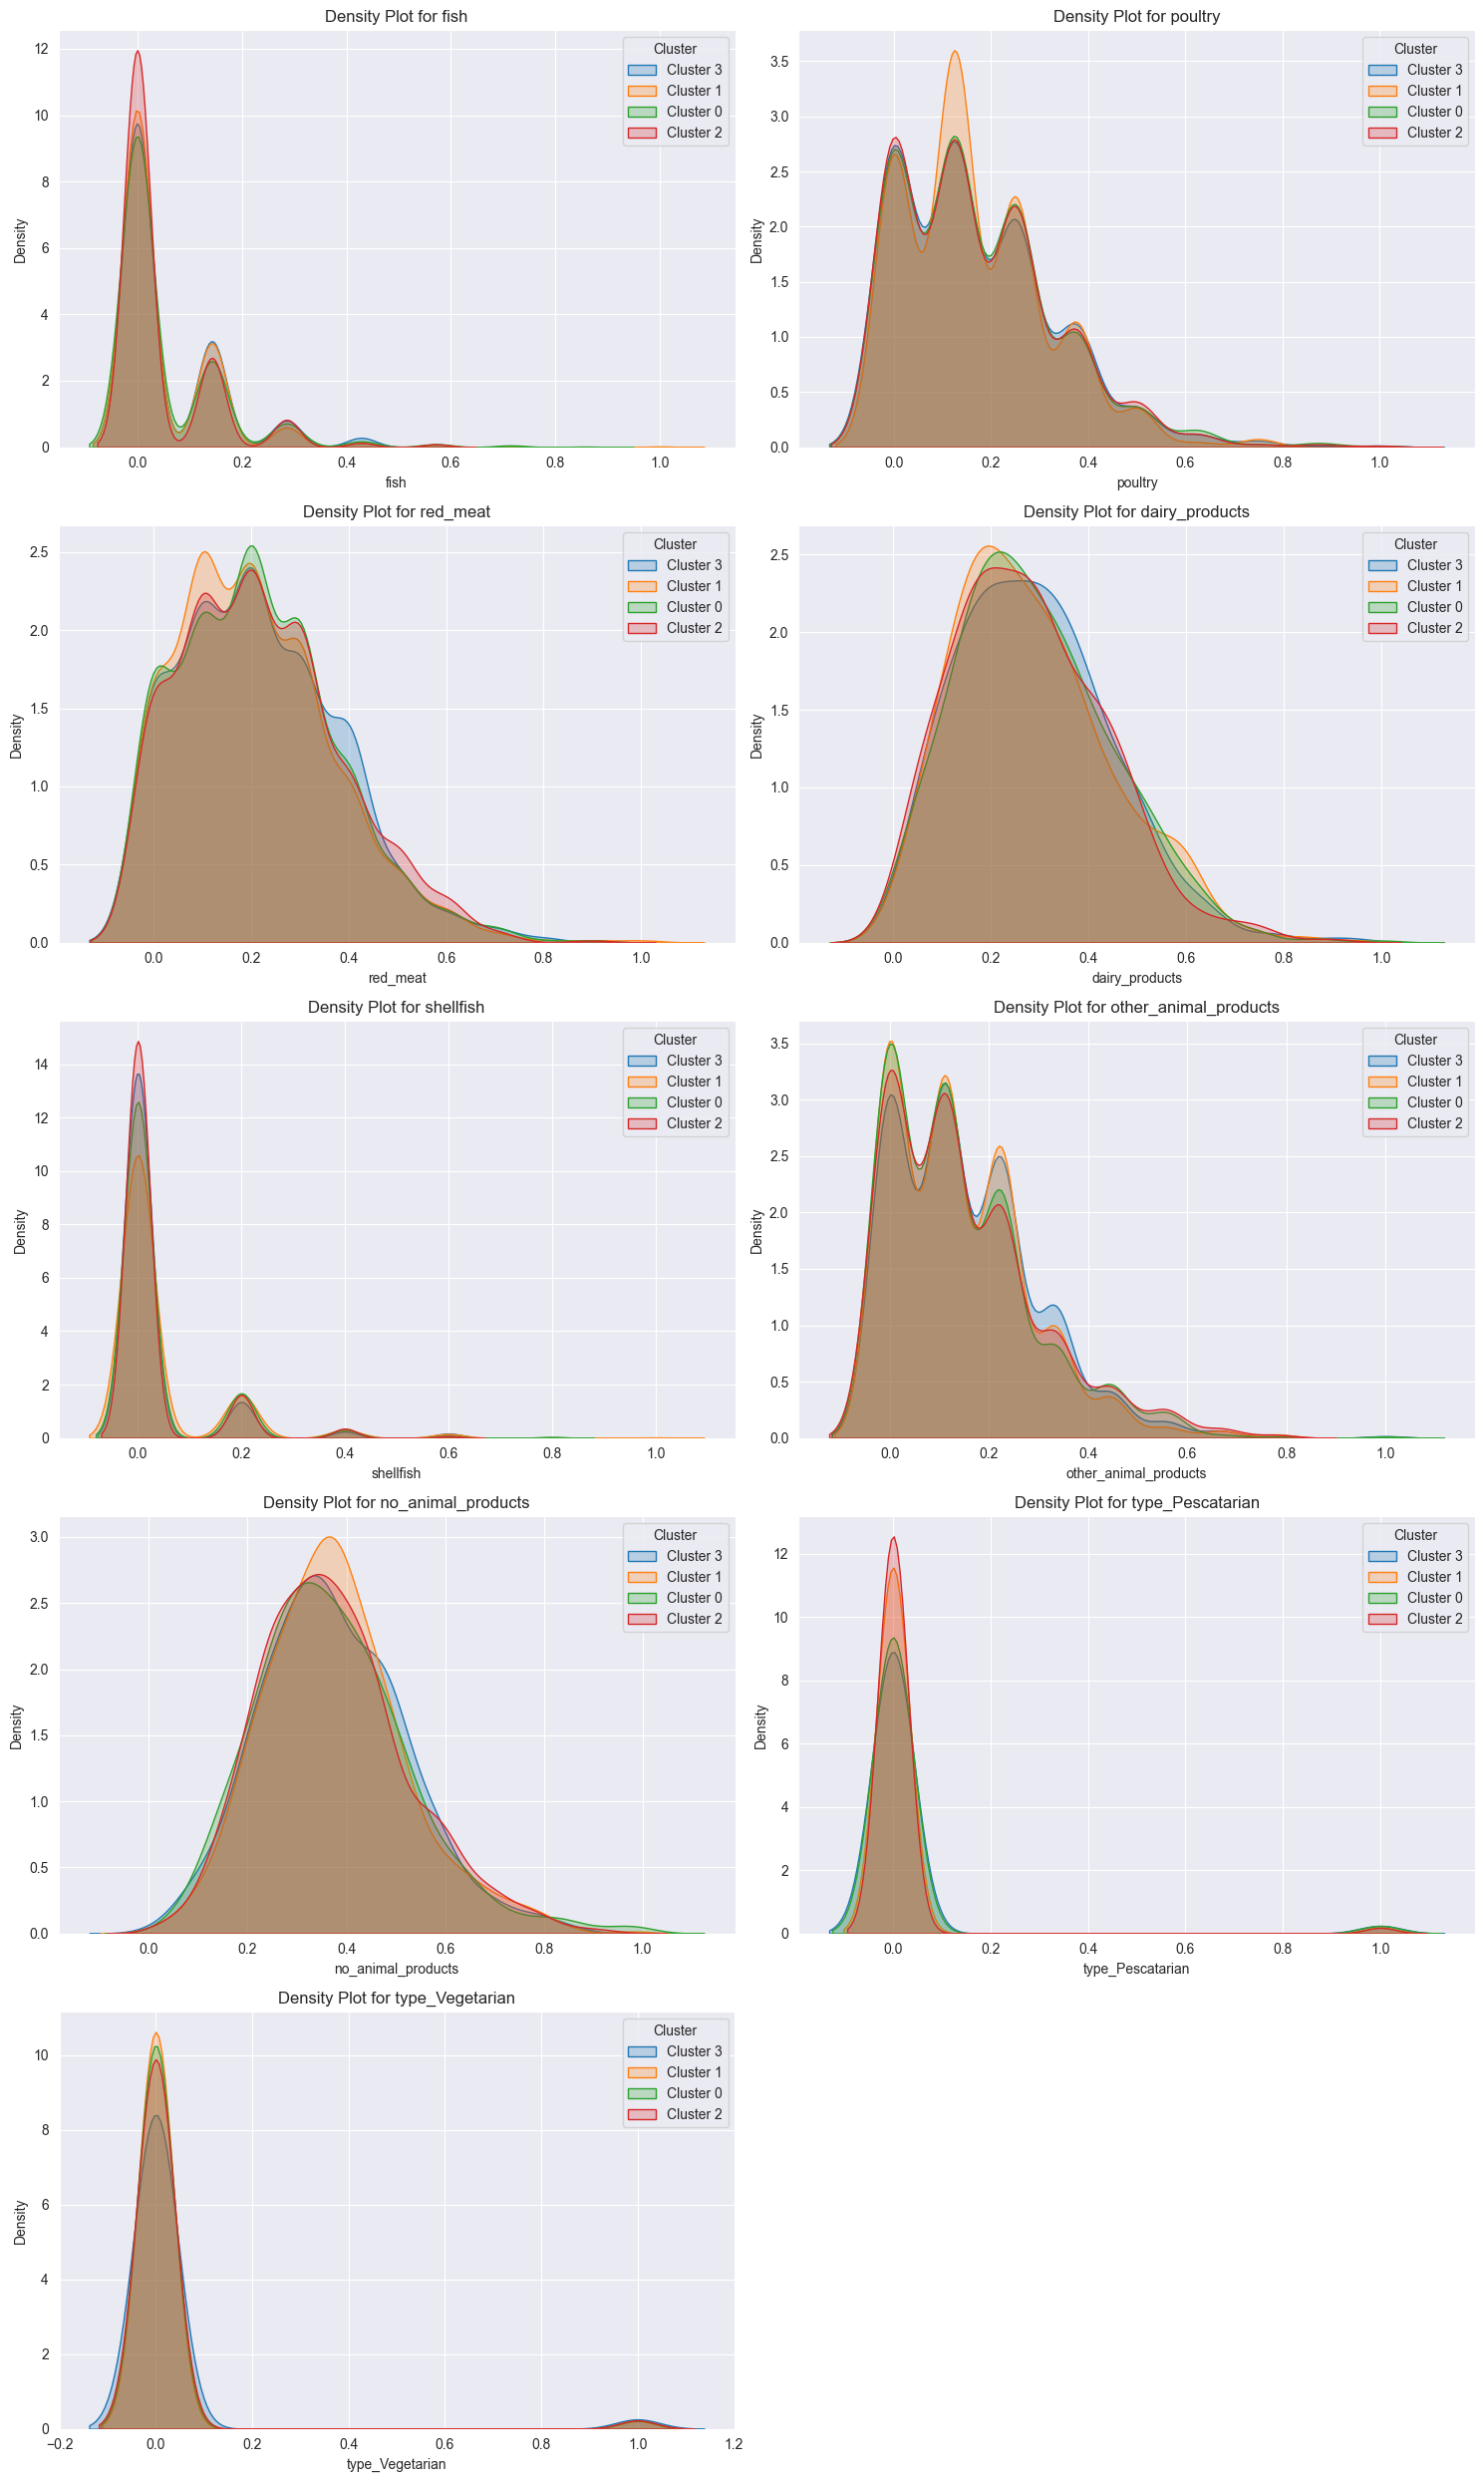

In [57]:
#Plot density plot for numerical features but with kmeans cluster color labels
def plot_kmeans_density_subplots(dataframe, cluster_column, numerical_features, num_cols=2):
    num_rows = -(-len(numerical_features) // num_cols)  # Ceiling division for rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for ax, col in zip(axes.flat, numerical_features):
        for cluster in dataframe[cluster_column].unique():
            sns.kdeplot(
                data=dataframe[dataframe[cluster_column] == cluster], 
                x=col, 
                label=f'Cluster {cluster}', 
                shade=True, 
                ax=ax
            )
        ax.set_title(f'Density Plot for {col}')
        ax.set_xlabel(col)
        ax.legend(title='Cluster')
    
    # Turn off unused subplots
    for ax in axes.flat[len(numerical_features):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_kmeans_density_subplots(km_df, 'kmeans_cluster', numerical_features)

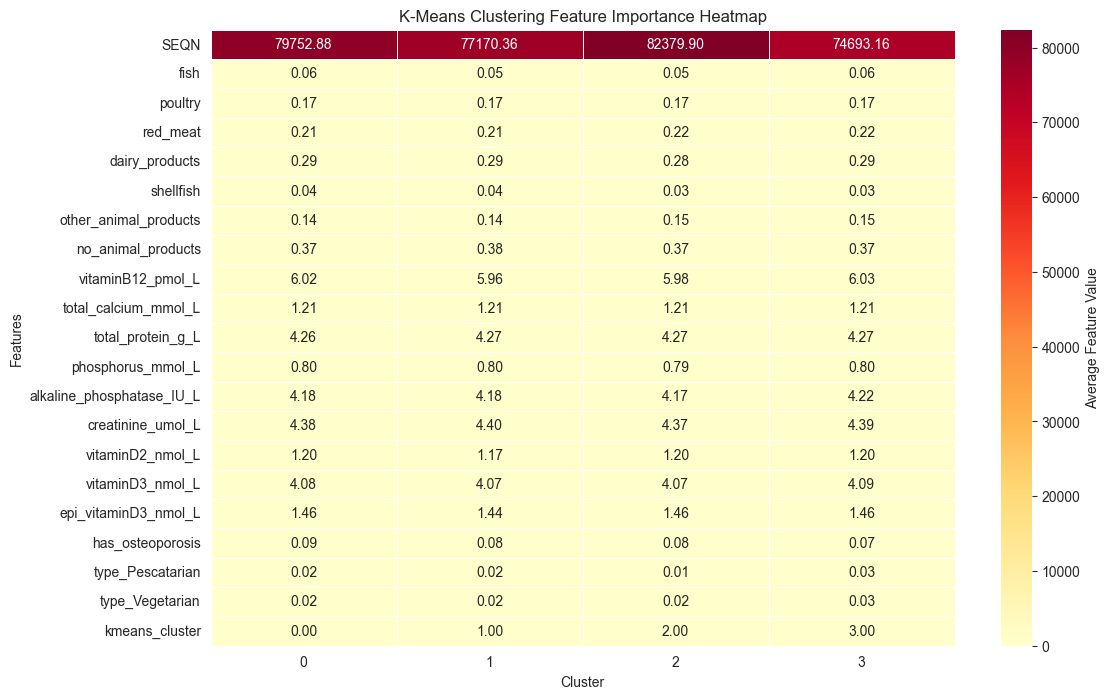

In [58]:
# Plotting a feature importance plot for the K-Means clustering
def plot_feature_importance(dataframe, labels, title):

    cluster_features = dataframe
    cluster_features['Cluster'] = labels
    cluster_means = cluster_features.groupby('Cluster').mean()


    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means.T, cmap='YlOrRd', annot=True, fmt='.2f',
                cbar_kws={'label': 'Average Feature Value'}, linewidths=0.5)
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel('Features')
    plt.xticks(rotation=0)
    plt.show()

plot_feature_importance(km_df, km_df['kmeans_cluster'], 'K-Means Clustering Feature Importance Heatmap')


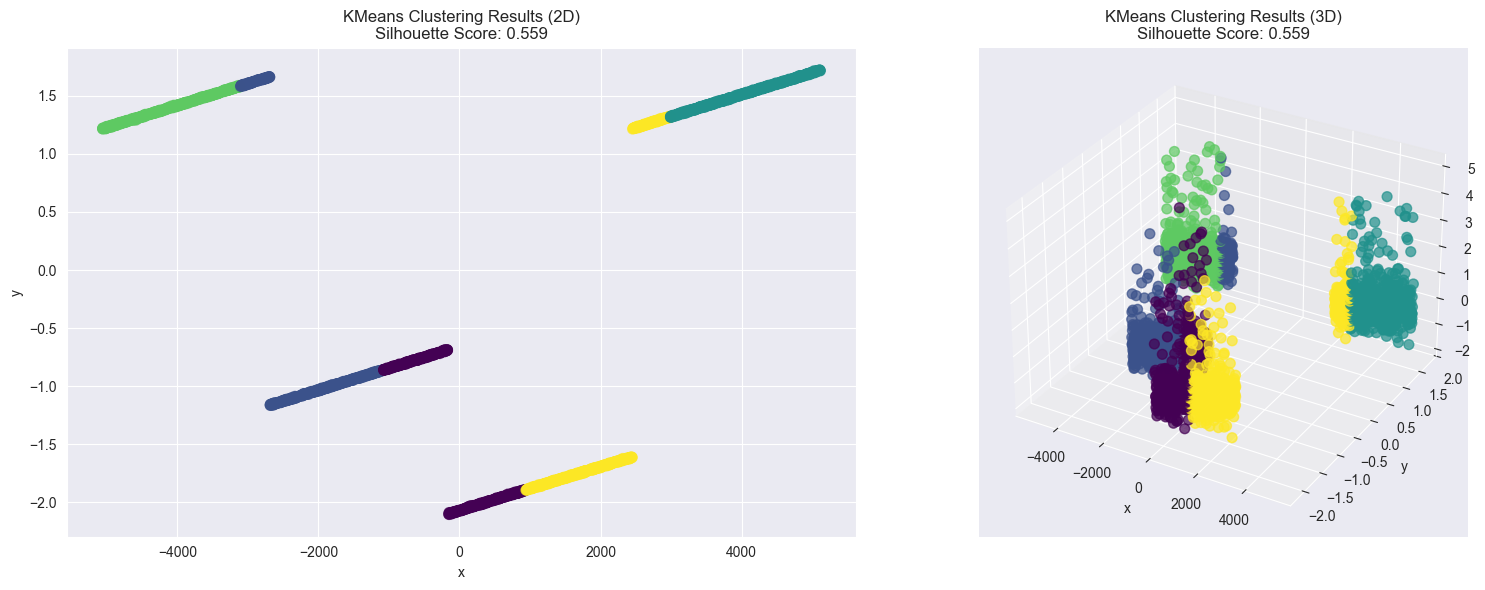

In [59]:
# Performing PCA for cluster visualization purposes
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_cluster)

def plot_kmeans(dataframe, optimal_k):

    fig = plt.figure(figsize=(24, 6))

    # Left plot: 2D Clustering Results
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    kmeans.fit(dataframe)
    kmeans_results = kmeans.predict(dataframe)
    silhouette_score_value = silhouette_score(dataframe, kmeans_results)

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(dataframe[:, 0], dataframe[:, 1], c=kmeans_results, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(f'KMeans Clustering Results (2D)\nSilhouette Score: {silhouette_score_value:.3f}')

    # Right plot: 3D Clustering Results
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.scatter(dataframe[:, 0], dataframe[:, 1], dataframe[:, 2], c=kmeans_results, cmap='viridis', s=50, alpha=0.7)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_title(f'KMeans Clustering Results (3D)\nSilhouette Score: {silhouette_score_value:.3f}')

    plt.tight_layout()
    plt.show()

# After looking at the elbow method, we pass the optimal number of clusters as a parameter
plot_kmeans(df_pca, 5)

### Interpretation of clustering

The clusters I created using k-means are not effective; they are nearly identical in their distributions and structure. Despite the apparent differences in distributions and patterns that are visible in the correlation maps and plots, the clustering algorithm failed to identify meaningful groups. This suggests that k-means might not be the best approach for this dataset, as it assumes clusters are spherical and equally sized, which might not align with the actual structure of the data. The lack of distinct clustering indicates that either the features used are not adequately distinguishing between groups, or that a different clustering method, such as hierarchical clustering, DBSCAN, or Gaussian Mixture Models, might be more appropriate for uncovering the inherent structure in the data. Further investigation and exploration of alternative clustering approaches are needed to resolve this issue.

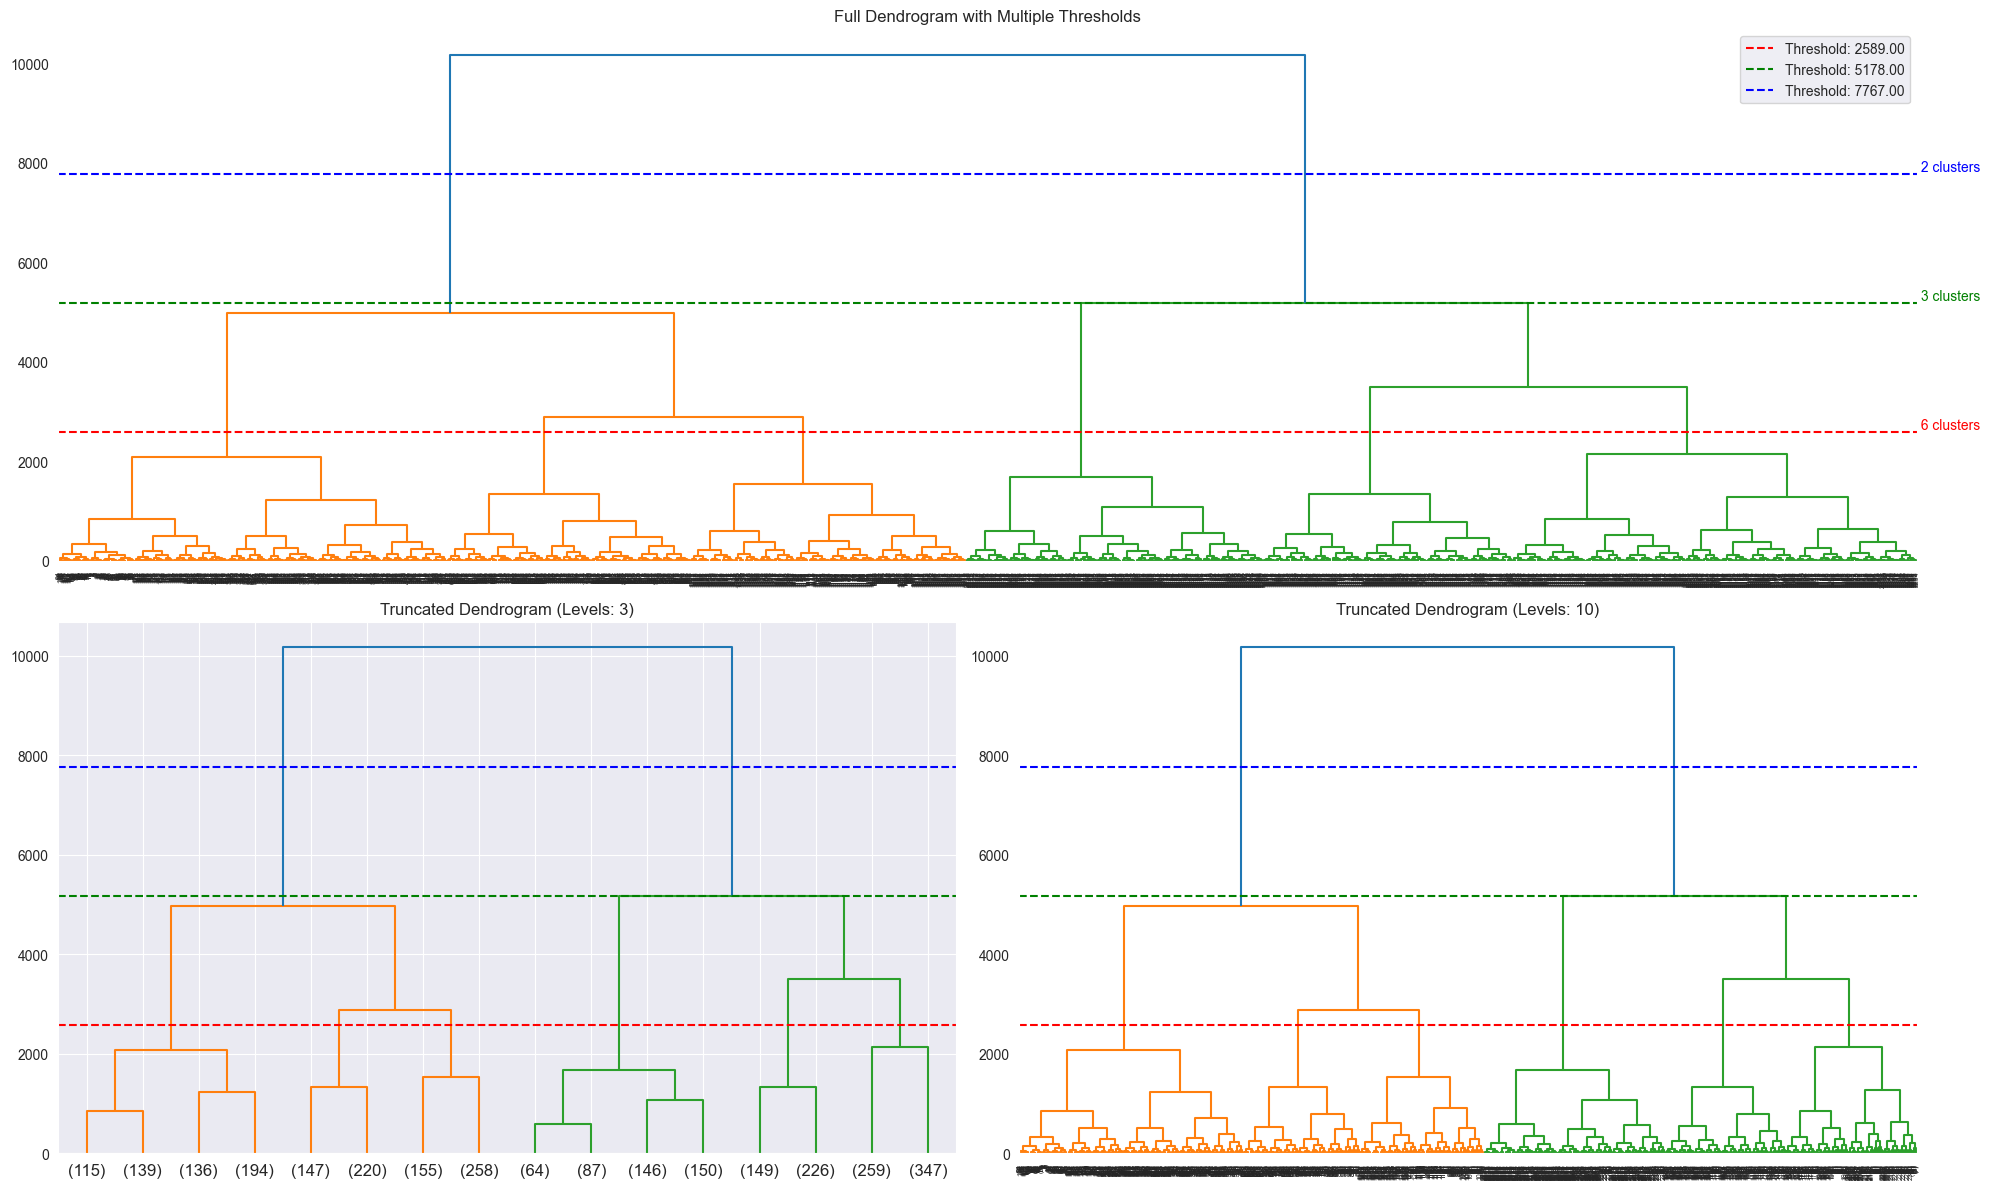

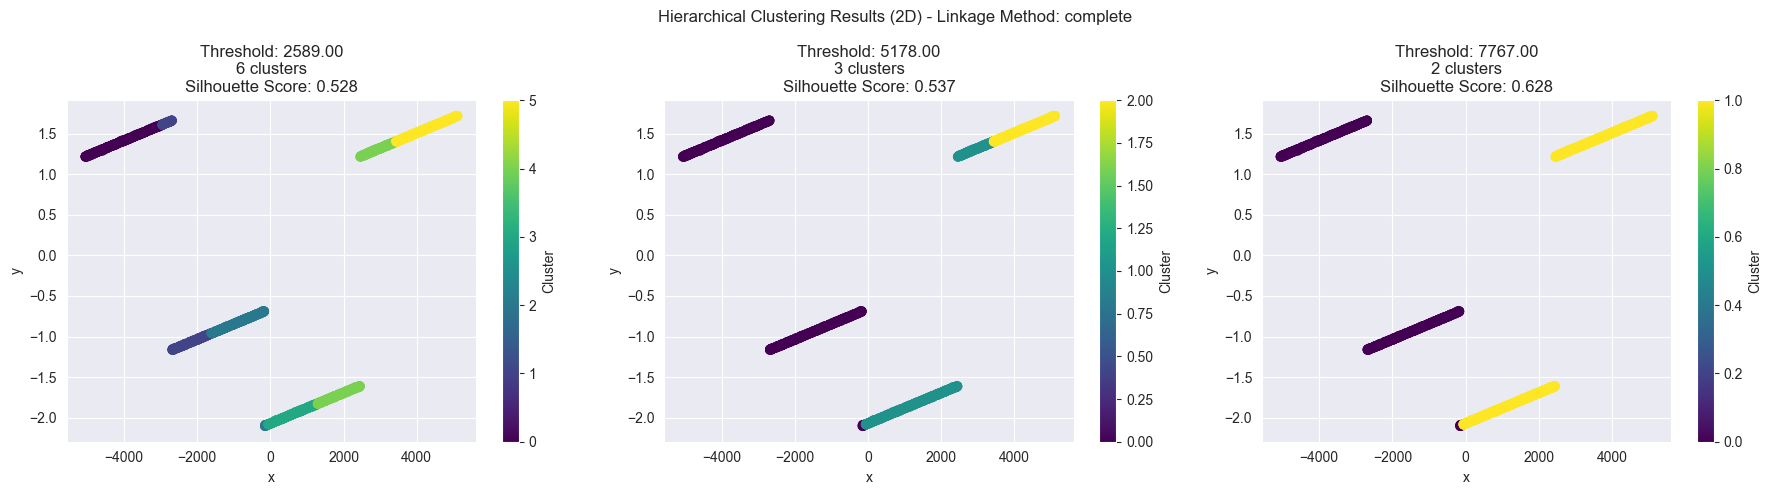

In [60]:
def find_optimal_threshold(Z):
    # Calculating the distances between clusters, and then finding the largest gap between consecutive distances
    distances = Z[:, 2]
    gaps = np.diff(distances)
    largest_gap = distances[np.argmax(gaps)]

    return largest_gap


def perform_clustering(data, method):
    Z = linkage(data, method=method)
    dist_threshold = find_optimal_threshold(Z)
    clusters = cut_tree(Z, height=dist_threshold).flatten()

    return Z, clusters, dist_threshold


def plot_cluster_analysis(Z, thresholds):
    fig = plt.figure(figsize=(20, 12))

    # Plotting the full dendrogram with multiple thresholds
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    dendrogram(Z, leaf_rotation=90)

    colours = ['r', 'g', 'b']
    for threshold, color in zip(thresholds, colours):
        ax1.axhline(y=threshold, color=color, linestyle='--',
                    label=f'Threshold: {threshold:.2f}')

        clusters = cut_tree(Z, height=threshold).flatten()
        n_clusters = len(np.unique(clusters))
        ax1.text(ax1.get_xlim()[1], threshold, f' {n_clusters} clusters',
                 va='bottom', ha='left', color=color)

    ax1.set_title('Full Dendrogram with Multiple Thresholds')
    ax1.legend()

    # Plotting the truncated dendrograms at different levels 
    # This is to showcase how levels purely represent a viewing perspective
    for i, level in enumerate([3, 10]):
        ax = plt.subplot2grid((2, 2), (1, i))
        dendrogram(Z, truncate_mode='level', p=level)

        # Plotting the thresholds
        for threshold, color in zip(thresholds, colours):
            ax.axhline(y=threshold, color=color, linestyle='--')

        ax.set_title(f'Truncated Dendrogram (Levels: {level})')

    plt.tight_layout()
    plt.show()


# These plots are meant to show how different thresholds influence the number of clusters and what impact they have on the silhouette scores
def plot_threshold_effects(data, Z, thresholds, sil_scores, method):
    n_thresholds = len(thresholds)
    fig, axs = plt.subplots(1, n_thresholds, figsize=(6 * n_thresholds, 5))

    for i, threshold in enumerate(thresholds):
        clusters = cut_tree(Z, height=threshold).flatten()
        n_clusters = len(np.unique(clusters))

        scatter = axs[i].scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis')
        axs[i].set_title(f'Threshold: {threshold:.2f}\n{n_clusters} clusters\nSilhouette Score: {sil_scores[i]:.3f}')
        axs[i].set_xlabel('x')
        axs[i].set_ylabel('y')
        plt.colorbar(scatter, ax=axs[i], label='Cluster')

    plt.suptitle(f'Hierarchical Clustering Results (2D) - Linkage Method: {method}')
    plt.tight_layout()
    plt.show()


def main_clustering_analysis(data, method='average'):
    Z, clusters, optimal_threshold = perform_clustering(data, method)

    # Comparison thresholds based on the optimal threshold
    thresholds = [optimal_threshold * 0.5, optimal_threshold, optimal_threshold * 1.5]

    sil_scores = []
    for threshold in thresholds:
        clusters = cut_tree(Z, height=threshold).flatten()
        n_clusters = len(np.unique(clusters))

        # It only makes sense to calculate the silhouette score IF there are multiple clusters
        if n_clusters > 1:
            sil_score = np.round(silhouette_score(data, clusters), 3)
            sil_scores.append(sil_score)
        else:
            sil_scores.append(np.nan)

    # Plotting visualizations (solely making use of PCA for 2D representation)
    pca = PCA(n_components=3)
    df_pca = pca.fit_transform(data)
    plot_cluster_analysis(Z, thresholds)
    plot_threshold_effects(df_pca, Z, thresholds, sil_scores, method)
    # Uncomment below to check how the cluster visualization would look without applying PCA
    #plot_threshold_effects(df_cluster.to_numpy(), Z, thresholds, sil_scores, method)

    return Z, thresholds


linkage_method = 'complete'
Z, thresholds = main_clustering_analysis(df_cluster, linkage_method)

In [61]:
print(f'There people who have osteoporosis do not occur frequently in the data, it occurs only '
      f'{round(sum(df_cluster["has_osteoporosis"])/2792, ndigits=4)}  the rows.')

There people who have osteoporosis do not occur frequently in the data, it occurs only 0.0809  the rows.


In [62]:
def transform_df_into_interquartile_range_categories(df_to_transform):
    """
    it is assumed that the values in the df are already scaled, relating to its distribution.

    For each float column in columns_to_transform. They should become a dummy variable of the same column depending on where the cell is in the interquartile range of such a column

    For each float column in columns_to_transform, four new binary columns will be created
    indicating which quartile range the value falls into:
    - '{col}_very_low': 1 if < Q1, else 0
    - '{col}_low': 1 if >= Q1 and < Q2, else 0
    - '{col}_high': 1 if >= Q2 and < Q3, else 0
    - '{col}_very_high': 1 if >= Q3, else 0

    :param df_to_transform: pandas DataFrame containing the columns to transform
    :return: transformed pandas DataFrame with new binary columns
    """
    df_local = df_to_transform#.copy()

    columns_to_transform = ['fish', 'poultry', 'red_meat', 'dairy_products', 'shellfish',
       'other_animal_products', 'no_animal_products',
       'vitaminB12_pmol_L',
           'total_calcium_mmol_L', 'total_protein_g_L', 'phosphorus_mmol_L',
           'alkaline_phosphatase_IU_L', 'creatinine_umol_L', 'vitaminD2_nmol_L',
           'vitaminD3_nmol_L', 'epi_vitaminD3_nmol_L', "Cluster", "kmeans_cluster"]


    # For each column, calculate quartiles and create new binary columns
    for col in columns_to_transform:
        if col in df_local.columns:
            # Calculate quartiles
            q1 = df_local[col].quantile(0.25)
            q2 = df_local[col].quantile(0.50)  # median
            q3 = df_local[col].quantile(0.75)

            # Create four new binary columns for each quartile range
            df_local[f'{col}_very_low'] = (df_local[col] < q1).astype(bool)
            df_local[f'{col}_low'] = ((df_local[col] >= q1) & (df_local[col] < q2)).astype(bool)
            df_local[f'{col}_high'] = ((df_local[col] >= q2) & (df_local[col] < q3)).astype(bool)
            df_local[f'{col}_very_high'] = (df_local[col] >= q3).astype(bool)

            # Drop original numerical column
            df_local.drop(columns=[col], inplace=True)

    df_local['type_Pescatarian'] =df_local['type_Pescatarian'].astype(bool)
    df_local['type_Vegetarian'] =df_local['type_Vegetarian'].astype(bool)

    df_local["has_osteoporosis"] = df_local["has_osteoporosis"].astype(bool)
    #df_local = df_local.applymap(lambda x: 1 if x > 0 else 0)

    return df_local

df_normalized_copy = df_cluster.copy().drop("kmeans_cluster", axis=1)
df_interquartile_transformed = transform_df_into_interquartile_range_categories(df_normalized_copy)
df_interquartile_transformed.head()

SEQN  has_osteoporosis  type_Pescatarian  type_Vegetarian  \
0  73557.0             False             False            False   
1  73558.0             False             False            False   
2  73559.0              True             False            False   
3  73561.0             False             False             True   
4  73564.0             False             False            False   

   fish_very_low  fish_low  fish_high  fish_very_high  poultry_very_low  \
0          False     False       True           False             False   
1          False     False      False            True             False   
2          False     False      False            True             False   
3          False     False       True           False             False   
4          False     False      False            True             False   

   poultry_low  ...  vitaminD3_nmol_L_high  vitaminD3_nmol_L_very_high  \
0        False  ...                  False                       False   
1        False  ...                  False                       False   
2         True  ...                  False                        True   
3         True  ...                  False                        True   
4        False  ...                  False                        True   

   epi_vitaminD3_nmol_L_very_low  epi_vitaminD3_nmol_L_low  \
0                           True                     False   
1                          False                      True   
2                          False                     False   
3                          False                     False   
4                          False                     False   

   epi_vitaminD3_nmol_L_high  epi_vitaminD3_nmol_L_very_high  \
0                      False                           False   
1                      False                           False   
2                      False                            True   
3                      False                            True   
4                       True                           False   

   Cluster_very_low  Cluster_low  Cluster_high  Cluster_very_high  
0             False        False         False               True  
1             False        False         False               True  
2             False        False         False               True  
3             False        False         False               True  
4             False        False         False               True  

[5 rows x 72 columns]

In [63]:
#running the fpgrowth algorithm
def get_itemsets_from_interquartilerange_df(df_interquartile_itemset, min_support=0.05, print_items=True):
    dataset = df_interquartile_itemset
    item_sets_found = fpgrowth(dataset, min_support=min_support, use_colnames=True, max_len=6, verbose=False)
    if print_items:
        for index, item in item_sets_found.iterrows():
            for val in item["itemsets"]:
                if "has_osteoporosis" in val:
                    print("itemset nr = ", index)
                    print("itemset = ",item["itemsets"])
                    print("support itemset = ", item["support"])
                    print()
    return item_sets_found
item_sets = get_itemsets_from_interquartilerange_df(df_interquartile_transformed.drop(["SEQN"], axis=1), 0.02)
item_sets.head()

itemset nr =  35
itemset =  frozenset({'has_osteoporosis'})
support itemset =  0.08094555873925502

itemset nr =  26513
itemset =  frozenset({'has_osteoporosis', 'shellfish_very_high'})
support itemset =  0.08094555873925502

itemset nr =  26514
itemset =  frozenset({'has_osteoporosis', 'vitaminD2_nmol_L_very_high'})
support itemset =  0.08094555873925502

itemset nr =  26515
itemset =  frozenset({'Cluster_very_high', 'has_osteoporosis'})
support itemset =  0.03796561604584527

itemset nr =  26516
itemset =  frozenset({'has_osteoporosis', 'vitaminD3_nmol_L_very_high'})
support itemset =  0.035458452722063036

itemset nr =  26517
itemset =  frozenset({'has_osteoporosis', 'no_animal_products_very_high'})
support itemset =  0.0336676217765043

itemset nr =  26518
itemset =  frozenset({'has_osteoporosis', 'epi_vitaminD3_nmol_L_very_high'})
support itemset =  0.031160458452722063

itemset nr =  26519
itemset =  frozenset({'other_animal_products_very_high', 'has_osteoporosis'})
support items

support                      itemsets
0  1.000000  (vitaminD2_nmol_L_very_high)
1  1.000000         (shellfish_very_high)
2  0.724212                   (fish_high)
3  0.492479           (Cluster_very_high)
4  0.399355           (poultry_very_high)

In [64]:
set([row if "has" in val else "" for row in item_sets["itemsets"] for val in row])

{'',
 frozenset({'Cluster_low',
            'has_osteoporosis',
            'shellfish_very_high',
            'vitaminD2_nmol_L_very_high'}),
 frozenset({'Cluster_low', 'has_osteoporosis', 'shellfish_very_high'}),
 frozenset({'Cluster_low', 'has_osteoporosis', 'vitaminD2_nmol_L_very_high'}),
 frozenset({'Cluster_low', 'has_osteoporosis'}),
 frozenset({'Cluster_very_high',
            'fish_high',
            'has_osteoporosis',
            'shellfish_very_high'}),
 frozenset({'Cluster_very_high',
            'fish_high',
            'has_osteoporosis',
            'vitaminD2_nmol_L_very_high'}),
 frozenset({'Cluster_very_high', 'fish_high', 'has_osteoporosis'}),
 frozenset({'Cluster_very_high',
            'has_osteoporosis',
            'shellfish_very_high',
            'vitaminD2_nmol_L_very_high'}),
 frozenset({'Cluster_very_high', 'has_osteoporosis', 'shellfish_very_high'}),
 frozenset({'Cluster_very_high',
            'has_osteoporosis',
            'vitaminD2_nmol_L_very_high'}

We take for min_threshold >1.2 as this is important. Threshold =1, is when the chance of a rules being true, is the same as the statistical likelihood of the rules occuring based on chance. So this would not tell us anything about the data

In [65]:
def get_rules_from_itemsets(item_sets_found, metric="lift", min_threshold=1.2):
    # # Generate association rules with a minimum confidence level
    rules_found = association_rules(item_sets_found, metric=metric,
                                    min_threshold=min_threshold, num_itemsets=len(item_sets_found))
    return rules_found

rules = get_rules_from_itemsets(item_sets)
rules

antecedents  \
0                       (other_animal_products_very_high)   
1                                    (red_meat_very_high)   
2       (other_animal_products_very_high, vitaminD2_nm...   
3        (red_meat_very_high, vitaminD2_nmol_L_very_high)   
4                       (other_animal_products_very_high)   
...                                                   ...   
204837   (red_meat_very_high, vitaminD2_nmol_L_very_high)   
204838                           (fish_high, poultry_low)   
204839          (vitaminD2_nmol_L_very_high, poultry_low)   
204840                               (red_meat_very_high)   
204841                                      (poultry_low)   

                                              consequents  antecedent support  \
0                                    (red_meat_very_high)            0.379298   
1                       (other_animal_products_very_high)            0.379656   
2                                    (red_meat_very_high)            0.379298   
3                       (other_animal_products_very_high)            0.379656   
4        (red_meat_very_high, vitaminD2_nmol_L_very_high)            0.379298   
...                                                   ...                 ...   
204837  (Cluster_low, shellfish_very_high, fish_high, ...            0.379656   
204838  (Cluster_low, shellfish_very_high, red_meat_ve...            0.203438   
204839  (Cluster_low, shellfish_very_high, fish_high, ...            0.288324   
204840  (Cluster_low, shellfish_very_high, fish_high, ...            0.379656   
204841  (Cluster_low, shellfish_very_high, red_meat_ve...            0.288324   

        consequent support   support  confidence      lift  representativity  \
0                 0.379656  0.223496    0.589235  1.552023               1.0   
1                 0.379298  0.223496    0.588679  1.552023               1.0   
2                 0.379656  0.223496    0.589235  1.552023               1.0   
3                 0.379298  0.223496    0.588679  1.552023               1.0   
4                 0.379656  0.223496    0.589235  1.552023               1.0   
...                    ...       ...         ...       ...               ...   
204837            0.053367  0.030086    0.079245  1.484918               1.0   
204838            0.099212  0.030086    0.147887  1.490619               1.0   
204839            0.080229  0.030086    0.104348  1.300621               1.0   
204840            0.053367  0.030086    0.079245  1.484918               1.0   
204841            0.080229  0.030086    0.104348  1.300621               1.0   

        leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0       0.079493    1.510216       0.573028  0.417391   0.337843    0.588957  
1       0.079493    1.509046       0.573359  0.417391   0.337330    0.588957  
2       0.079493    1.510216       0.573028  0.417391   0.337843    0.588957  
3       0.079493    1.509046       0.573359  0.417391   0.337330    0.588957  
4       0.079493    1.510216       0.573028  0.417391   0.337843    0.588957  
...          ...         ...            ...       ...        ...         ...  
204837  0.009825    1.028106       0.526421  0.074667   0.027337    0.321502  
204838  0.009902    1.057123       0.413198  0.110381   0.054036    0.225568  
204839  0.006954    1.026929       0.324778  0.088889   0.026222    0.239674  
204840  0.009825    1.028106       0.526421  0.074667   0.027337    0.321502  
204841  0.006954    1.026929       0.324778  0.088889   0.026222    0.239674  

[204842 rows x 14 columns]

In [66]:
def filter_association_rules_has_osteoporosis(df_rules):
    # List to collect rows that meet the condition

    osteoporosis_rules_indexes = list(set([index if "has" in val else 0
                               for index, row in enumerate(df_rules["consequents"])
                               for val in row]))
    osteoporosis_rules_indexes.pop(0)
    # Now we have all rules where one of the consequents is (has_osteoporosis)
    rules_osteoporosis = rules.iloc[osteoporosis_rules_indexes]

    osteoporosis_only_rules = list(set([index
                               for index, row in enumerate(rules_osteoporosis["consequents"])
                               if len(row) ==1]))

    filtered_rules = rules_osteoporosis.iloc[osteoporosis_only_rules]

    # Sort by confidence (if there are rows)
    if not filtered_rules.empty:
        filtered_rules = filtered_rules.sort_values(by="confidence", ascending=False)

    return filtered_rules


rules_response_var_df = filter_association_rules_has_osteoporosis(rules)
print(f"There are {len(rules_response_var_df)} rules found with a lift value of at least 1.2. "
      f"The confidence ranges from {round(min(rules_response_var_df['confidence']),ndigits=3)} "
      f"to {round(max(rules_response_var_df['confidence']),ndigits=3)}, "
      f"the support for the rules if found to range from {round(min(rules_response_var_df['support']),ndigits=3)} "
      f"to {round(max(rules_response_var_df['support']),ndigits=3)}. "
      f"The found Lift values for rules with precedent \"has_osteoporosis\" is in the range from {round(min(rules_response_var_df['lift']),ndigits=3)} "
      f"to {round(max(rules_response_var_df['lift']),ndigits=3)}.")
rules_response_var_df.head()

There are 48 rules found with a lift value of at least 1.2. The confidence ranges from 0.107 to 0.149, the support for the rules if found to range from 0.02 to 0.035. The found Lift values for rules with precedent "has_osteoporosis" is in the range from 1.319 to 1.847.


antecedents         consequents  \
123974  (shellfish_very_high, vitaminD3_nmol_L_very_hi...  (has_osteoporosis)   
123932  (vitaminD3_nmol_L_very_high, epi_vitaminD3_nmo...  (has_osteoporosis)   
123962  (vitaminD3_nmol_L_very_high, epi_vitaminD3_nmo...  (has_osteoporosis)   
123950  (shellfish_very_high, vitaminD3_nmol_L_very_hi...  (has_osteoporosis)   
123859  (shellfish_very_high, vitaminD3_nmol_L_very_high)  (has_osteoporosis)   

        antecedent support  consequent support   support  confidence  \
123974            0.177292            0.080946  0.026504    0.149495   
123932            0.177292            0.080946  0.026504    0.149495   
123962            0.177292            0.080946  0.026504    0.149495   
123950            0.177292            0.080946  0.026504    0.149495   
123859            0.250716            0.080946  0.035458    0.141429   

            lift  representativity  leverage  conviction  zhangs_metric  \
123974  1.846858               1.0  0.012153    1.080598       0.557354   
123932  1.846858               1.0  0.012153    1.080598       0.557354   
123962  1.846858               1.0  0.012153    1.080598       0.557354   
123950  1.846858               1.0  0.012153    1.080598       0.557354   
123859  1.747206               1.0  0.015164    1.070446       0.570755   

         jaccard  certainty  kulczynski  
123974  0.114374   0.074587    0.238464  
123932  0.114374   0.074587    0.238464  
123962  0.114374   0.074587    0.238464  
123950  0.114374   0.074587    0.238464  
123859  0.119710   0.065810    0.289741

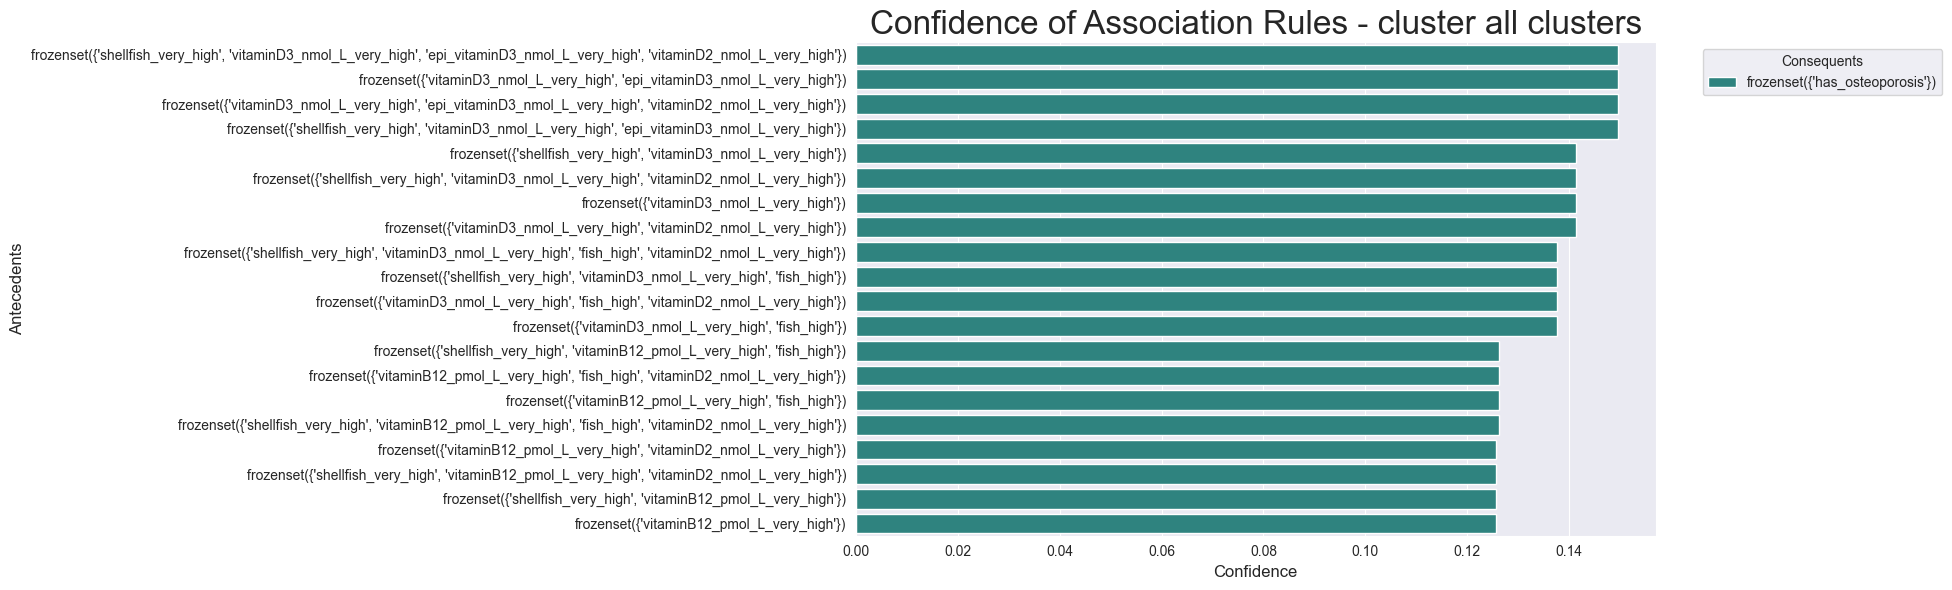

In [67]:
def plot_rules(rules_df_to_plot, cluster_group=1):
    # # Create a bar plot for confidence values

    plt.figure(figsize=(20, 6))
    sns.barplot(x='confidence', y='antecedents', hue='consequents', data=rules_df_to_plot.head(20), palette='viridis')

    # # Add title and labels
    plt.title(f'Confidence of Association Rules - cluster {cluster_group}', fontsize=24)
    plt.xlabel('Confidence', fontsize=12)
    plt.ylabel('Antecedents', fontsize=12)
    plt.legend(title='Consequents', bbox_to_anchor=(1.05, 1), loc='upper left')

    # # Show plot
    plt.tight_layout()
    plt.show()
plot_rules(rules_response_var_df, cluster_group="all clusters")

### Interpretation association rules

We created all possible item sets with a threshold of at least 0.02, meaning that a combination of item sets must occur in at least 2% of the data—equivalent to 60 examples—before being evaluated. These item sets were then filtered to include only those where the antecedent is the binary variable indicating osteoporosis. This revealed some intriguing patterns. For instance, combinations of variables were identified with confidence levels as high as 15%, based purely on statistical correlation. One notable finding is that high levels of vitamin D3 are strongly correlated with osteoporosis, with a confidence of 14.1%. This is surprising because research generally shows that a deficiency in vitamin D3 is related to osteoporosis. A plausible explanation is that individuals with osteoporosis are aware of their condition and may consume vitamin D supplements to manage it.

Another interesting observation is the correlation between high levels of vitamin B12 and osteoporosis. This is counterintuitive since B12 is typically negatively associated with osteoporosis. The data suggests that individuals who know they have osteoporosis might be taking vitamin B12 supplements as part of their management plan. Additionally, the only food-related variable in the top 20 osteoporosis-related incidences is high fish consumption. This suggests that eating a lot of fish is associated with osteoporosis. However, this finding might be a fluke due to the limited two-day scope of food data, as there is no strong evidence in existing research linking fish consumption to osteoporosis.

It is possible that this observed relationship with fish consumption points to an unexplored connection. Alternatively, it might simply reflect a statistical anomaly. Including data on supplement levels for vitamin D and B12 would have improved the analysis by allowing us to account for supplement use. People who take high levels of supplements are likely trying to prevent further deterioration of their osteoporosis, which might explain some of the unexpected correlations observed in this study.

### Add confidence column
Afterwards, we incorporate the calculated confidences as a new column in our dataset. This column will represent the confidence that a given row corresponds to a case of osteoporosis. By adding this information, we aim to enhance the model’s predictive capability, particularly for simpler models, which are likely to benefit significantly from this additional insight. Without this confidence column, the model’s performance would likely degrade, as it would lack this valuable input derived from our analysis.

In [68]:
def add_confidence_column(df_input ,rules_df):
    df_marketing = df_input.copy()
    df_marketing["confidence"] = 0
    rules_df = rules_df.sort_values(by="confidence", ascending=True)
    for index, rule in rules_df.iterrows():

        frozen_set = [val for val in rule["antecedents"]]
        #df_interquartile_transformed[(df_interquartile_transformed['income_very_high'] ==1) & (df_interquartile_transformed['total_accepted_cpm'] == 1)]
        # Construct a condition to filter df_marketing based on all values in frozen_set
        filter_condition = True
        for condition in frozen_set:
            # Dynamically create conditions for each antecedent in the frozen set
            filter_condition &= (df_marketing[condition] == 1)

        # Apply the filter and set confidence based on the rule's confidence value
        df_marketing.loc[filter_condition, 'confidence'] = rule['confidence']
    return df_marketing.fillna(0)#.sort_index()

df_marketing_featured = add_confidence_column(df_interquartile_transformed, rules_response_var_df)
df_marketing_featured.head()

/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_38540/138378810.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10679611650485436' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_marketing.loc[filter_condition, 'confidence'] = rule['confidence']


SEQN  has_osteoporosis  type_Pescatarian  type_Vegetarian  \
0  73557.0             False             False            False   
1  73558.0             False             False            False   
2  73559.0              True             False            False   
3  73561.0             False             False             True   
4  73564.0             False             False            False   

   fish_very_low  fish_low  fish_high  fish_very_high  poultry_very_low  \
0          False     False       True           False             False   
1          False     False      False            True             False   
2          False     False      False            True             False   
3          False     False       True           False             False   
4          False     False      False            True             False   

   poultry_low  ...  vitaminD3_nmol_L_very_high  \
0        False  ...                       False   
1        False  ...                       False   
2         True  ...                        True   
3         True  ...                        True   
4        False  ...                        True   

   epi_vitaminD3_nmol_L_very_low  epi_vitaminD3_nmol_L_low  \
0                           True                     False   
1                          False                      True   
2                          False                     False   
3                          False                     False   
4                          False                     False   

   epi_vitaminD3_nmol_L_high  epi_vitaminD3_nmol_L_very_high  \
0                      False                           False   
1                      False                           False   
2                      False                            True   
3                      False                            True   
4                       True                           False   

   Cluster_very_low  Cluster_low  Cluster_high  Cluster_very_high  confidence  
0             False        False         False               True    0.121008  
1             False        False         False               True    0.000000  
2             False        False         False               True    0.149495  
3             False        False         False               True    0.149495  
4             False        False         False               True    0.141429  

[5 rows x 73 columns]

In [69]:
df_confidence = df_normalized.merge(df_marketing_featured[["SEQN", "confidence"]], on="SEQN", how="left")
print("added")

added


# Modeling
For the modeling process, we will begin by splitting the dataset into training and testing sets. To address the class imbalance, as only 8% of the data has the target label, we will apply SMOTE to balance the dataset. Initially, we will build logistic regression and SVM models. We will then evaluate these models by generating confusion matrices to assess their ability to predict whether someone has osteoporosis.

Following this, we will fine-tune the logistic regression model, as we anticipate it will perform better based on our initial evaluation. Next, we will build a random forest model, fine-tune it, and conclude by performing hyperparameter tuning on the random forest to optimize its performance.

Finally, in the third phase, we will create a neural network using the FastAI library to have full control over the architecture, including multiple layers. The neurons in this network will be initialized with randomly assigned weights, and we will not use a pre-trained model for this step.

### Logistic regression



In [106]:
from imblearn.over_sampling import SMOTE


def get_x_y_train(df, with_smote):
    df.dropna()
    X = df.drop(columns='has_osteoporosis')
    y = df['has_osteoporosis']
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    if with_smote:
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        return X_train_smote, X_test, y_train_smote, y_test
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_x_y_train(df_confidence, True)
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(y_train.value_counts())

Class distribution before SMOTE:
has_osteoporosis
0.0    2049
1.0    2049
Name: count, dtype: int64

Class distribution after SMOTE:
has_osteoporosis
0.0    2049
1.0    2049
Name: count, dtype: int64


### Logistic regression

In [107]:
def create_logistic_regression_model(x_train_data, x_test_data, y_train_data):
    model = LogisticRegression(random_state=42)
    model.fit(x_train_data, y_train_data)
    y_pred = model.predict(x_test_data)
    return model, y_pred

lr_model, lr_y_pred = create_logistic_regression_model(x_train_data=X_train,
                                                       x_test_data=X_test,
                                                       y_train_data=y_train)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [108]:
def create_svm_model(x_train_data, x_test_data, y_train_data):
    model = svm.SVC(random_state=42)
    model.fit(x_train_data, y_train_data)
    y_pred = model.predict(x_test_data)
    return model, y_pred

svm_model, svm_pred = create_svm_model(x_train_data=X_train,
                                         x_test_data=X_test,
                                         y_train_data=y_train)

## Evaluation of models

Evaluation for Logistic Regression:
    Accuracy: 0.67
    Precision: 0.15
    Recall: 0.69
    F1 Score: 0.24
    ROC-AUC: 0.68



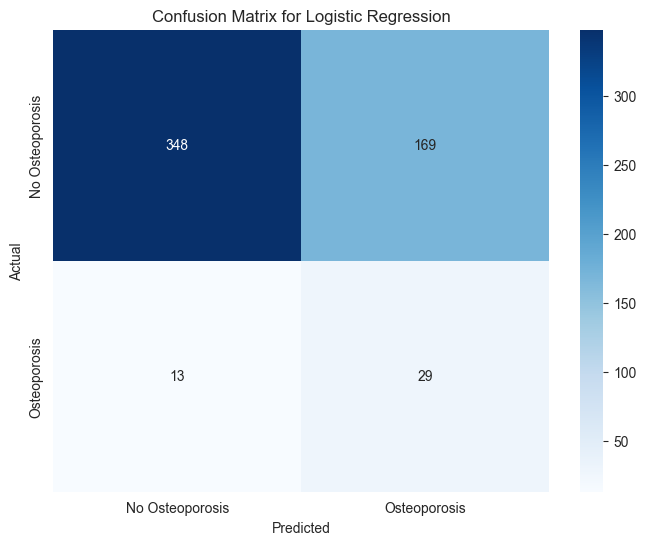

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79       517
         1.0       0.15      0.69      0.24        42

    accuracy                           0.67       559
   macro avg       0.56      0.68      0.52       559
weighted avg       0.90      0.67      0.75       559


Evaluation for SVM:
    Accuracy: 0.50
    Precision: 0.07
    Recall: 0.48
    F1 Score: 0.13
    ROC-AUC: 0.49



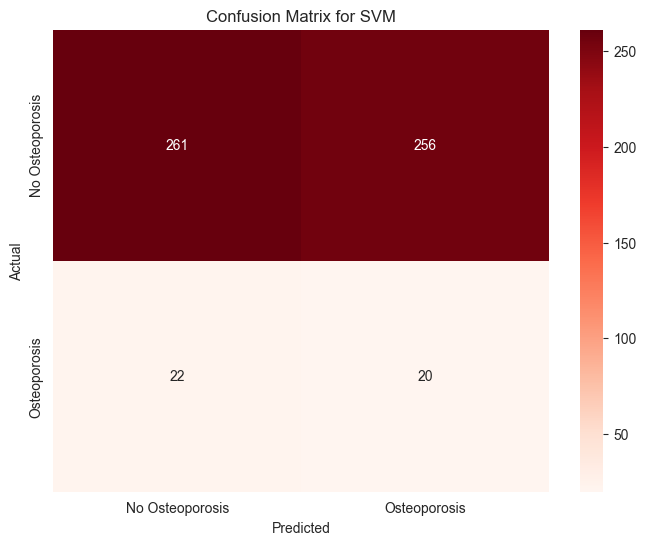

Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.92      0.50      0.65       517
         1.0       0.07      0.48      0.13        42

    accuracy                           0.50       559
   macro avg       0.50      0.49      0.39       559
weighted avg       0.86      0.50      0.61       559




In [122]:
def evaluate_model(y_test, y_pred, model_name="Model"):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Print metrics
    print(f"Evaluation for {model_name}:")
    print(f"    Accuracy: {accuracy:.2f}")
    print(f"    Precision: {precision:.2f}")
    print(f"    Recall: {recall:.2f}")
    print(f"    F1 Score: {f1:.2f}")
    print(f"    ROC-AUC: {roc_auc:.2f}\n")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    if model_name.__contains__("Logistic Regression"):
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Osteoporosis', 'Osteoporosis'], yticklabels=['No Osteoporosis', 'Osteoporosis'])
    elif model_name.__contains__("Random Forest"):
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['No Osteoporosis', 'Osteoporosis'], yticklabels=['No Osteoporosis', 'Osteoporosis'])
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No Osteoporosis', 'Osteoporosis'], yticklabels=['No Osteoporosis', 'Osteoporosis'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Classification report for detailed performance metrics
    print(f'Classification Report for {model_name}:')
    print(classification_report(y_test, y_pred))
    print('====================================================================================================================================\n')

evaluate_model(y_test, lr_y_pred, model_name="Logistic Regression")
evaluate_model(y_test, svm_pred, model_name="SVM")
#evaluate_model(y_test, ann_y_pred, model_name="Artificial Neural Network")

## Interpretation simple models
### Logistic regression
The logistic seems to be much better than the standard SVM. The True positive/False negative = 0.67. Which is really good but the True negative / False negative is quite underperforming

### SVM
SVM seems to split the data in half. The ratio of True positive and false positive is 0.5, while the ratio of True negative and false negative is also 0.5. So therefore it seems that the whole dataset is split in half. As it merely shows the statistical distribution in the dataset.

## Finetune logistic regression
So let's finetune the logistic regression below now.

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38540) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38540) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38540) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: 

Best Logistic Regression Parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Evaluation for Logistic Regression:
    Accuracy: 0.67
    Precision: 0.15
    Recall: 0.69
    F1 Score: 0.24
    ROC-AUC: 0.68



/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


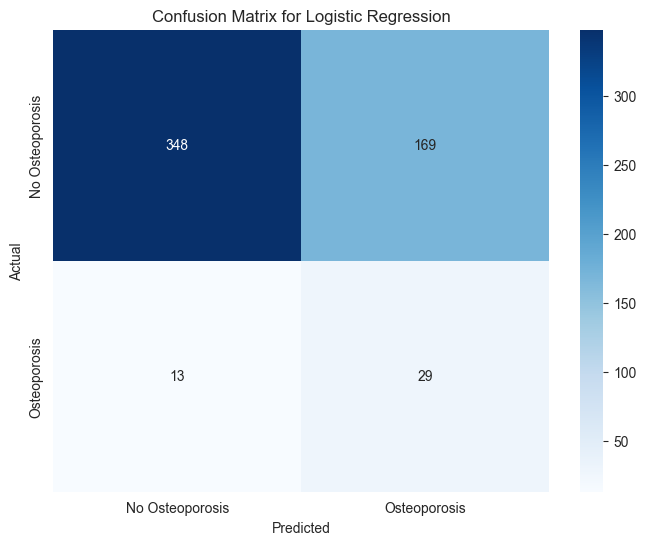

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79       517
         1.0       0.15      0.69      0.24        42

    accuracy                           0.67       559
   macro avg       0.56      0.68      0.52       559
weighted avg       0.90      0.67      0.75       559




In [123]:
# Logistic Regression with GridSearchCV for Hyperparameter Tuning
def create_logistic_regression_model_tuning(x_train_data, x_test_data, y_train_data):
    param_grid = {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [100, 200, 500]
    }

    model = LogisticRegression(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(x_train_data, y_train_data)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test_data)
    print("Best Logistic Regression Parameters:", grid_search.best_params_)
    return best_model, y_pred

lr_model, lr_y_pred = create_logistic_regression_model_tuning(x_train_data=X_train, x_test_data=X_test, y_train_data=y_train)
evaluate_model(y_test, lr_y_pred, model_name="Logistic Regression")

# Advanced modeling Random Forest regressor

As we can see below from the results from the random forest, it performs much poorer compared to the logistic regression, it has optimized for correctly labeling when someone does not have osteoporosis. However, it is much more important that we find the people with osteoporososis that to tell people they do not have it. So in subsequent steps we will perform hyperparameter tuning to use the F1 score as optimization value, as well as lowering the threshold that determines when a prediction confidence turns into a postitive prediction. 

Evaluation for Random Forest Regressor:
    Accuracy: 0.92
    Precision: 0.22
    Recall: 0.05
    F1 Score: 0.08
    ROC-AUC: 0.52



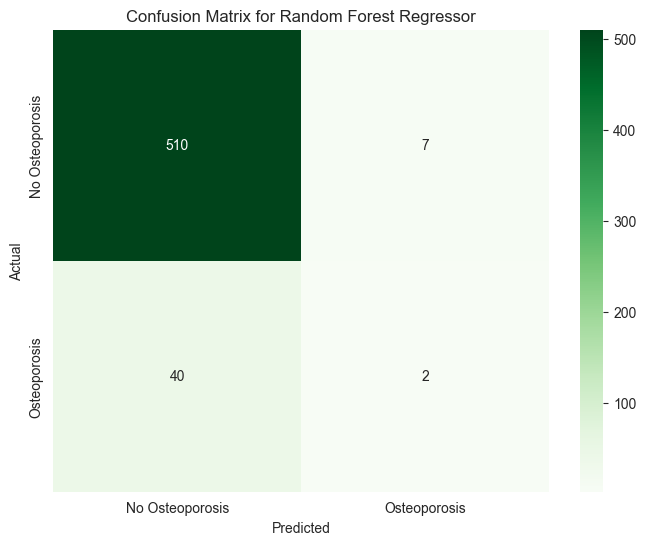

Classification Report for Random Forest Regressor:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       517
         1.0       0.22      0.05      0.08        42

    accuracy                           0.92       559
   macro avg       0.57      0.52      0.52       559
weighted avg       0.87      0.92      0.89       559




In [124]:
def create_random_forest_model(x_train_data, x_test_data, y_train_data):
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train_data, y_train_data)
    y_pred = model.predict(x_test_data)
    return model, y_pred

rf_model, rf_y_pred = create_random_forest_model(x_train_data=X_train,
                                         x_test_data=X_test,
                                         y_train_data=y_train)
evaluate_model(y_test, rf_y_pred, model_name="Random Forest Regressor")


### Adjusting threshold 

As the random forest predicts quite well the people that do not have osteoporosis. It has labeled almost none of the response has osteoporosis, and this is a problem. Therefore, we are going to change the threshold value of a prediction to be true, to change it to 0.4, and to see if this will improve our ratio. And then we will, later on, we will also use the threshold ratio of 0.3.

Evaluation for Random Forest Regressor | threshold = 0.4:
    Accuracy: 0.89
    Precision: 0.25
    Recall: 0.21
    F1 Score: 0.23
    ROC-AUC: 0.58



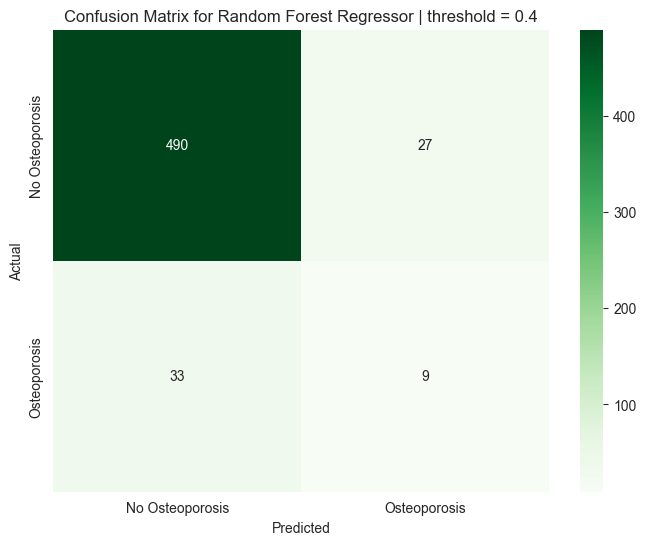

Classification Report for Random Forest Regressor | threshold = 0.4:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       517
         1.0       0.25      0.21      0.23        42

    accuracy                           0.89       559
   macro avg       0.59      0.58      0.59       559
weighted avg       0.89      0.89      0.89       559




In [125]:
def create_random_forest_model_proba(x_train_data, x_test_data, y_train_data, threshold_true):

    model = RandomForestClassifier(random_state=42)
    model.fit(x_train_data, y_train_data)
    y_pred_prob = model.predict_proba(x_test_data)
    y_pred = np.array([1 if pred[1] > threshold_true else 0 for pred in y_pred_prob])
    return y_pred, y_pred_prob

threshold_positive = 0.4
rfc_pred, rfc_prob = create_random_forest_model_proba(x_train_data=X_train,
                                                      x_test_data=X_test,
                                                      y_train_data=y_train,
                                                      threshold_true=threshold_positive)

evaluate_model(y_test, rfc_pred, model_name=f"Random Forest Regressor | threshold = {threshold_positive}")

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best Mean F1 Score: 0.9466769254991825
Evaluation for Random Forest Regressor | threshold = 0.4:
    Accuracy: 0.89
    Precision: 0.26
    Recall: 0.26
    F1 Score: 0.26
    ROC-AUC: 0.60



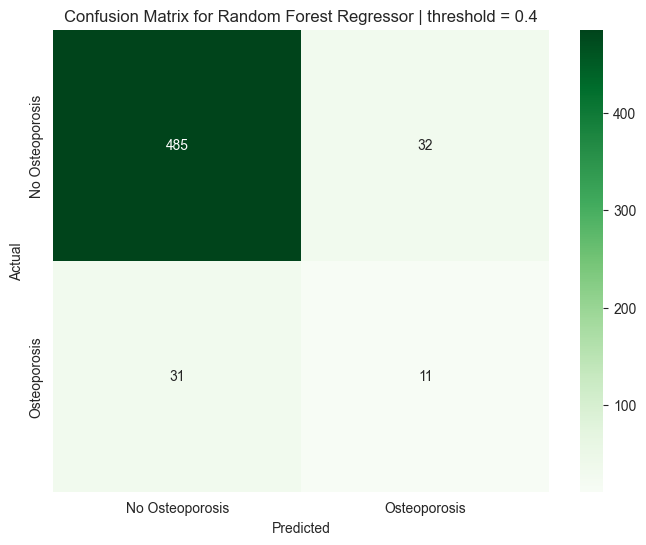

Classification Report for Random Forest Regressor | threshold = 0.4:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       517
         1.0       0.26      0.26      0.26        42

    accuracy                           0.89       559
   macro avg       0.60      0.60      0.60       559
weighted avg       0.89      0.89      0.89       559




In [126]:
from imblearn.pipeline import Pipeline

def parameter_tuning_for_rf(x_train_data, x_test_data, y_train_data, threshold_true):
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'model__n_estimators': [100, 150, 200, 250, 300],    # Number of trees in the forest
        'model__max_depth': [None, 5, 10, 15, 20],        # Maximum depth of the tree
        'model__min_samples_split': [2, 5, 7, 10],        # Minimum samples required to split an internal node
        'model__min_samples_leaf': [1, 2, 3]          # Minimum samples required to be a leaf node
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(x_train_data, y_train_data)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Mean F1 Score:", grid_search.best_score_)

    y_proba = grid_search.best_estimator_.predict_proba(x_test_data)
    y_pred = np.array([1 if pred[1] > threshold_true else 0 for pred in y_proba])


    return y_pred, y_proba


threshold_positive = 0.4
tuned_rfcpred, tuned_rfcproba = parameter_tuning_for_rf(x_train_data=X_train,
                                                      x_test_data=X_test,
                                                      y_train_data=y_train,
                                                      threshold_true=threshold_positive)

evaluate_model(y_test, tuned_rfcpred, model_name=f"Random Forest Regressor | threshold = {threshold_positive}")


Evaluation for Random Forest Regressor | threshold = 0.3:
    Accuracy: 0.80
    Precision: 0.15
    Recall: 0.36
    F1 Score: 0.21
    ROC-AUC: 0.60



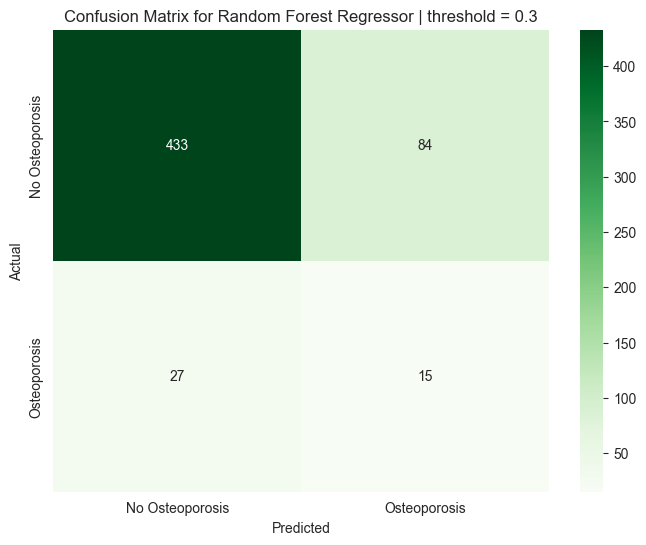

Classification Report for Random Forest Regressor | threshold = 0.3:
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89       517
         1.0       0.15      0.36      0.21        42

    accuracy                           0.80       559
   macro avg       0.55      0.60      0.55       559
weighted avg       0.88      0.80      0.84       559




In [128]:
threshold_positive = 0.3

adjusted_tuned_rfc_pred = np.array([1 if pred[1] > threshold_positive else 0 for pred in tuned_rfcproba])

evaluate_model(y_test, adjusted_tuned_rfc_pred, model_name=f"Random Forest Regressor | threshold = {threshold_positive}")


## Multilabel prediction

/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


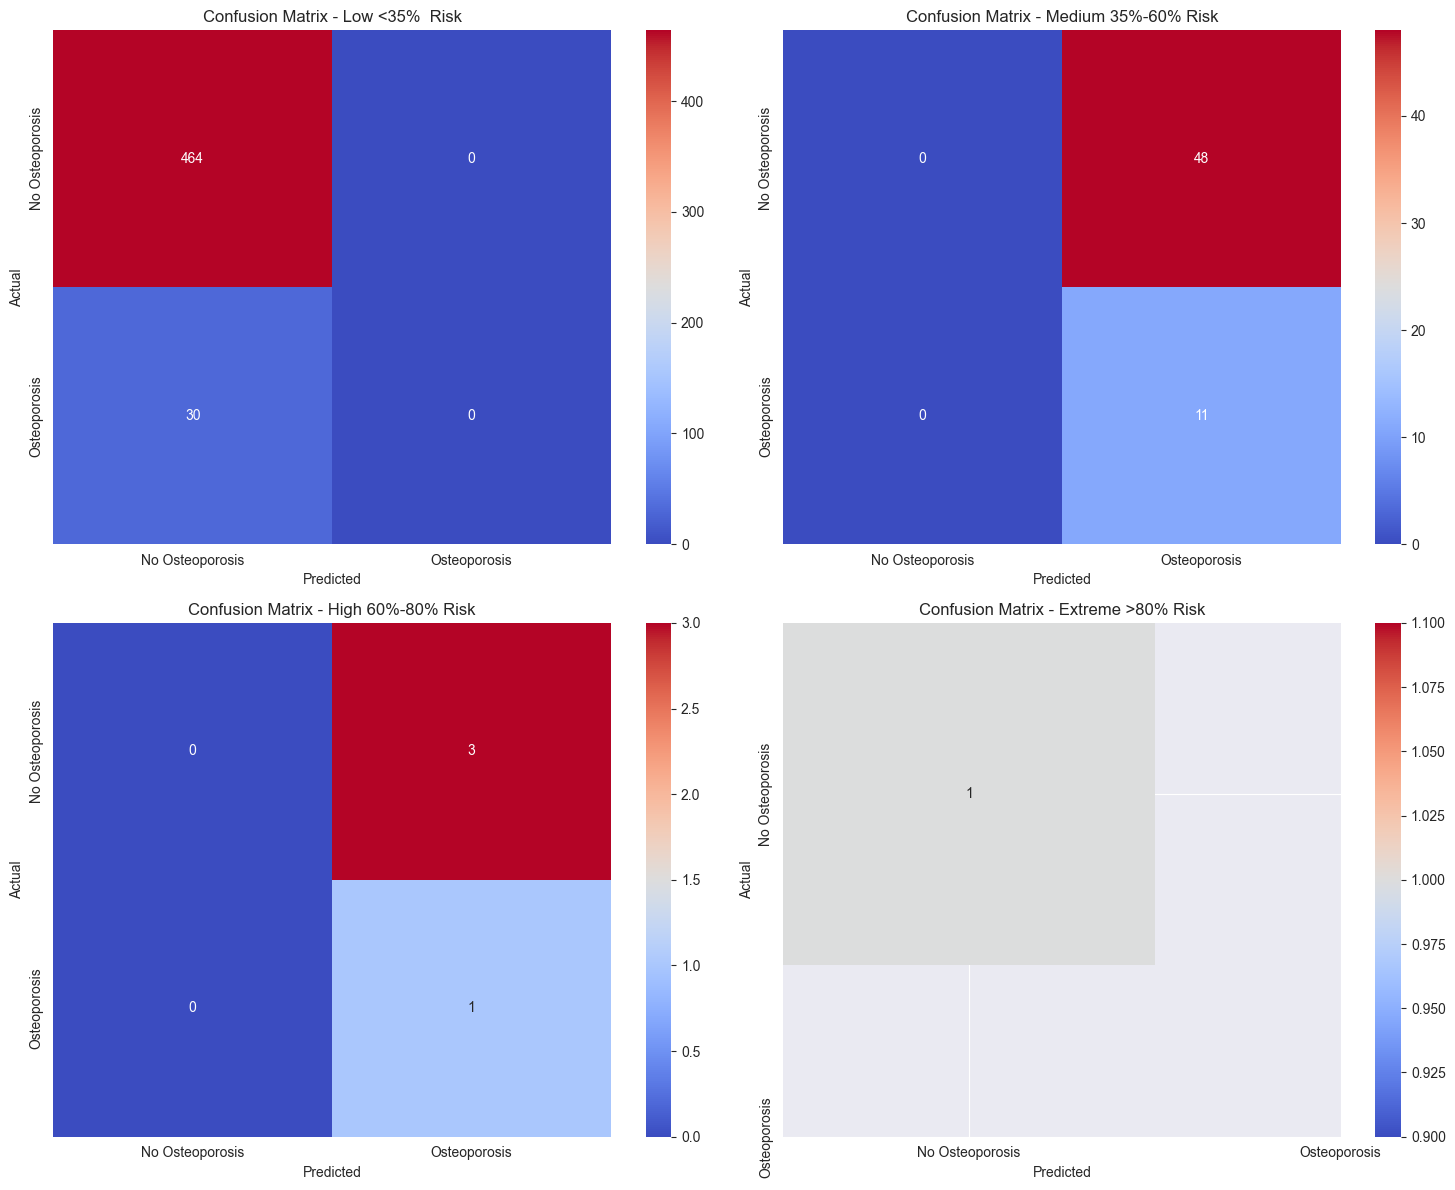

In [129]:
def plot_confusion_matrices_by_risk(y_test, y_prob):
    risk_labels = ['Low <35% ', 'Medium 35%-60%', 'High 60%-80%', 'Extreme >80%']
    # Initialize the subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Define risk level indices based on the probability thresholds
    extreme_risk_indexes = [index for index, val in enumerate(y_prob) if 1 >= val[1] > 0.8]
    high_risk_indexes = [index for index, val in enumerate(y_prob) if 0.8 >= val[1] > 0.6]
    medium_risk_indexes = [index for index, val in enumerate(y_prob) if 0.6 >= val[1] > 0.35]
    low_risk_indexes = [index for index, val in enumerate(y_prob) if 0.35 >= val[1] > 0.0]
    
    risk_indices = [low_risk_indexes, medium_risk_indexes, high_risk_indexes, extreme_risk_indexes]
    
    for i, (risk_label, indices) in enumerate(zip(risk_labels, risk_indices)):
        # Subset the test and prediction values
        y_test_subset = y_test.iloc[indices]  # Subset y_test based on indices
        if i == 0:
            y_pred_subset = np.array([0 for idx in range(len(y_test))if idx in indices])# Binary prediction
        else:
            y_pred_subset = np.array([1 for idx in range(len(y_test))if idx in indices])# Binary prediction
        # Compute confusion matrix
        if not indices:
            y_test_subset, y_pred_subset = [0],[0]
        
        conf_matrix = confusion_matrix(y_test_subset, y_pred_subset)
        
        # Plot confusion matrix
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[i],
                    xticklabels=['No Osteoporosis', 'Osteoporosis'], yticklabels=['No Osteoporosis', 'Osteoporosis'])
        axes[i].set_title(f'Confusion Matrix - {risk_label} Risk')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
# Define risk labels


# Call the function with test and prediction data
plot_confusion_matrices_by_risk(y_test=y_test, y_prob=tuned_rfcproba)

# Neural network

We use the package fastai, to make the neural network. We are going to try different version of the Neural network.

In [130]:
from fastai.tabular.all import *
def get_data_fastai_data():
    # Categorical and Continuous variables
    cat_names = ['type_Pescatarian', 'type_Vegetarian']
    cont_names = ['fish', 'poultry', 'red_meat', 'dairy_products', 'shellfish',
                  'other_animal_products', 'no_animal_products', "confidence",
                  'vitaminB12_pmol_L', 'total_calcium_mmol_L', 'total_protein_g_L',
                  'phosphorus_mmol_L', 'alkaline_phosphatase_IU_L', 'creatinine_umol_L',
                  'vitaminD2_nmol_L', 'vitaminD3_nmol_L', 'epi_vitaminD3_nmol_L']
    
    xtrain, xtest, ytrain, ytest = get_x_y_train(df_confidence, with_smote=False)
    train_df = pd.concat([xtrain, ytrain], axis=1)

    # Merge testing data
    test_df = pd.concat([xtest, ytest], axis=1)
    
    # Combine both into a single DataFrame with a new column to distinguish train/test
    train_df['split'] = 'train'
    test_df['split'] = 'test'
    
    # Final merged DataFrame
    df_fastai = pd.concat([train_df, test_df], axis=0)
    

    df_fastai = df_confidence.copy()
    df_fastai.dropna()

    # Ensure proper data types
    for col in cat_names:
        df_fastai[col] = df_fastai[col].astype('category')

    for col in cont_names:
        df_fastai[col] = pd.to_numeric(df_fastai[col], errors='coerce')

    # Handle missing values
    df_fastai.fillna(0, inplace=True)

    # Ensure the target variable is categorical
    df_fastai["has_osteoporosis"] = df_fastai["has_osteoporosis"].astype('category')
    
    # Define custom splits for FastAI
    train_indices = xtrain.index.tolist()
    test_indices = xtest.index.tolist()
    print("train_indices = ", len(train_indices))
    print("test_indices = ", len(test_indices))
    print("total = ", len(test_indices) + len(train_indices))
    print("df_confidence = ", len(df_fastai))


    splits = (train_indices, test_indices)


    # Random split for training and validation
    #splits = RandomSplitter(valid_pct=0.2, seed=0)(range_of(df_confidence))
    #return splits

    # TabularPandas object
    to = TabularPandas(df_fastai.drop("SEQN", axis=1),
                       procs=[Categorify, FillMissing, Normalize, SMOTE],
                       cat_names=cat_names,
                       cont_names=cont_names,
                       y_names="has_osteoporosis",
                       splits=splits)

    # DataLoaders
    dls = to.dataloaders(128)
    return dls

def train_fast_nn(layers, metrics, epochs, learning_rate, threshold_true, loss_func=None):
    
    data_dls = get_data_fastai_data()
    #
    # Model
    if loss_func:
        learn = tabular_learner(data_dls,layers=layers, loss_func=loss_func, metrics=metrics)
    else:
        learn = tabular_learner(data_dls,layers=layers, metrics=metrics)


    learn.fit_one_cycle(epochs,learning_rate)

    print(learn.lr_find())
    preds, targets = learn.get_preds()
    y_pred = np.array([1 if pred[1] > threshold_true else 0 for pred in preds])
    evaluate_model(targets, y_pred, model_name=f"Neural network {len(layers)} layers {epochs} epochs | learning rate {learning_rate}")
    return preds, targets

len(get_data_fastai_data())

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


2

## Let's start with a very complex Neural network
We have created a neural network with 6 layers each layer has "[256, 128, 64,32,16, 8]" respectively.

As this is a complex network, we set the learning rte to 1e-3, and 100 epochs.

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.00013182566908653826)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 6 layers 100 epochs | learning rate 0.001:
    Accuracy: 0.89
    Precision: 0.08
    Recall: 0.05
    F1 Score: 0.06
    ROC-AUC: 0.50



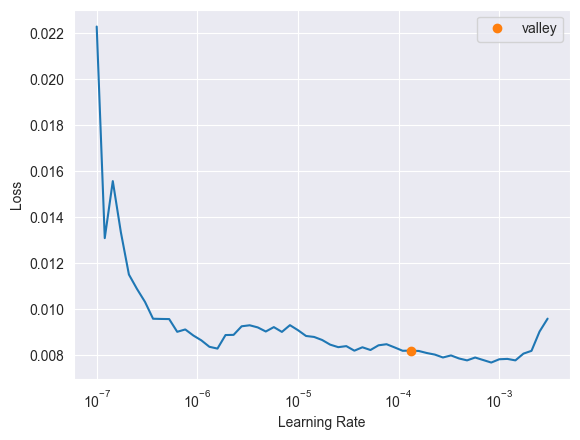

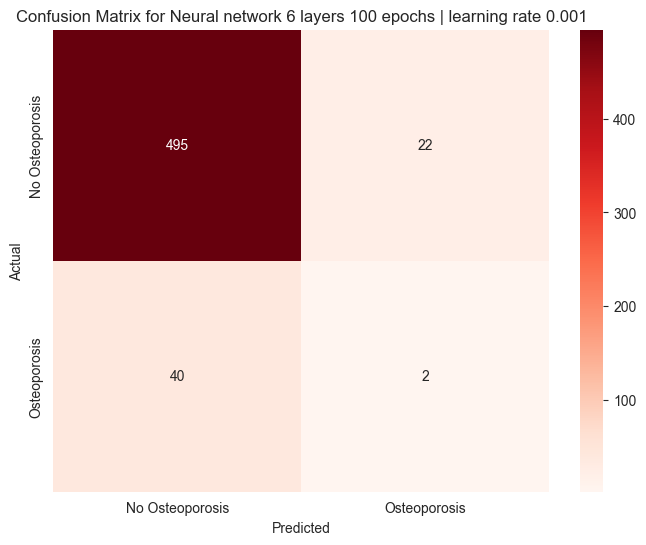

Classification Report for Neural network 6 layers 100 epochs | learning rate 0.001:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       517
           1       0.08      0.05      0.06        42

    accuracy                           0.89       559
   macro avg       0.50      0.50      0.50       559
weighted avg       0.86      0.89      0.87       559




In [131]:
preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64,32,16, 8],
              metrics=accuracy,
              epochs=100,
              learning_rate=1e-3,
              threshold_true=0.5)

### Evaluation first trainig of NN

As we can see from the plots above, 100 epochs is way too much for 5 layers. We see the training loss decreasing after each epoch, but the validation loss starts to increase after a certain number of epochs. We can see that at 29 epochs, the validation loss is 0.3, while at 35 epochs the validation loss is 0.36. Quickly shooting up to 0.4 afterwards. So we set the number of epochs to 40 and a lower learning rate.

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.00015848931798245758)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 6 layers 35 epochs | learning rate 0.001:
    Accuracy: 0.89
    Precision: 0.15
    Recall: 0.10
    F1 Score: 0.12
    ROC-AUC: 0.53



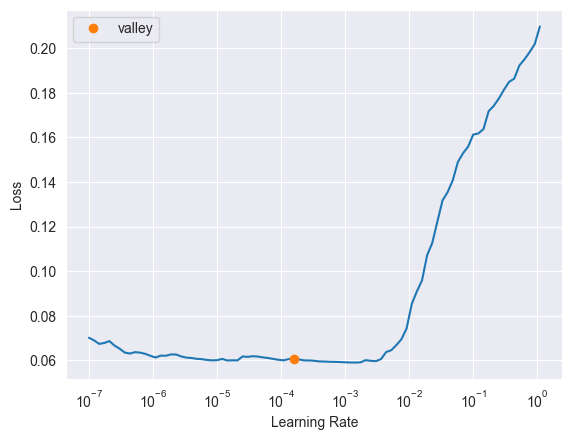

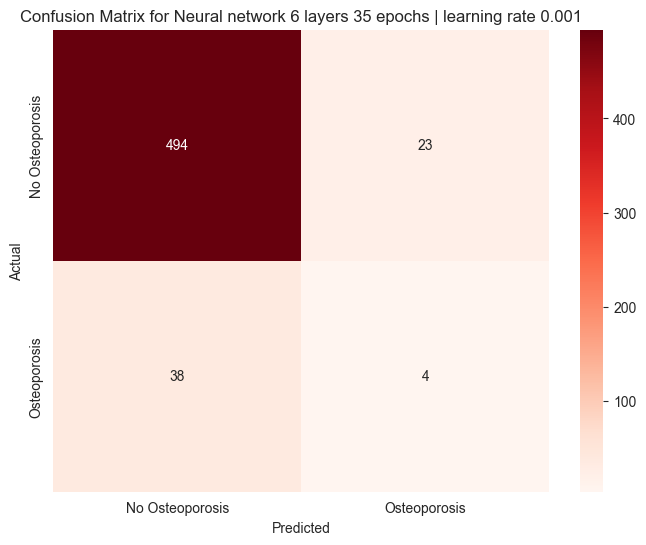

Classification Report for Neural network 6 layers 35 epochs | learning rate 0.001:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       517
           1       0.15      0.10      0.12        42

    accuracy                           0.89       559
   macro avg       0.54      0.53      0.53       559
weighted avg       0.87      0.89      0.88       559




In [132]:
preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64,32,16, 8],
              metrics=accuracy,
              epochs=35,
              learning_rate=1e-3,
              threshold_true=0.5)

### Changing the thresholds



train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.0003981071640737355)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 6 layers 35 epochs | learning rate 0.001:
    Accuracy: 0.88
    Precision: 0.10
    Recall: 0.07
    F1 Score: 0.08
    ROC-AUC: 0.51



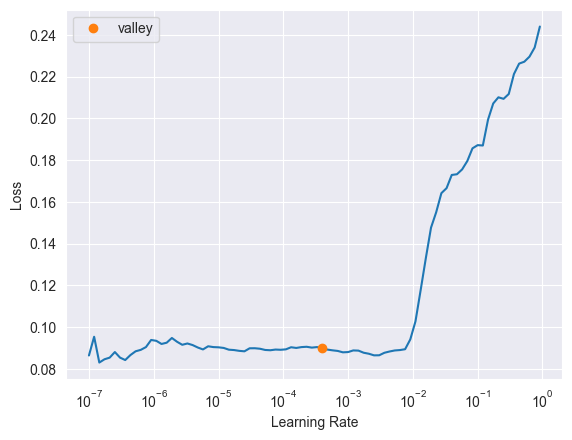

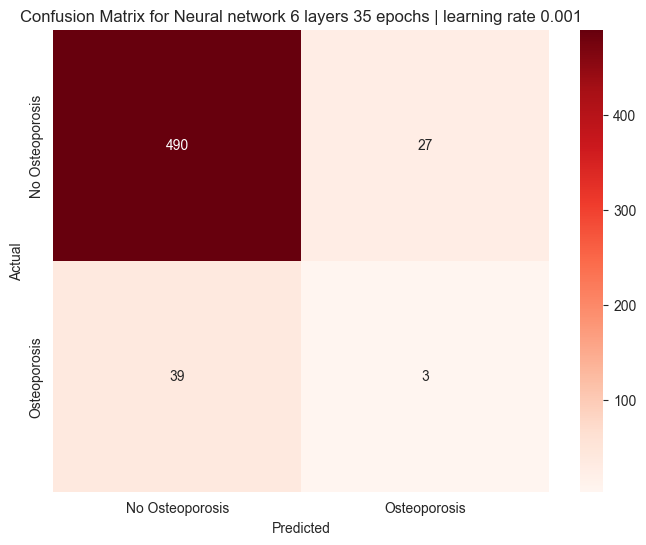

Classification Report for Neural network 6 layers 35 epochs | learning rate 0.001:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       517
           1       0.10      0.07      0.08        42

    accuracy                           0.88       559
   macro avg       0.51      0.51      0.51       559
weighted avg       0.86      0.88      0.87       559




In [133]:
preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64,32,16, 8],
              metrics=accuracy,
              epochs=35,
              learning_rate=1e-3,
              threshold_true=0.4)

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.0063095735386013985)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 5 layers 10 epochs | learning rate 0.001:
    Accuracy: 0.70
    Precision: 0.12
    Recall: 0.48
    F1 Score: 0.19
    ROC-AUC: 0.60



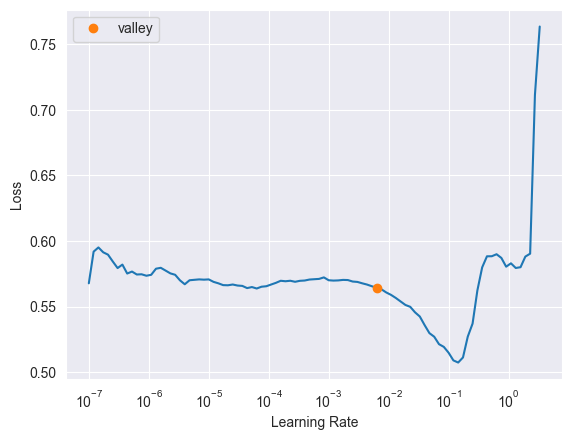

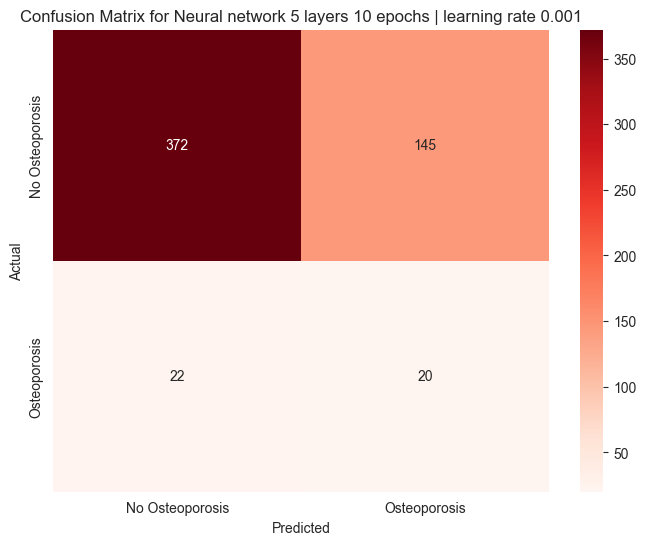

Classification Report for Neural network 5 layers 10 epochs | learning rate 0.001:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       517
           1       0.12      0.48      0.19        42

    accuracy                           0.70       559
   macro avg       0.53      0.60      0.50       559
weighted avg       0.88      0.70      0.77       559




In [134]:
preds_nn, targets_nn = train_fast_nn(layers=[128, 64,32,16, 8],
              metrics=accuracy,
              epochs=10,
              learning_rate=1e-3,
              threshold_true=0.5)

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=4.365158383734524e-05)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 3 layers 50 epochs | learning rate 0.001:
    Accuracy: 0.89
    Precision: 0.12
    Recall: 0.07
    F1 Score: 0.09
    ROC-AUC: 0.51



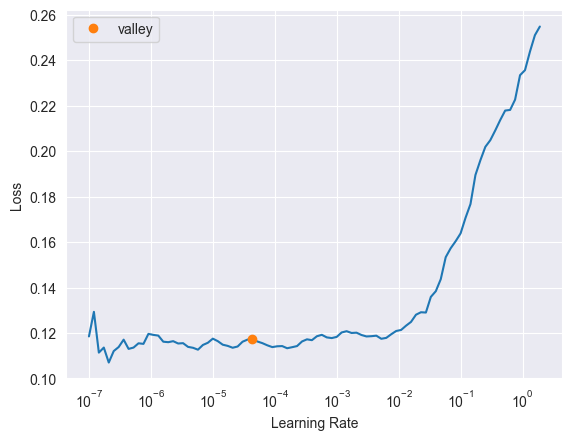

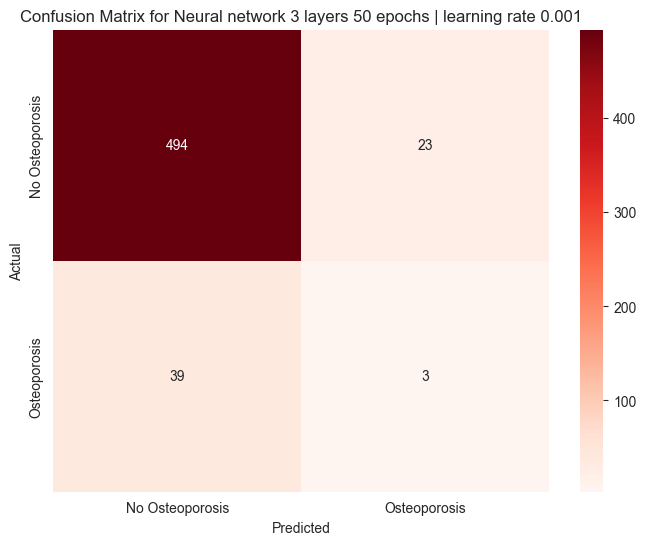

Classification Report for Neural network 3 layers 50 epochs | learning rate 0.001:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       517
           1       0.12      0.07      0.09        42

    accuracy                           0.89       559
   macro avg       0.52      0.51      0.51       559
weighted avg       0.87      0.89      0.88       559




In [135]:
preds_nn, targets_nn = train_fast_nn(layers=[64,16, 8],
              metrics=accuracy,
              epochs=50,
              learning_rate=1e-3,
              threshold_true=0.5)

### Change of plans

The model accuracy is very good last time, but we are mostly interested in a good precision, while also not having too many false positives. But most important are that we know who might have osteoporosis

So let's experiment with a different metric to optimize

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.033113110810518265)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 3 layers 15 epochs | learning rate 0.001:
    Accuracy: 0.63
    Precision: 0.13
    Recall: 0.71
    F1 Score: 0.22
    ROC-AUC: 0.67



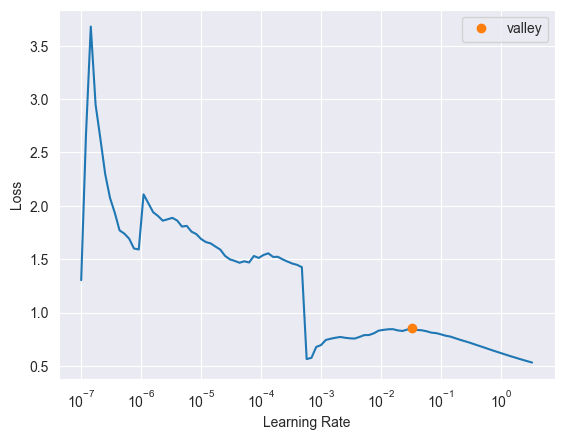

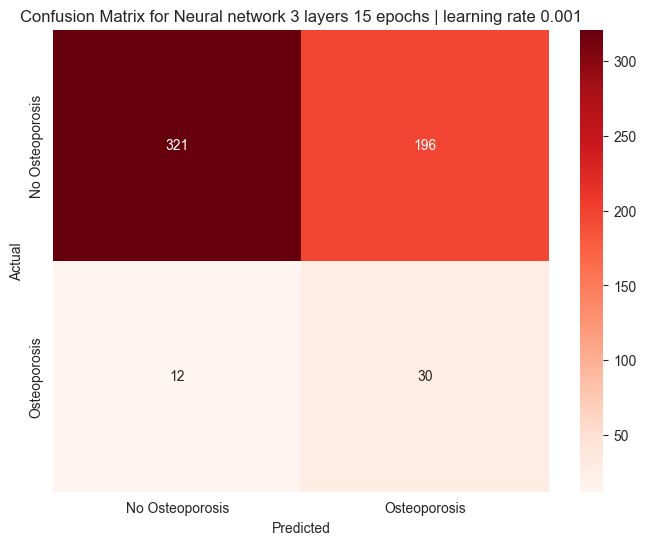

Classification Report for Neural network 3 layers 15 epochs | learning rate 0.001:
              precision    recall  f1-score   support

           0       0.96      0.62      0.76       517
           1       0.13      0.71      0.22        42

    accuracy                           0.63       559
   macro avg       0.55      0.67      0.49       559
weighted avg       0.90      0.63      0.72       559




In [136]:
import torch

class PrecisionLoss:
    def __call__(self, preds_y, targets_y):
        preds_y_sig = torch.sigmoid(preds_y)
        tp = (preds_y_sig * targets_y).sum()
        fp = ((1 - targets_y) * preds_y).sum()
        return -tp / (tp + fp + 1e-8)  # Negative precision to minimize the loss


preds_nn, targets_nn = train_fast_nn(layers=[128, 64, 8],
              metrics=Precision(),
              loss_func=PrecisionLoss(),
              epochs=15,
              learning_rate=1e-3,
              threshold_true=0.5)


## Adjusting the min threshold

Let's try the regular approach, of using the accuracy metric, whioe using the minimum threshold to 0.4. This will lead to, the when a the model's confidence in true ratio is at least 0.4 then it becomes true.


train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.002511886414140463)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 3 layers 8 epochs | learning rate 0.001:
    Accuracy: 0.51
    Precision: 0.11
    Recall: 0.74
    F1 Score: 0.19
    ROC-AUC: 0.62



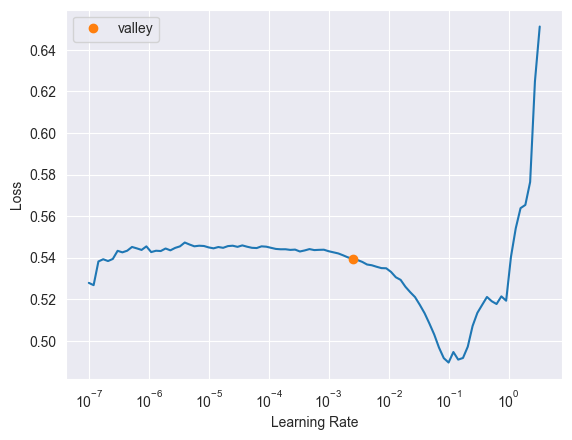

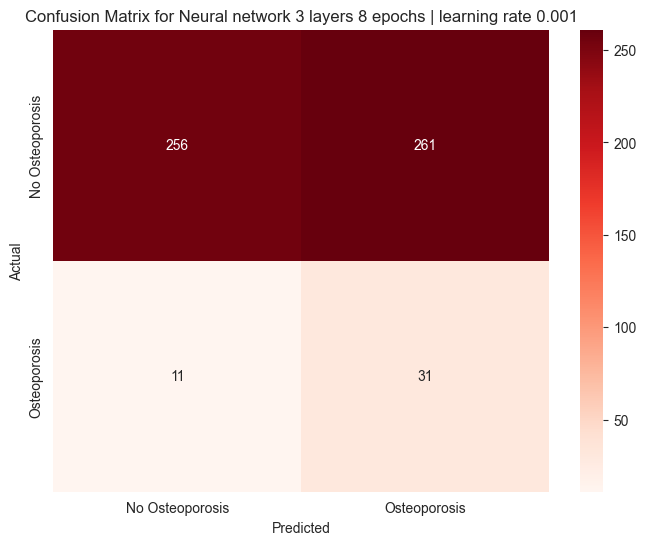

Classification Report for Neural network 3 layers 8 epochs | learning rate 0.001:
              precision    recall  f1-score   support

           0       0.96      0.50      0.65       517
           1       0.11      0.74      0.19        42

    accuracy                           0.51       559
   macro avg       0.53      0.62      0.42       559
weighted avg       0.89      0.51      0.62       559




In [137]:
preds_nn, targets_nn = train_fast_nn(layers=[128, 64, 8],
              metrics=accuracy,
              #loss_func=PrecisionLoss(),
              epochs=8,
              learning_rate=1e-3,
              threshold_true=0.4)


THe model above finds almost all people with osteoporosis. but it also misclassified 80% of the participants.

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.0006918309954926372)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 4 layers 22 epochs | learning rate 0.0012:
    Accuracy: 0.85
    Precision: 0.16
    Recall: 0.24
    F1 Score: 0.19
    ROC-AUC: 0.57



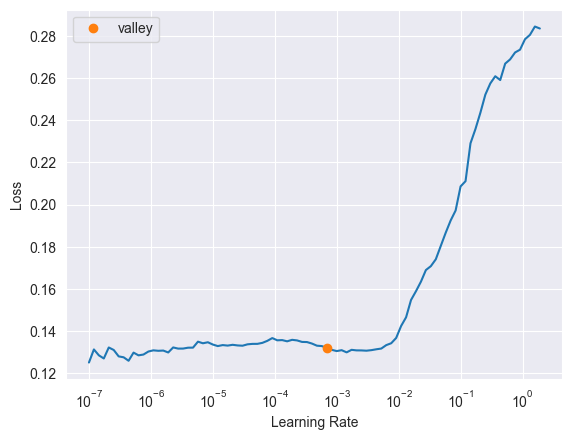

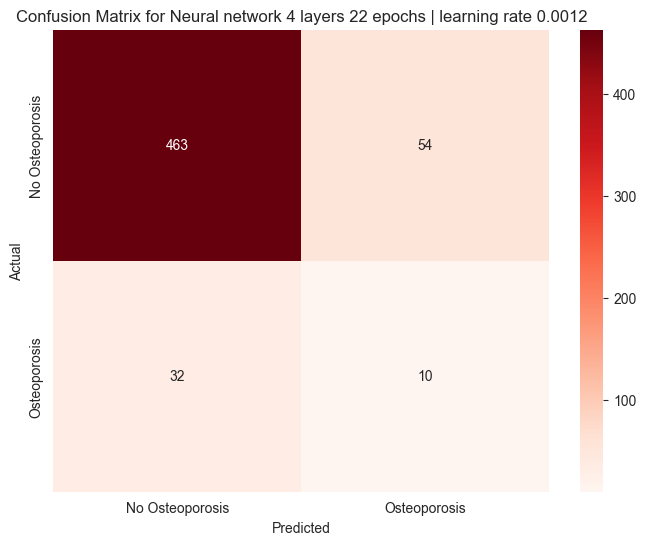

Classification Report for Neural network 4 layers 22 epochs | learning rate 0.0012:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       517
           1       0.16      0.24      0.19        42

    accuracy                           0.85       559
   macro avg       0.55      0.57      0.55       559
weighted avg       0.88      0.85      0.86       559




In [138]:
preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64, 8],
              metrics=Precision(),
              epochs=22,
              learning_rate=1.2e-3,
              threshold_true=0.35)


## Try out F1-score

We see that we have to keep our amount of epochs low, when we make them too high they start overfitting themselves

train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.019054606556892395)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 4 layers 8 epochs | learning rate 0.0012:
    Accuracy: 0.75
    Precision: 0.09
    Recall: 0.26
    F1 Score: 0.13
    ROC-AUC: 0.52



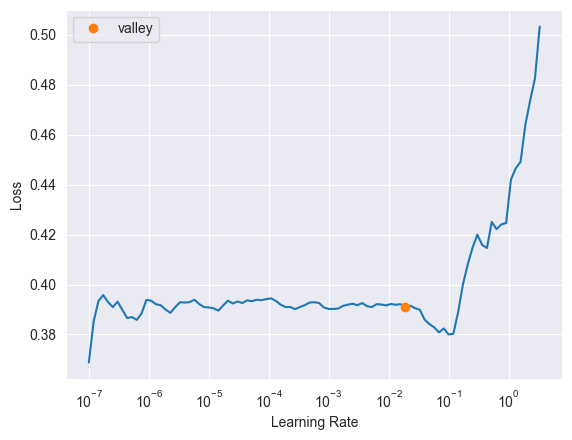

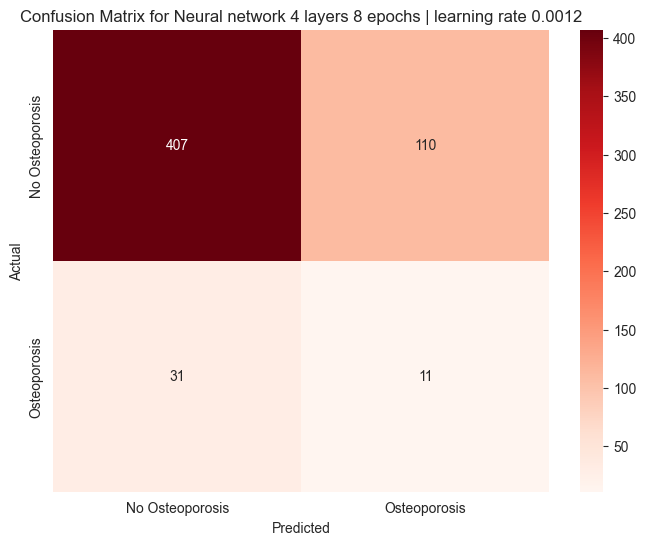

Classification Report for Neural network 4 layers 8 epochs | learning rate 0.0012:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       517
           1       0.09      0.26      0.13        42

    accuracy                           0.75       559
   macro avg       0.51      0.52      0.49       559
weighted avg       0.87      0.75      0.80       559




In [139]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2, beta = 1)

preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64, 8],
              metrics=F1Score(),
              epochs=8,
              learning_rate=1.2e-3,
              threshold_true=0.45)


train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.019054606556892395)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 6 layers 50 epochs | learning rate 0.00012:
    Accuracy: 0.53
    Precision: 0.08
    Recall: 0.52
    F1 Score: 0.14
    ROC-AUC: 0.52



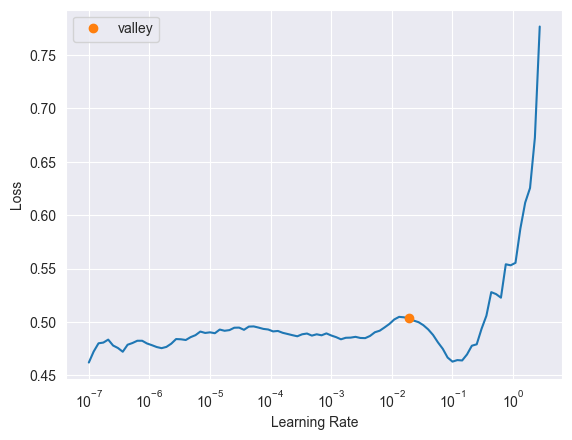

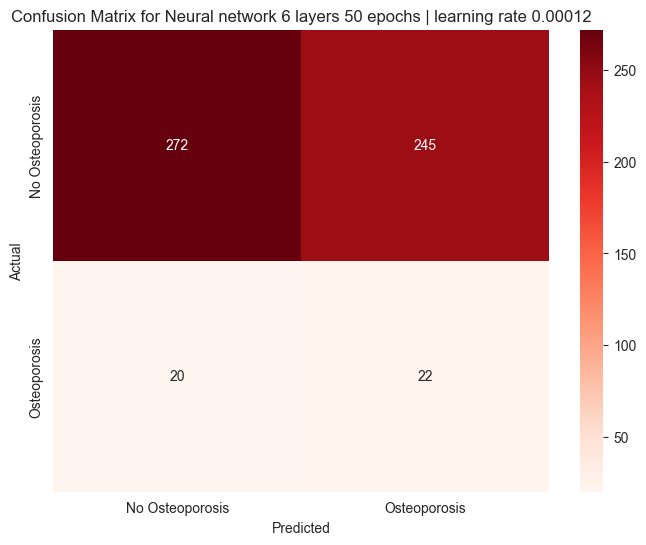

Classification Report for Neural network 6 layers 50 epochs | learning rate 0.00012:
              precision    recall  f1-score   support

           0       0.93      0.53      0.67       517
           1       0.08      0.52      0.14        42

    accuracy                           0.53       559
   macro avg       0.51      0.52      0.41       559
weighted avg       0.87      0.53      0.63       559




In [140]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2, beta = 1)

preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64, 128,64, 8],
              metrics=F1Score(),
              epochs=50,
              learning_rate=1.2e-4,
              threshold_true=0.45)


train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.009120108559727669)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 4 layers 8 epochs | learning rate 0.0012:
    Accuracy: 0.74
    Precision: 0.11
    Recall: 0.33
    F1 Score: 0.16
    ROC-AUC: 0.55



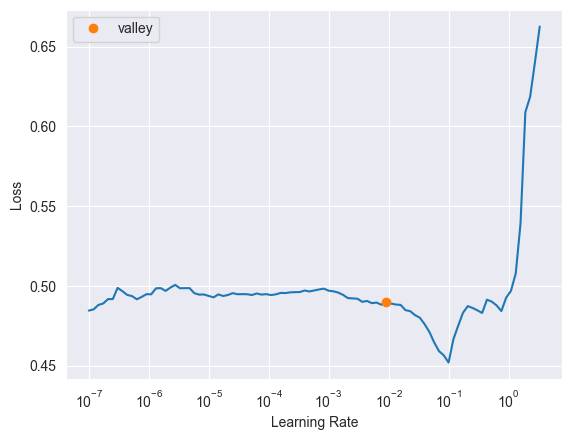

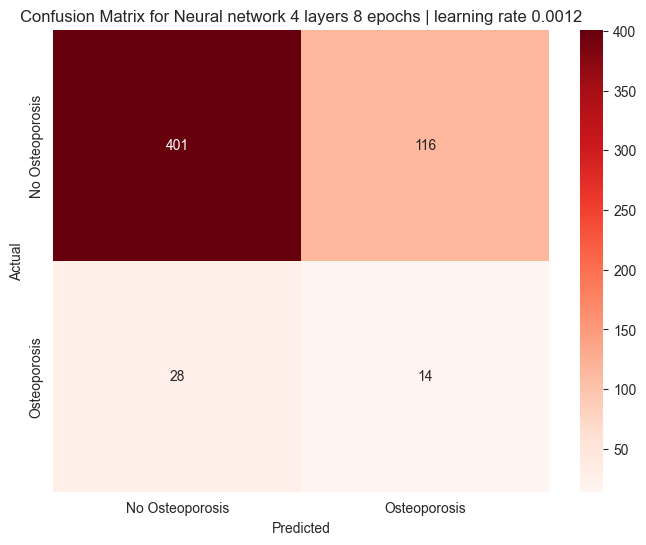

Classification Report for Neural network 4 layers 8 epochs | learning rate 0.0012:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       517
           1       0.11      0.33      0.16        42

    accuracy                           0.74       559
   macro avg       0.52      0.55      0.51       559
weighted avg       0.87      0.74      0.80       559




In [141]:
preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64, 8],
              metrics=[F1Score(), accuracy],
              epochs=8,
              learning_rate=1.2e-3,
              threshold_true=0.5)



train_indices =  2233
test_indices =  559
total =  2792
df_confidence =  2792


SuggestedLRs(valley=0.0003981071640737355)


/Users/mehdigreefhorst/Desktop/Individual Assignment Data Mining/venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

Evaluation for Neural network 4 layers 25 epochs | learning rate 0.0012:
    Accuracy: 0.82
    Precision: 0.09
    Recall: 0.17
    F1 Score: 0.12
    ROC-AUC: 0.52



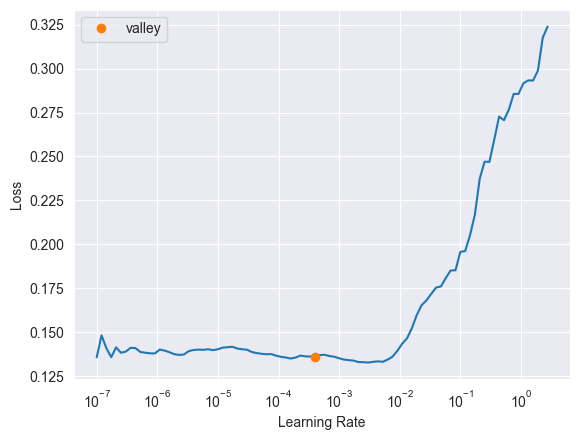

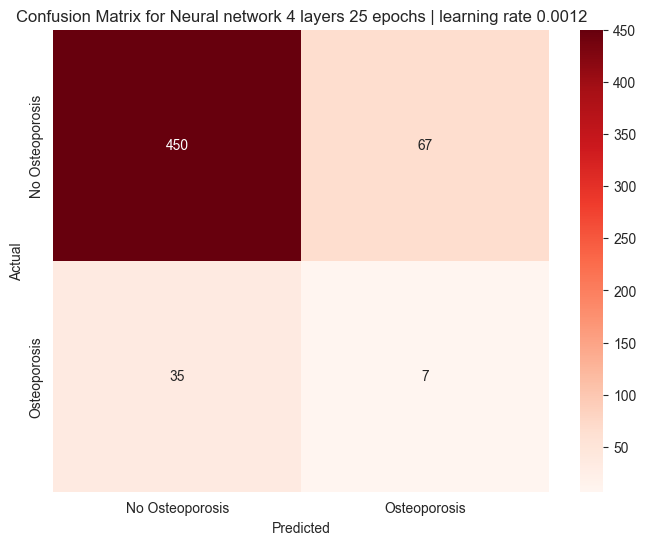

Classification Report for Neural network 4 layers 25 epochs | learning rate 0.0012:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       517
           1       0.09      0.17      0.12        42

    accuracy                           0.82       559
   macro avg       0.51      0.52      0.51       559
weighted avg       0.87      0.82      0.84       559




In [142]:
preds_nn, targets_nn = train_fast_nn(layers=[256, 128, 64, 8],
              metrics=[F1Score(), accuracy],
              epochs=25,
              learning_rate=1.2e-3,
              threshold_true=0.4)



# Conclusion neural network

We experimented with various architectures for the neural network, adjusting both the number of layers and the number of neurons in each layer. Through our trials, we observed that using very few layers did not yield good performance. Similarly, models with too many layers also underperformed, likely due to overfitting or increased complexity.

Optimal Architecture

The optimal architecture we identified consisted of four layers:
	1.	First Layer: 128 neurons
	2.	Second Layer: 64 neurons
	3.	Third Layer: 32 neurons
	4.	Fourth Layer: 8 neurons

This configuration performed the best among all the models we tested, particularly when paired with a learning rate of 1.2e-3.

With a threshold of 0.25, the threshold that conveys the information that when the model is 25% confident in a participant having osteoporosis, we make it true.

Evaluation Metrics

To evaluate the performance of the model, we tested different metrics. Both accuracy and the F1 score proved to be effective evaluation methods for our dataset, with each providing reasonable insights into the model’s performance. In the final model we adjusted the metric to let the network use both the accuracy and F1score to update its weights through back propegation.


# See if the evaluation prediction, also relates to the bone mineral density

To evaluate the usefulness of our predicted labels, we later incorporated bone density measurements into the analysis. Specifically, we grouped all predicted rows by their assigned labels, which allowed us to assess whether the bone density measure aligns with the predicted labels. Initially, we examined the original data, focusing on cases where individuals were labeled as having osteoporosis, and observed that these cases indeed corresponded with lower bone density. We then extended this analysis to predictions made by the neural network and the random forest models, aiming to identify any interesting patterns or insights in the results.

## Examination data


DXDTOBMD -> Total Bone Mineral Density(g / cm ^ 2)
source:https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DXX_H.htm

In [149]:

def get_bone_mineral_density():
    df_examination = pd.read_sas("data/DXX_H.xpt")
    df_examination.rename(columns={"DXDSTBMD": "Total bone density"}, inplace=True)
    return df_examination


df_density = get_bone_mineral_density()

df_density_y_label = df_y_label.merge(df_density[["SEQN", "Total bone density"]], on="SEQN", how="left")
df_density_y_label.groupby('has_osteoporosis').mean()

SEQN  Total bone density
has_osteoporosis                                  
0.0               78626.070999            0.970279
1.0               78669.385093            0.843595

## Evaluate osteoporosis predicted label with bone density measure

We can see that the bone density measure, is indeed lower for people that have labeled themselves as having osteoporosis. 

below you can see what the measure is of bone density grouped by our predicted label of osteoporosis. Sadly, it does not look good. 

In [156]:
def compare_prediction(prediction_y):
    df_density = get_bone_mineral_density()    
    merged_df = X_test.copy()
    print(len(prediction_y))
    y_test_df = pd.DataFrame(y_test)
    y_test_df["prediction"] = prediction_y
    merged_df = merged_df.join(y_test_df)
    df_density_y_label = merged_df.merge(df_density[["SEQN", "Total bone density"]], on="SEQN", how="left")

    
    return df_density_y_label.groupby("prediction").mean()[["has_osteoporosis","Total bone density"]]

def tensor_to_y_prediction(tensors_pred,threshold):
    return [1 if val[1]> threshold else 0 for val in tensors_pred]



### Compare the tuned random forest prediction with the bone density measure


In [157]:
compare_prediction(tuned_rfcpred)

559


has_osteoporosis  Total bone density
prediction                                      
0                   0.060078            0.979305
1                   0.255814            0.955308

### Compare the tuned random forest prediction with the bone density measure


In [153]:
compare_prediction(tensor_to_y_prediction(preds_nn, 0.5))

559


has_osteoporosis  Total bone density
prediction                                      
0                   0.075248            0.979311
1                   0.074074            0.963650